In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload
from scipy.interpolate import interp1d

# Get the spectra for a given day

In [2]:
#Defining the directory names used to extract the data.
day = '2023-01-26'
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Solar-data/'+day
os.chdir(location)
dir_name = 'Corr-data'
blaze_dir = 'Blaze-data'
CCF_dir_name = 'CCF_RV-data'

#Creating a directory to store the results.
if not os.path.exists('Plot_Results'):
    os.mkdir('Plot_Results')

# Extract data

In [3]:
reload(AF)

#Extracting the data
tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)



# Data reduction

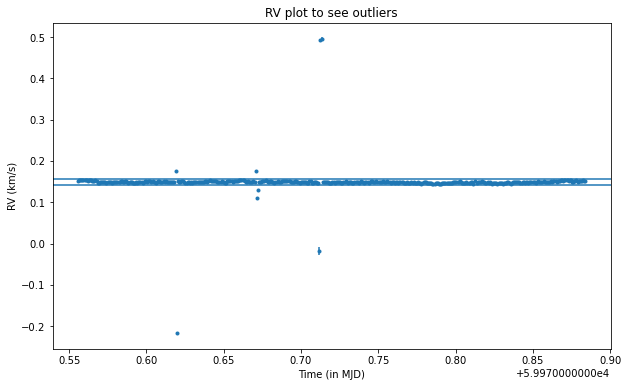

In [4]:
reload(AF)
#Defining a variable to save or not the results.
save = False

#Plotting the RV time series to see the cut and the possible outliers.
    
IQR = np.percentile(tot_RV, 75)-np.percentile(tot_RV, 25)

plt.figure(figsize=[10, 6])
plt.errorbar(tot_date, tot_RV, yerr = tot_RV_err, fmt='.')
plt.axhline((1+20*IQR)*np.median(tot_RV))
plt.axhline((1-20*IQR)*np.median(tot_RV))
plt.xlabel('Time (in MJD)')
plt.ylabel('RV (km/s)')
plt.title('RV plot to see outliers')
plt.show()


In [5]:
reload(AF)

sig = 100

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    
    #Performing the data reduction by SNR and RV clipping.
    total_SNR_HA, total_SNR_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_SNR, tot_RV, tot_AIRM, sig)
    
    total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, tot_AIRM, sig)

    tota_norm_spctr_HA, tota_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, tot_AIRM, sig)

    total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, tot_AIRM, sig)
    
    total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, tot_AIRM, sig)

    tota_norm_err_HA, tota_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, tot_AIRM, sig)
    
    date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, tot_AIRM, sig)


#If there is one mode of observation
else:
    
    #Performing the data reduction by SNR and RV clipping.
    
    total_SNR = AF.segment_and_reduce(tot_mode, tot_SNR, tot_SNR, tot_RV, tot_AIRM, sig)

    total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, tot_AIRM, sig)

    tota_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, tot_AIRM, sig)

    total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, tot_AIRM, sig)
    
    total_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, tot_AIRM, sig)

    tota_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, tot_AIRM, sig)
    
    date = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, tot_AIRM, sig)
    
mode = tot_mode

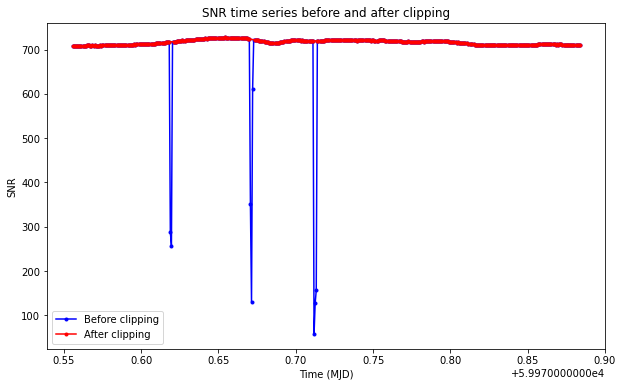

In [6]:
#Plotting the SNR time series to make sure the outliers have been removed
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    plt.figure(figsize=[10, 6])
    plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
    plt.plot(date_HA, total_SNR_HA, 'r.', linestyle='-', label='After clipping')
    plt.plot(date_HE, total_SNR_HE, 'r.', linestyle='-')
    plt.xlabel('Time (MJD)')
    plt.ylabel('SNR')
    plt.title('SNR time series before and after clipping')
    plt.legend()
else:
    plt.figure(figsize=[10, 6])
    plt.plot(tot_date, tot_SNR, 'b.', linestyle='-', label='Before clipping')
    plt.plot(date, total_SNR, 'r.', linestyle='-', label='After clipping')
    plt.xlabel('Time (MJD)')
    plt.ylabel('SNR')
    plt.title('SNR time series before and after clipping')
    plt.legend()

# Interpolation to have fixed wavelength grid

In [7]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):

    min_lamda = max(max(total_lamda_HA[:, 0]), max(total_lamda_HE[:, 0]))
    max_lamda = min(min(total_lamda_HA[:, -1]), min(total_lamda_HE[:, -1]))

    step = (np.mean(np.diff(total_lamda_HA))+np.mean(np.diff(total_lamda_HE)))/2
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda_HA[0]))
    
    total_norm_spctr_HA = np.zeros(tota_norm_spctr_HA.shape)
    total_norm_spctr_HE = np.zeros(tota_norm_spctr_HE.shape)
    
    total_norm_err_HA = np.zeros(tota_norm_err_HA.shape)
    total_norm_err_HE = np.zeros(tota_norm_err_HE.shape)
    
    for i in range(len(tota_norm_spctr_HA)):
        
        interpol_s = interp1d(total_lamda_HA[i], tota_norm_spctr_HA[i])
        total_norm_spctr_HA[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HA[i], tota_norm_err_HA[i])
        total_norm_err_HA[i] = interpol_err(ref_wave)
        
    for i in range(len(tota_norm_spctr_HE)):
        
        interpol_s = interp1d(total_lamda_HE[i], tota_norm_spctr_HE[i])
        total_norm_spctr_HE[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HE[i], tota_norm_err_HE[i])
        total_norm_err_HE[i] = interpol_err(ref_wave)
        
else:
    
    min_lamda = max(total_lamda[:, 0])
    max_lamda = min(total_lamda[:, -1])

    step = np.mean(np.diff(total_lamda))
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda[0]))
    
    total_norm_spctr = np.zeros(tota_norm_spctr.shape)

    total_norm_err = np.zeros(tota_norm_err.shape)
        
    for i in range(len(tota_norm_spctr)):
        
        interpol_s = interp1d(total_lamda[i], tota_norm_spctr[i])
        total_norm_spctr[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda[i], tota_norm_err[i])
        total_norm_err[i] = interpol_err(ref_wave)

# Planetary signal simulation

In [8]:
###################################################################################
################# ADAPTED FROM WILLIAM DETHIER'S CODE #############################
###################################################################################

In [9]:
os.chdir('/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet')
import spectrum_model as spec_mod

In [10]:
##Defining the parameters for the planetary abosprtion simulation

# Helium density
density = 5e14

# Helium temperature -- thermal broadening
temperature = 10000

# Stellar rotation velocity -- non-thermal broadening
vsini = 2

# Reference medium for the wavelengths
medium= "VACUUM"

# Instrumental resolving power e.g. R_pow = 70000
# For non thermal broadening
# see spectrum_he() in spectrum_model.py to know where to write the argument

if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    R_power_HE = 74000
    R_power_HA = 86000
else:
    if mode[0] == 'A':
        R_power = 86000
    else:
        R_power = 74000
# Microturbulence
# for non thermal broadening
# micro_t = 1

# You can change the damping to have Voigt profiles, by default you have Gaussian profiles
# Set to value greater than 0
# d_damping = 0

## Simulating on one spectrum to see what it looks like

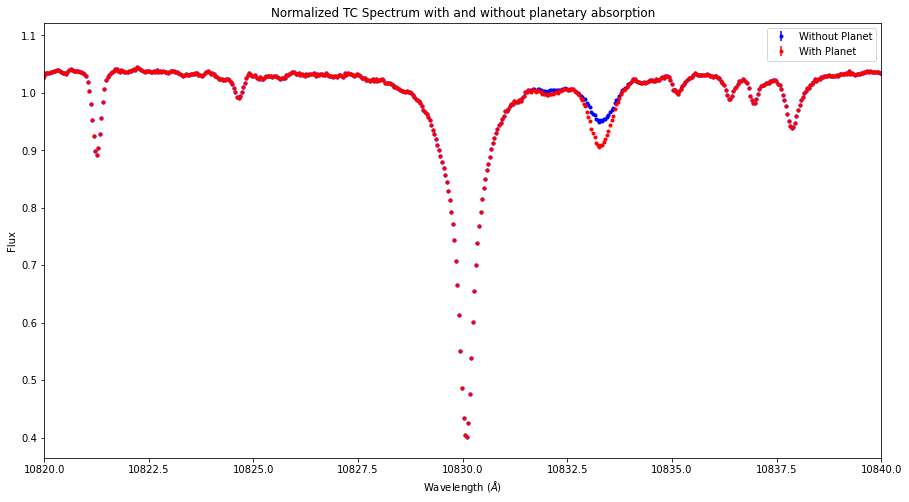

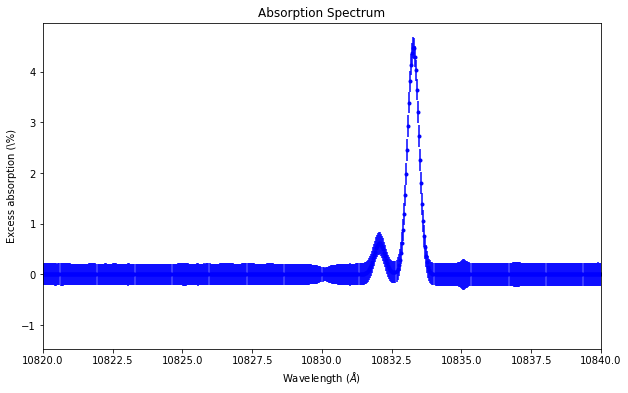

In [11]:
reload(AF)

#Random index of the spectrum to plot.
idx = 10

#Defining a variable to save or not the results.
save = False

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.
    
    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr_HE[idx], yerr = total_norm_err_HE[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = theoretical_err, fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption for HE')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr_HE[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err_HE[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (%)')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.

    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr[idx], temperature, density, vsini, medium, R_pow = R_power)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err[idx], temperature, density, vsini, medium, R_pow = R_power)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr[idx], yerr = total_norm_err[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = total_norm_err[idx], fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (\%)')
    plt.xlim([10820, 10840])
    plt.show()




## Defining in-transit and out-of-transit parts of the timeseries

In [12]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):    
    
    #Defining the bounds of transit
    low_bound_HA = int(len(date_HA)/4)
    up_bound_HA = int(3*len(date_HA)/4)
    
    low_bound_HE = int(len(date_HE)/4)
    up_bound_HE = int(3*len(date_HE)/4)


    #Making the spectra
    #Before transit
    out_transit_spctr_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_err_HA)
    #In transit
    in_transit_spctr_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_spctr_HA)
    in_transit_err_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_err_HA)
    #After transit
    out_transit_spctr_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_err_HA)
    #Out-of-transit
    out_transit_spctr_HA = np.concatenate((out_transit_spctr_HA_1, out_transit_spctr_HA_2)) 
    out_transit_err_HA = np.concatenate((out_transit_err_HA_1, out_transit_err_HA_2)) 

    #Before transit
    out_transit_spctr_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_err_HE)
    #In transit
    in_transit_spctr_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_spctr_HE)
    in_transit_err_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_err_HE)
    #After transit
    out_transit_spctr_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_err_HE)
    #Out-of-transit
    out_transit_spctr_HE = np.concatenate((out_transit_spctr_HE_1, out_transit_spctr_HE_2)) 
    out_transit_err_HE = np.concatenate((out_transit_err_HE_1, out_transit_err_HE_2)) 
  
    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, date_HA)
    date_in_transit_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, date_HE)

#If there is one mode of observation
else:    
    #Defining the bounds of transit
    low_bound = int(len(date)/4)
    up_bound = int(3*len(date)/4)
 
    #Making the spectra
    #Before transit
    out_transit_spctr_1 = AF.bound(date[0], date[low_bound], date, total_norm_spctr)
    out_transit_err_1 = AF.bound(date[0], date[low_bound], date, total_norm_err)
    #In transitc
    in_transit_spctr = AF.bound(date[low_bound], date[up_bound], date, total_norm_spctr)
    in_transit_err = AF.bound(date[low_bound], date[up_bound], date, total_norm_err)
    #After transit
    out_transit_spctr_2 = AF.bound(date[up_bound], date[-1], date, total_norm_spctr)
    out_transit_err_2 = AF.bound(date[up_bound], date[-1], date, total_norm_err)
    #Out-of-transit
    out_transit_spctr = np.concatenate((out_transit_spctr_1, out_transit_spctr_2)) 
    out_transit_err = np.concatenate((out_transit_err_1, out_transit_err_2)) 

    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit = AF.bound(date[low_bound], date[up_bound], date, date)


## Adding the planetary signal during the transit

In [13]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr_HA = np.ones(in_transit_spctr_HA.shape)
    planet_in_transit_err_HA = np.ones(in_transit_err_HA.shape)
    
    planet_in_transit_spctr_HE = np.ones(in_transit_spctr_HE.shape)
    planet_in_transit_err_HE = np.ones(in_transit_err_HE.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr_HA)):

        planet_in_transit_spctr_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
        planet_in_transit_err_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
    
    for i in range(len(in_transit_spctr_HE)):

        planet_in_transit_spctr_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)
        planet_in_transit_err_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)

#If there is one mode of observation    
else:
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr = np.ones(in_transit_spctr.shape)
    planet_in_transit_err = np.ones(in_transit_err.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr)):

        planet_in_transit_spctr[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr[i], temperature, density, vsini, medium, R_pow = R_power)
        planet_in_transit_err[i] = spec_mod.spectrum_he(ref_wave, in_transit_err[i], temperature, density, vsini, medium, R_pow = R_power)



## Getting the master spectrum in and out of transit

In [14]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit_HA = np.average(planet_in_transit_spctr_HA, axis=0, weights = 1/planet_in_transit_err_HA**2)
    master_err_intransit_HA = 1/np.sqrt(np.sum(1/planet_in_transit_err_HA**2, axis=0))
    
    master_planet_intransit_HE = np.average(planet_in_transit_spctr_HE, axis=0, weights = 1/planet_in_transit_err_HE**2)
    master_err_intransit_HE = 1/np.sqrt(np.sum(1/planet_in_transit_err_HE**2, axis=0))

    #Out-of-transit
    master_outtransit_HA = np.average(out_transit_spctr_HA, axis=0, weights = 1/out_transit_err_HA**2)
    master_err_outtransit_HA = 1/np.sqrt(np.sum(1/out_transit_err_HA**2, axis=0))
    
    master_outtransit_HE = np.average(out_transit_spctr_HE, axis=0, weights = 1/out_transit_err_HE**2)
    master_err_outtransit_HE = 1/np.sqrt(np.sum(1/out_transit_err_HE**2, axis=0))
    
#If there is one mode of observation
else:
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit = np.average(planet_in_transit_spctr, axis=0, weights = 1/planet_in_transit_err**2)
    master_err_intransit = 1/np.sqrt(np.sum(1/planet_in_transit_err**2, axis=0))

    #Out-of-transit
    master_outtransit = np.average(out_transit_spctr, axis=0, weights = 1/out_transit_err**2)
    master_err_outtransit = 1/np.sqrt(np.sum(1/out_transit_err**2, axis=0))
    

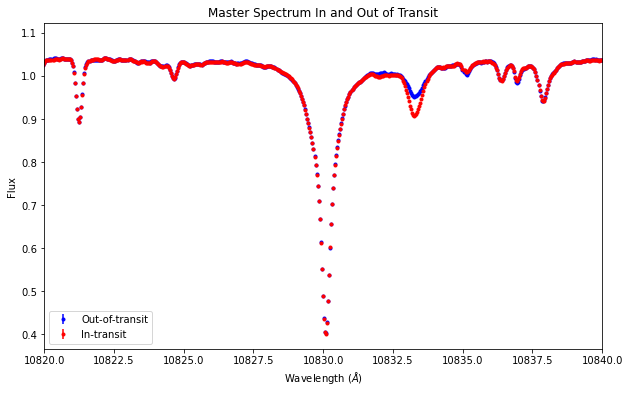

In [15]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HA, yerr = master_err_outtransit_HA, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HA, yerr = master_err_intransit_HA, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HA')
    plt.xlim([10820, 10840])
    plt.show()

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HE, yerr = master_err_outtransit_HE, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HE, yerr = master_err_intransit_HE, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HE')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit, yerr = master_err_outtransit, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit, yerr = master_err_intransit, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit')
    plt.xlim([10820, 10840])
    plt.show()


## Retrieving the planetary parameters once again

In [16]:
reload(AF)

##Defining the difference between the in-transit and master out-of-transit spectra to get 
#a time series of the planet's spectrum
offset = 1

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff_HA = np.ones(planet_in_transit_spctr_HA.shape)
    diff_HA_err = np.ones(planet_in_transit_err_HA.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr_HA)):
        diff_HA[i] = offset+(master_outtransit_HA - planet_in_transit_spctr_HA[i])/master_outtransit_HA
        diff_HA_err[i] = np.sqrt((planet_in_transit_err_HA[i]/master_outtransit_HA)**2 + ((planet_in_transit_spctr_HA[i] * master_err_outtransit_HA)/(master_outtransit_HA**2))**2)
        #diff_HA_err[i] = diff_HA[i] * np.sqrt((planet_in_transit_err_HA[i]/planet_in_transit_spctr_HA[i])**2 + (master_err_outtransit_HA/master_outtransit_HA)**2)
        #diff_HA_err[i] = np.sqrt(((master_outtransit_HA**2 * planet_in_transit_err_HA[i]**2)+(planet_in_transit_spctr_HA[i]**2 * master_err_outtransit_HA**2))/master_outtransit_HA**4)

    diff_HE = np.ones(planet_in_transit_spctr_HE.shape)
    diff_HE_err = np.ones(planet_in_transit_err_HE.shape)
    for i in range(len(planet_in_transit_spctr_HE)):
        diff_HE[i] = offset+(master_outtransit_HE - planet_in_transit_spctr_HE[i])/master_outtransit_HE
        diff_HE_err[i] = np.sqrt((planet_in_transit_err_HE[i]/master_outtransit_HE)**2 + ((planet_in_transit_spctr_HE[i] * master_err_outtransit_HE)/(master_outtransit_HE**2))**2)

#If there is one mode of observation
else:
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff = np.ones(planet_in_transit_spctr.shape)
    diff_err = np.ones(planet_in_transit_err.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr)):
        diff[i] = offset+(master_outtransit - planet_in_transit_spctr[i])/master_outtransit
        diff_err[i] = np.sqrt((planet_in_transit_err[i]/master_outtransit)**2 + ((planet_in_transit_spctr[i] * master_err_outtransit)/(master_outtransit**2))**2)



/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11591559e+04 -4.89974116e+14 -2.60644407e-04]


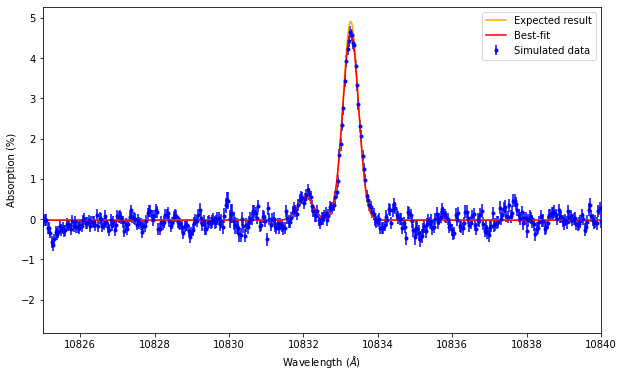

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03186511e+04 -4.83151144e+14  7.11417603e-05]


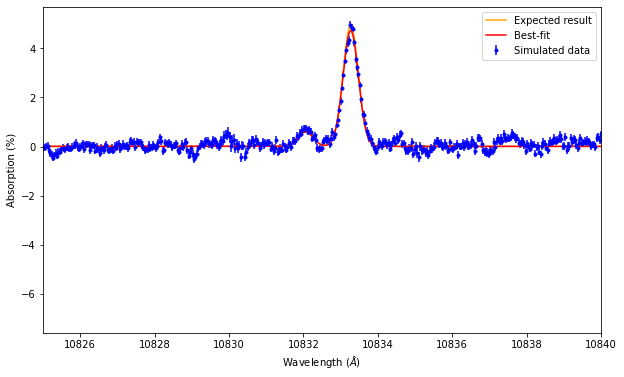

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16552729e+04 -4.99252323e+14  9.68860646e-05]


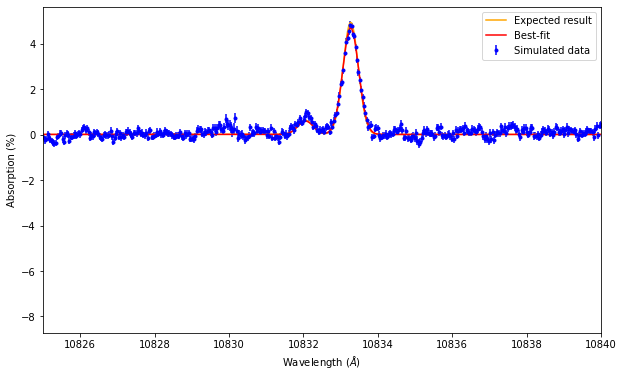

[ 1.47426406e+04 -5.49226323e+14  2.01173698e-04]


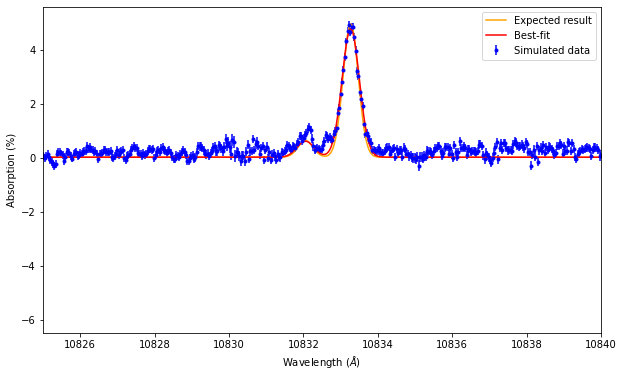

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.70077360e+03 -4.64215895e+14 -1.15034151e-04]


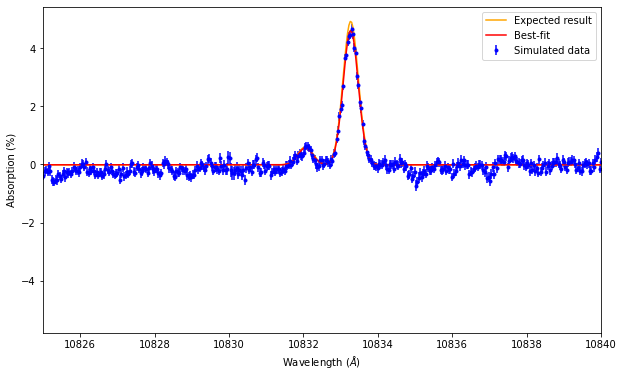

[ 1.32628885e+04 -5.27139205e+14 -7.83673320e-05]


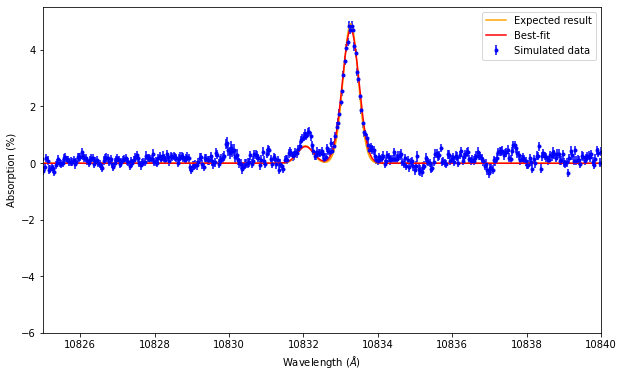

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.95678143e+03 -4.78439868e+14 -1.63804804e-04]


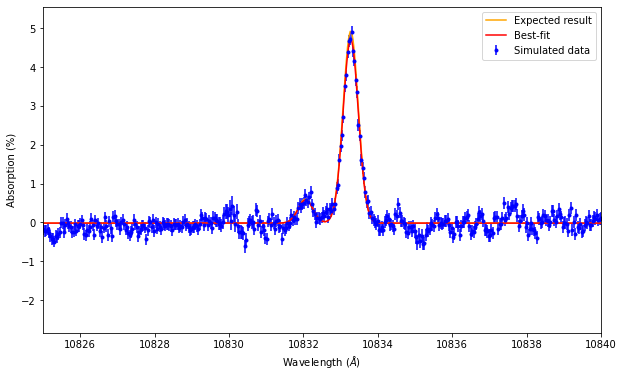

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16653430e+04 -5.13505311e+14 -2.66195842e-05]


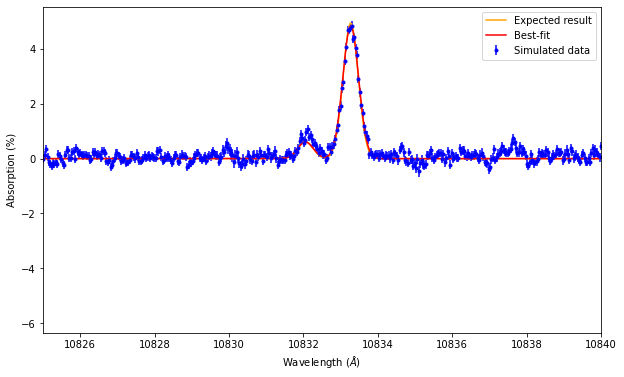

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08688800e+04 -4.78823344e+14 -1.56715882e-04]


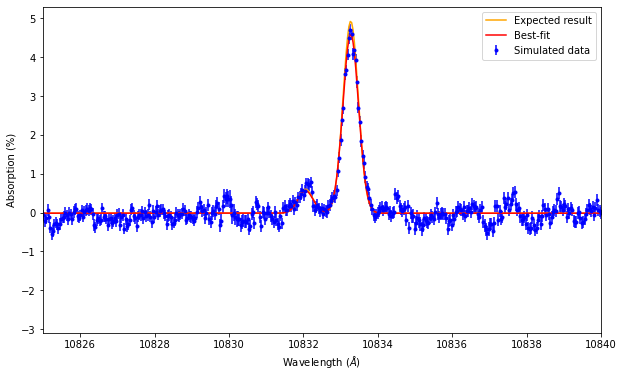

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18563799e+04 -5.03941747e+14  7.68391368e-05]


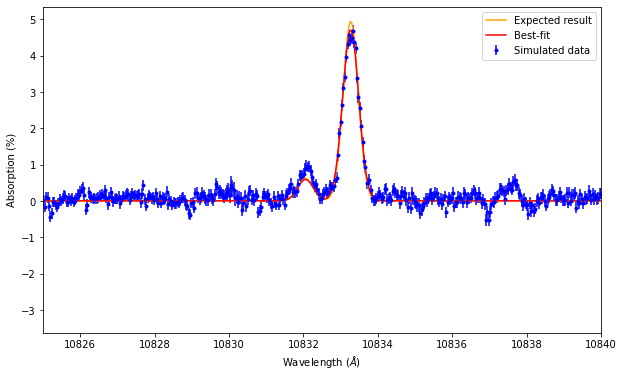

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11228633e+04 -4.88871875e+14  5.50727232e-05]


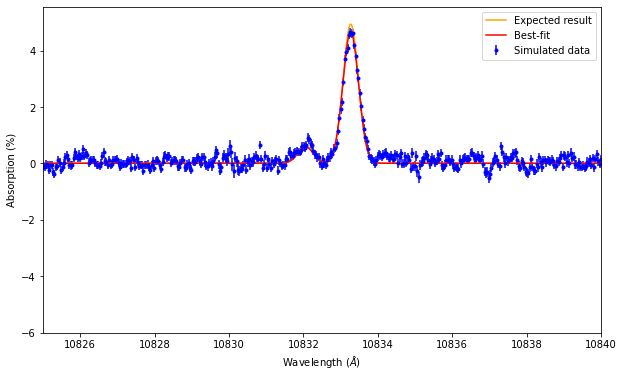

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16702898e+04 -5.12852445e+14 -2.69608362e-04]


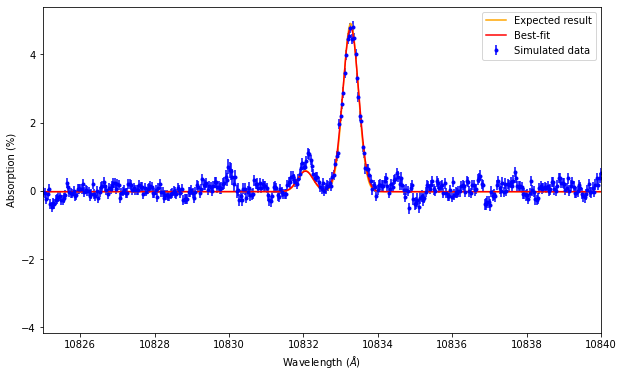

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.20403833e+03 -4.70381311e+14 -3.09755443e-04]


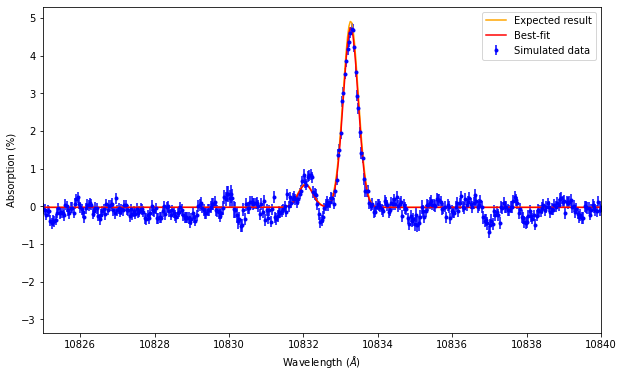

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.71299009e+03 -4.88667868e+14 -3.17627026e-05]


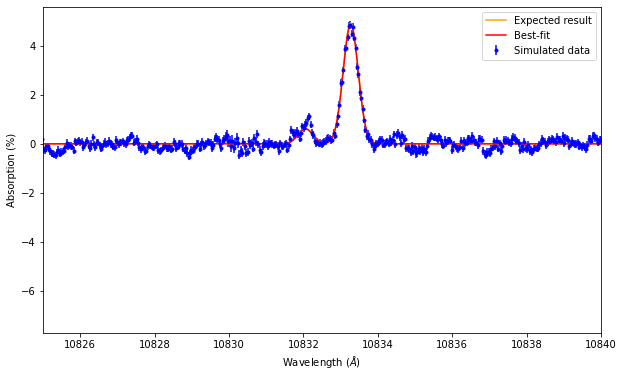

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.79124836e+03 -4.95498381e+14 -2.01821319e-05]


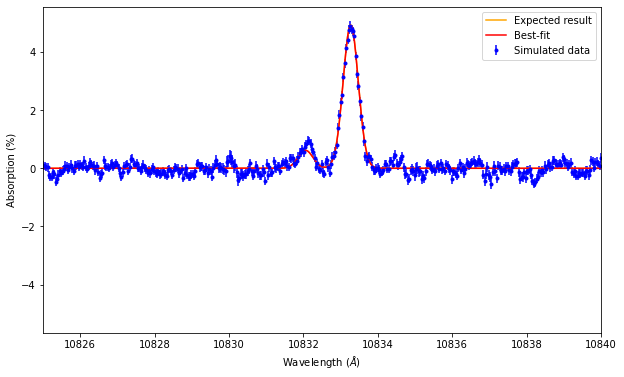

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09795900e+04 -5.17152885e+14  8.42977618e-05]


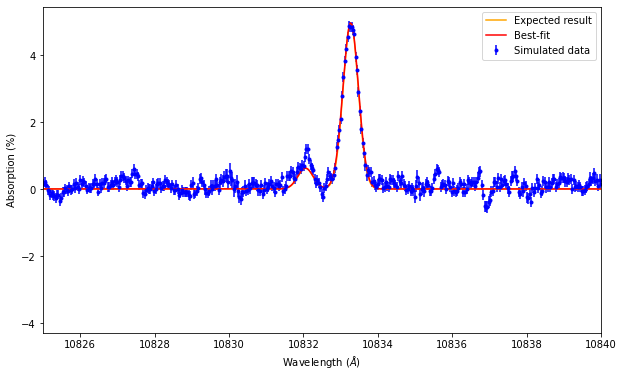

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.40133683e+03 -4.75060820e+14 -1.37628375e-04]


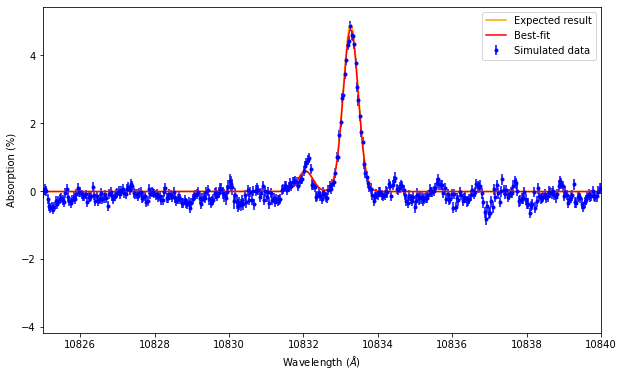

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.44789808e+03 -4.79857249e+14 -1.59314943e-04]


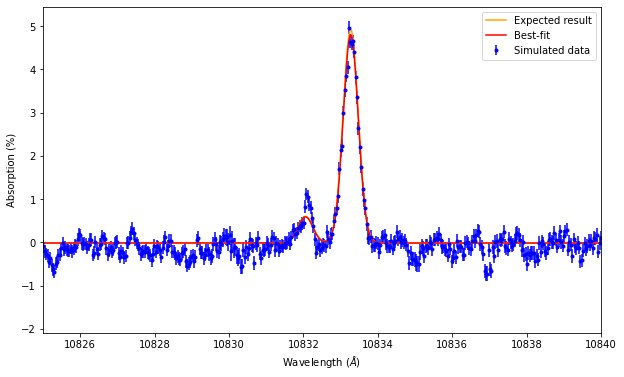

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05427249e+04 -4.91362065e+14  1.39540721e-05]


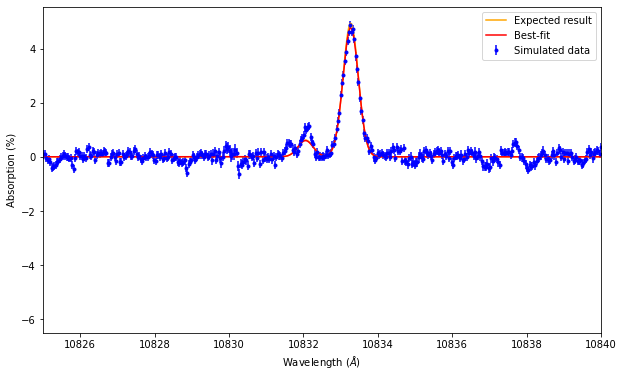

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.10203680e+03 -4.65888460e+14 -1.54724205e-04]


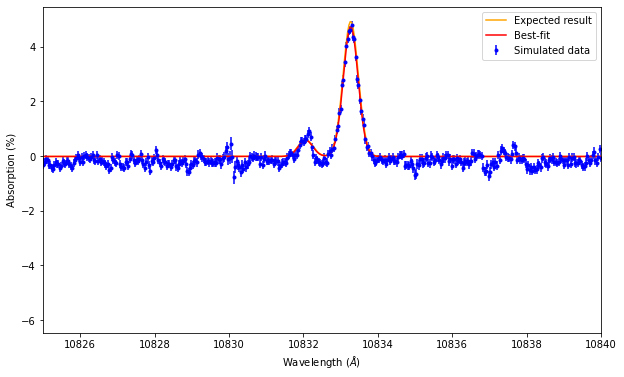

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15080248e+04 -5.15134897e+14 -1.65944398e-04]


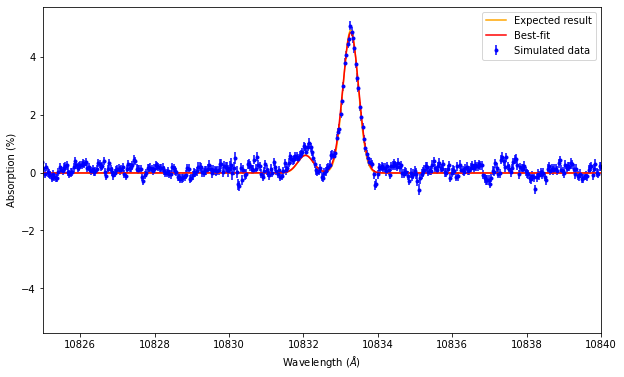

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.98140471e+03 -4.71948291e+14 -5.04845863e-05]


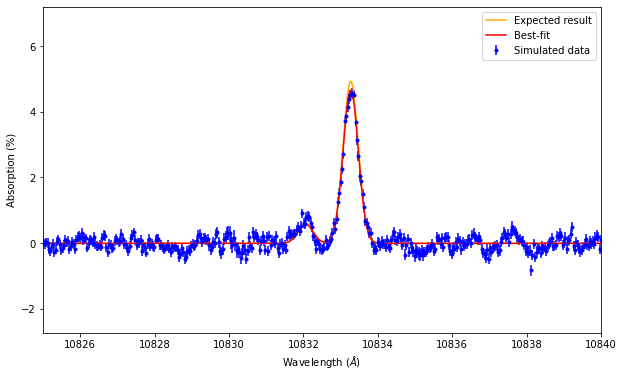

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.29175703e+03 -4.67486530e+14 -1.67086142e-04]


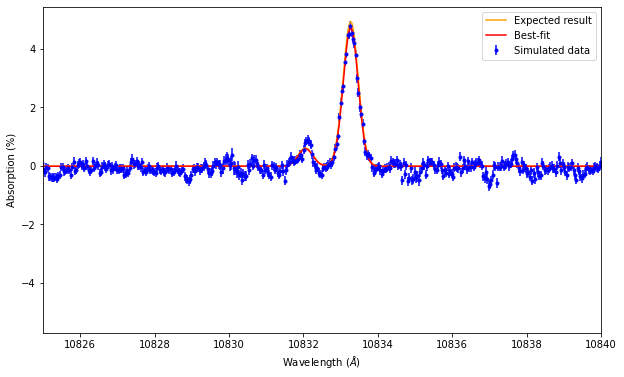

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16935005e+04 -5.12007549e+14 -3.46481837e-04]


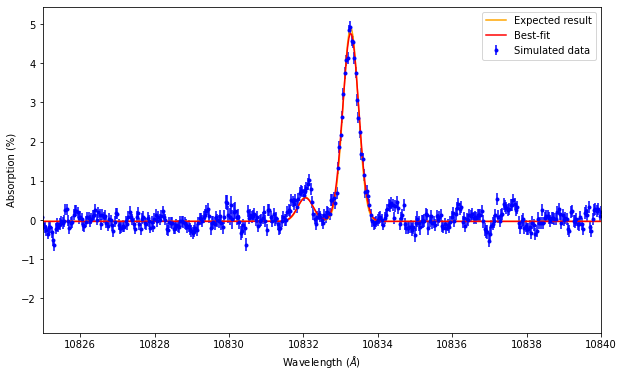

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11006631e+04 -5.16776864e+14  8.73102023e-05]


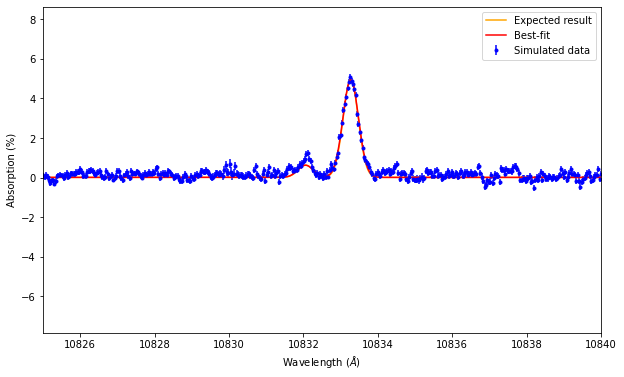

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.90234108e+03 -4.79176096e+14 -2.48275741e-04]


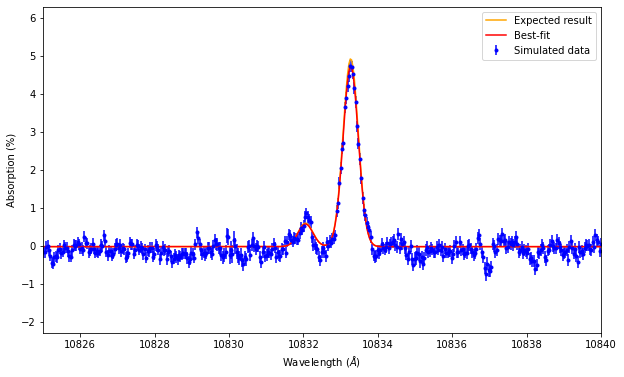

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.16532575e+03 -4.77662451e+14  1.77632791e-05]


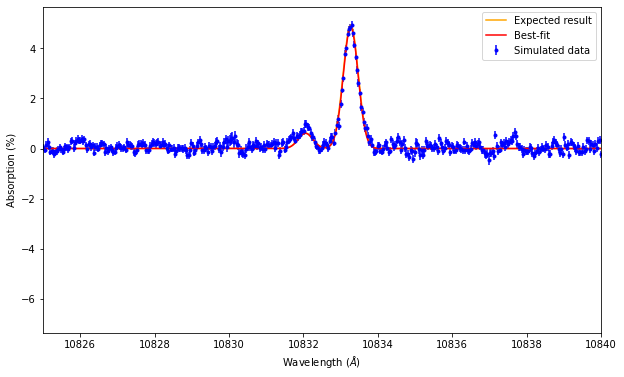

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14706099e+04 -5.11471584e+14  1.11790607e-04]


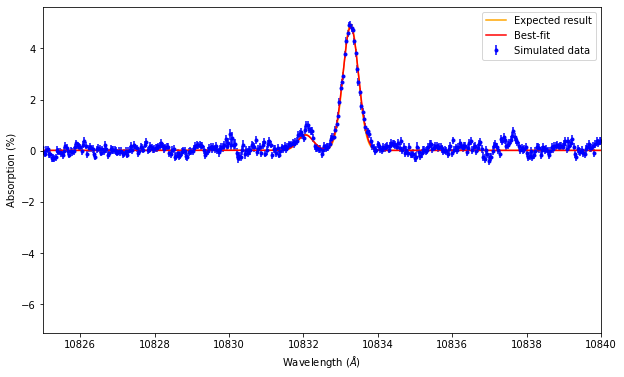

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11517303e+04 -4.95597120e+14 -2.00894863e-04]


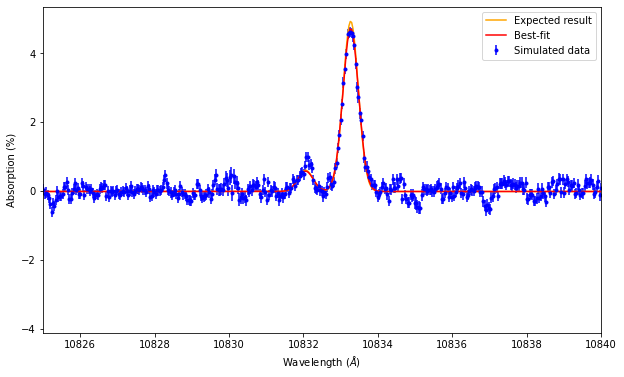

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10684680e+04 -4.97233417e+14 -2.60394083e-04]


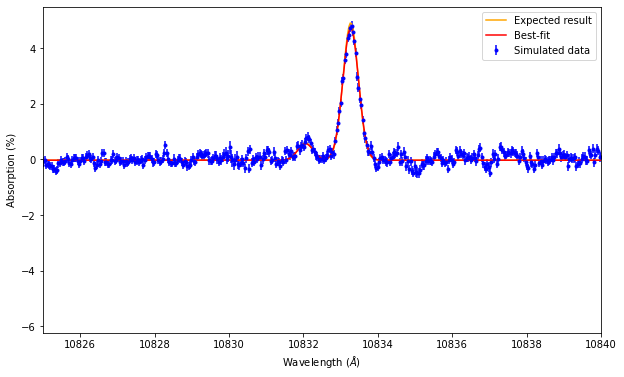

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.89533020e+03 -4.69485286e+14 -2.60130619e-04]


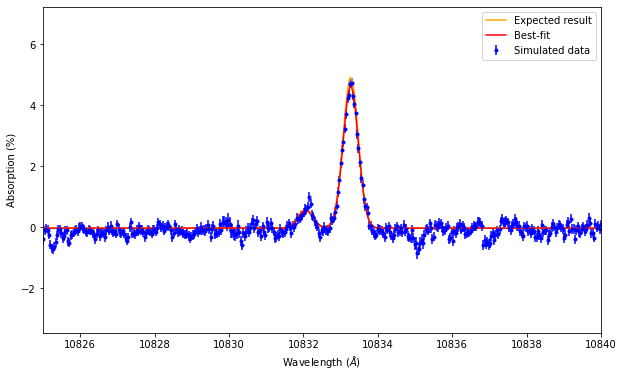

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09448314e+04 -4.84749512e+14 -3.15030163e-04]


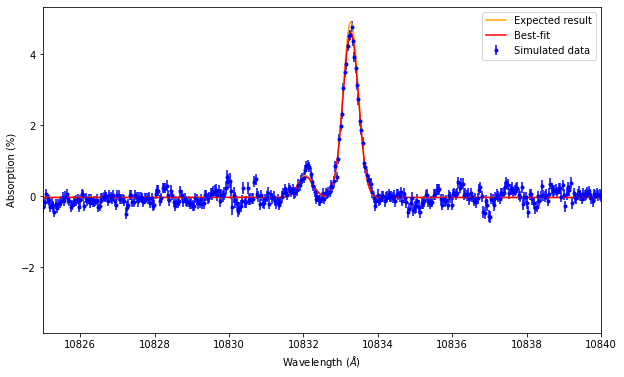

[ 1.25538527e+04 -5.05582695e+14  1.56886448e-04]


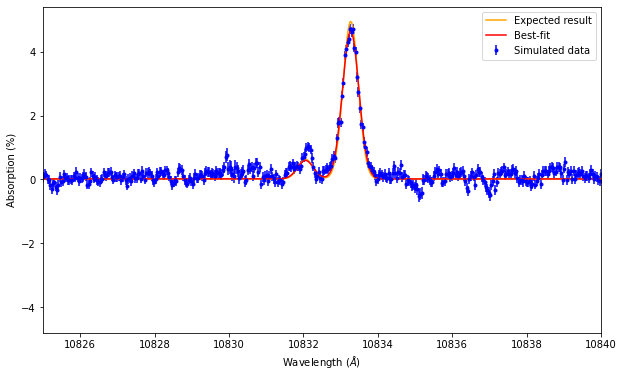

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00637582e+04 -4.86852751e+14 -2.46693149e-04]


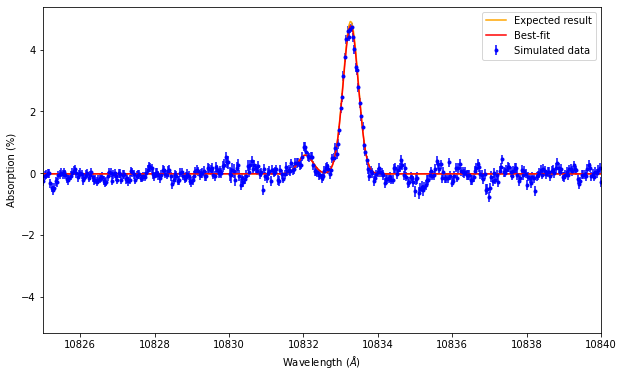

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04142082e+04 -4.92101973e+14 -1.94811830e-04]


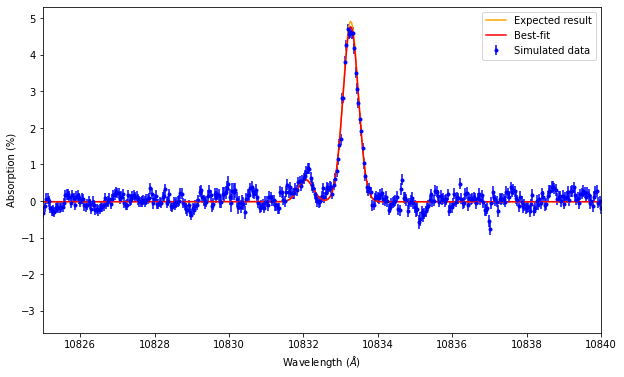

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05517956e+04 -4.92984566e+14 -2.61248359e-04]


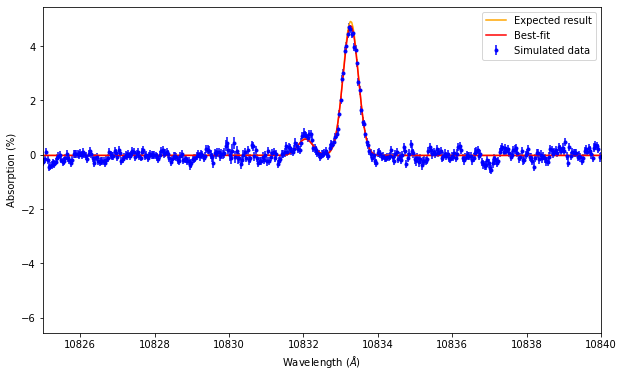

[ 1.24949386e+04 -5.28551262e+14 -9.92461464e-05]


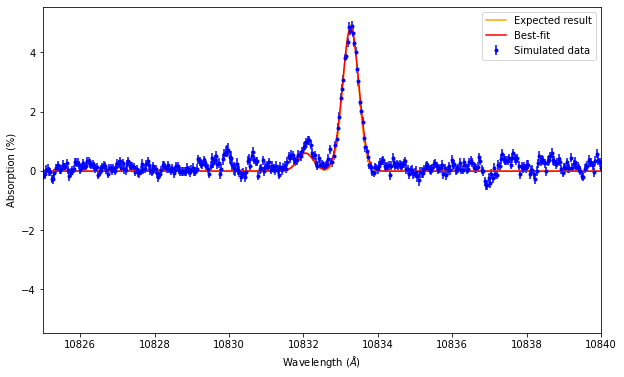

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13248828e+04 -5.06744320e+14 -2.24436466e-04]


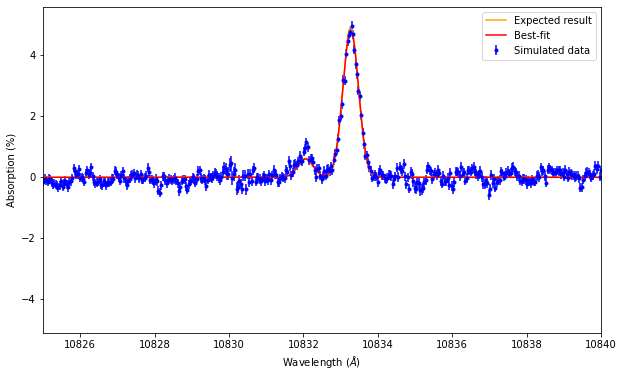

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08364225e+04 -4.98157940e+14 -2.19291950e-04]


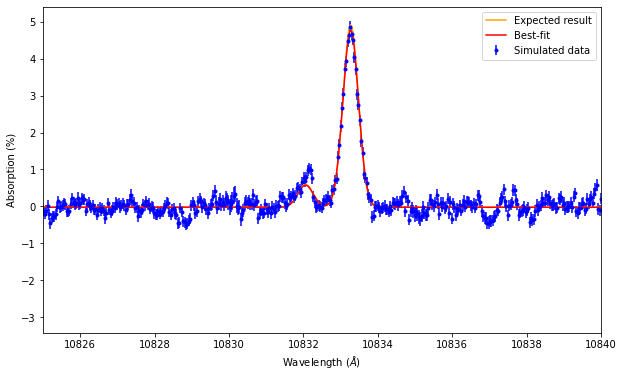

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.26402151e+03 -4.87675777e+14 -1.57867196e-04]


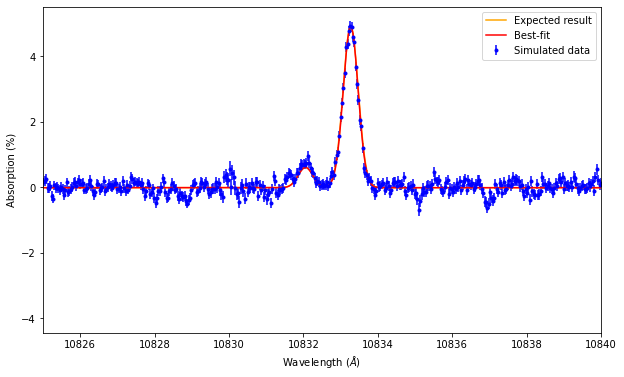

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06325685e+04 -5.09721346e+14  2.18355813e-05]


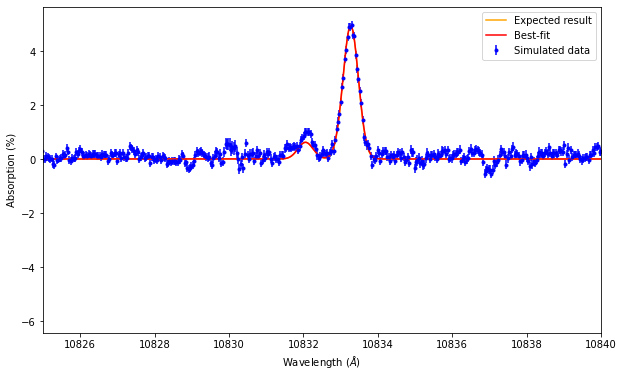

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04251336e+04 -4.96170980e+14 -3.12463922e-05]


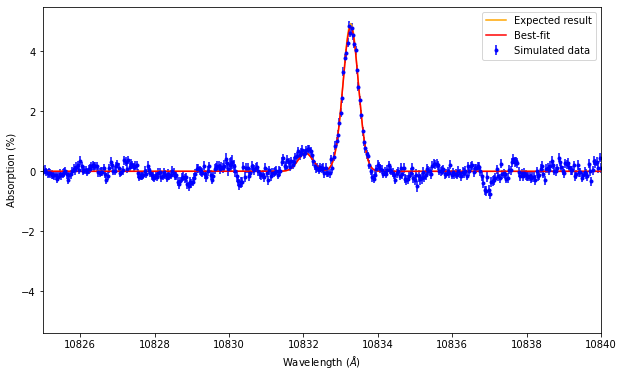

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.70331655e+03 -4.97193867e+14  1.15894229e-04]


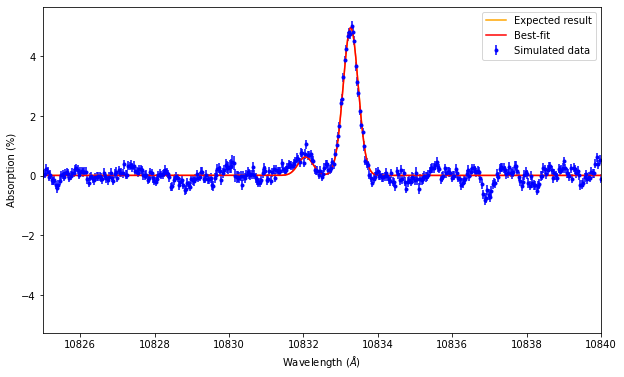

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.90760494e+03 -5.01969042e+14 -1.87961758e-04]


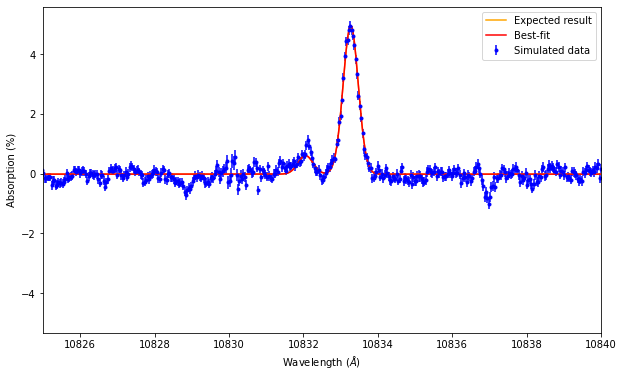

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02458832e+04 -4.98022904e+14 -1.10544248e-04]


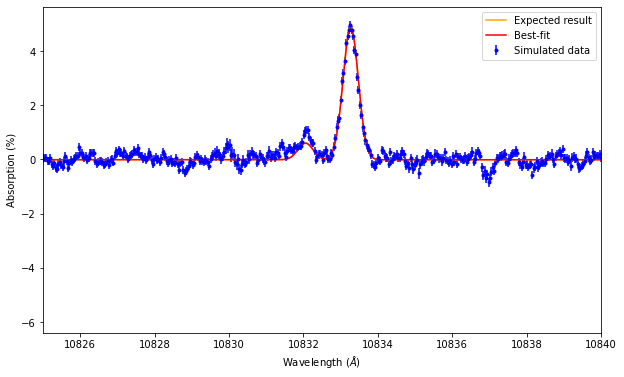

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15509431e+04 -5.07310546e+14 -2.51165928e-04]


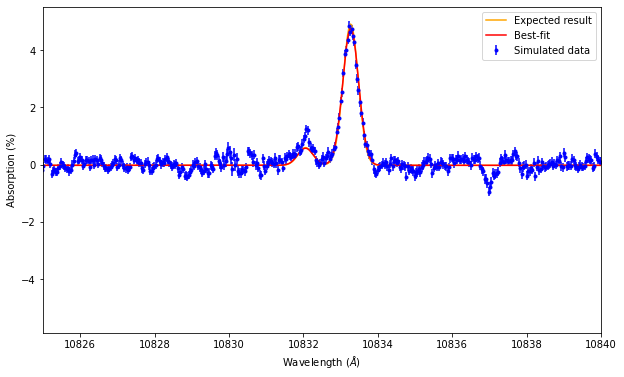

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14106498e+04 -5.04669291e+14 -6.23337511e-05]


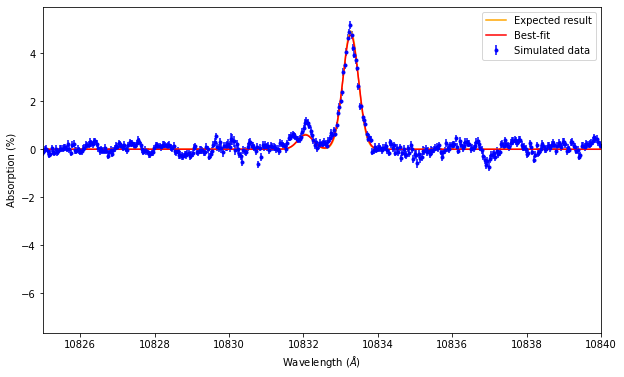

[ 1.35456896e+04 -5.39799329e+14  2.87712722e-04]


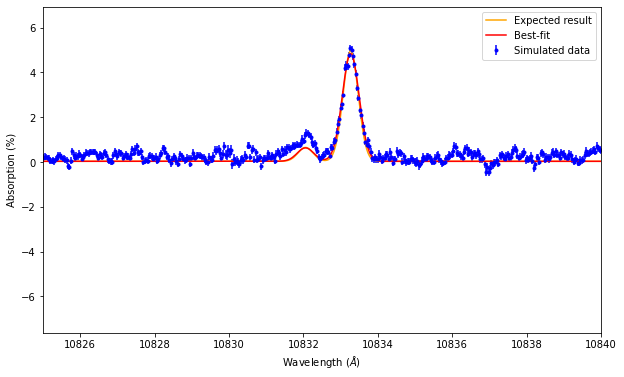

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06724006e+04 -4.79178494e+14 -9.24372888e-05]


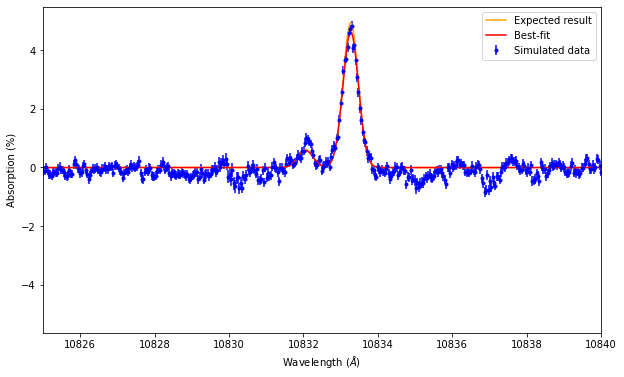

[ 1.31271220e+04 -5.34243052e+14  5.80832016e-05]


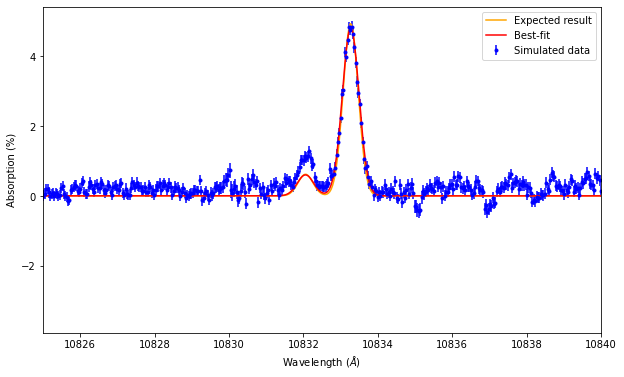

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00938789e+04 -4.77450880e+14 -2.96836598e-04]


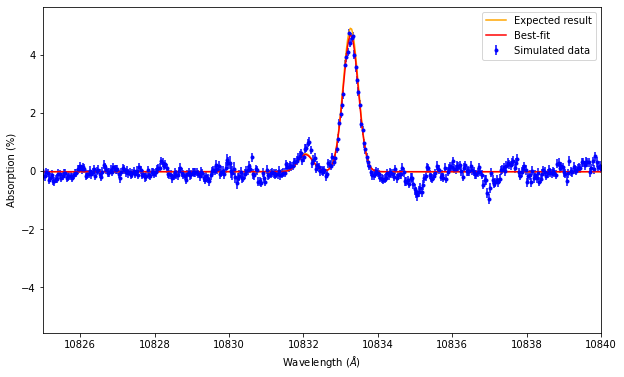

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15925762e+04 -5.10416710e+14 -1.38190439e-05]


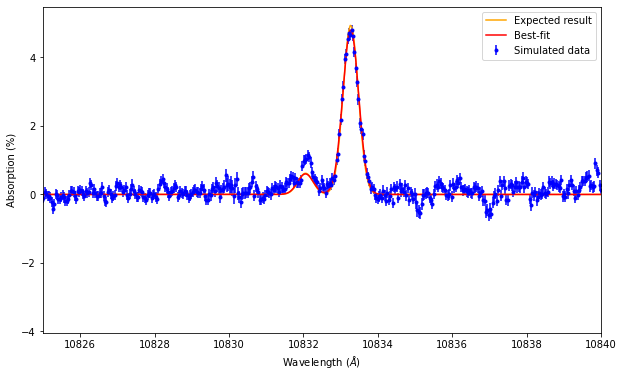

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05452948e+04 -4.99261909e+14  1.56415295e-04]


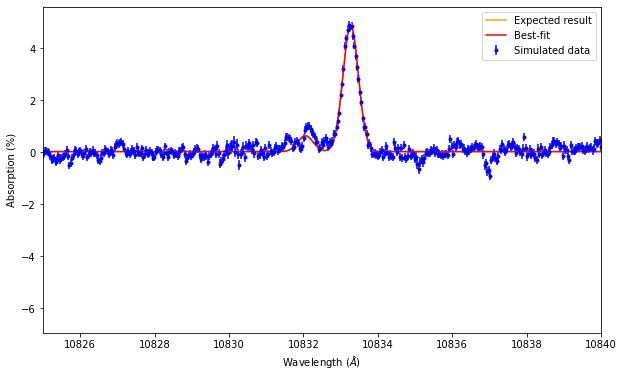

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08809866e+04 -5.15069419e+14 -1.59191830e-04]


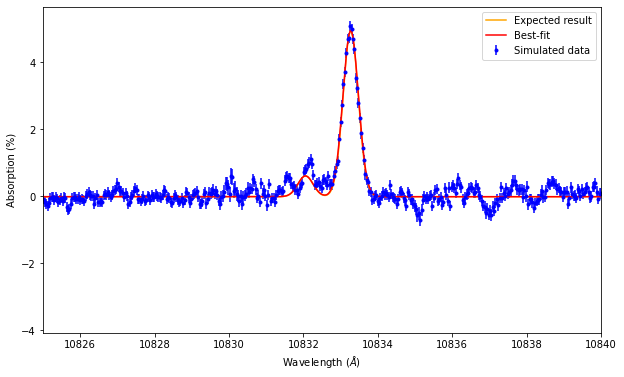

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10379219e+04 -5.15775011e+14 -5.32599653e-05]


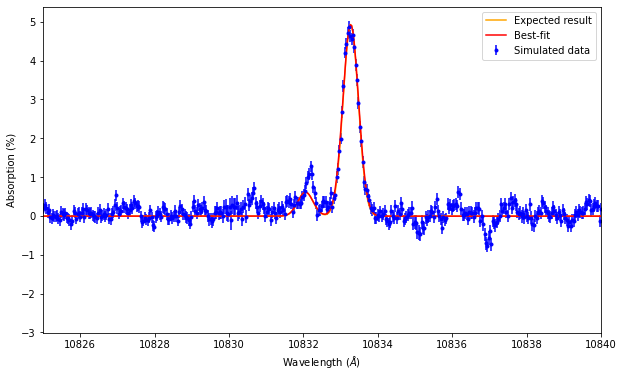

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.34329406e+03 -4.92491244e+14 -4.63192840e-05]


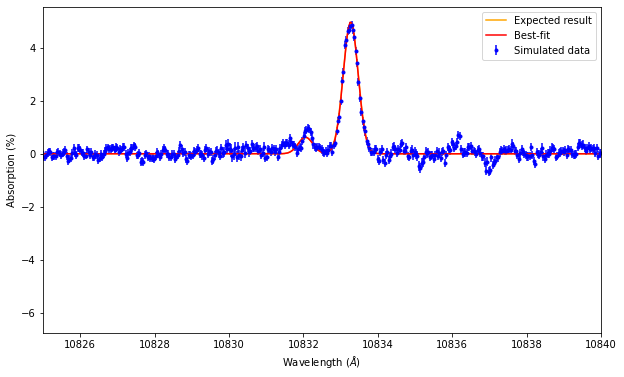

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.29104763e+03 -4.71777410e+14 -2.00493906e-04]


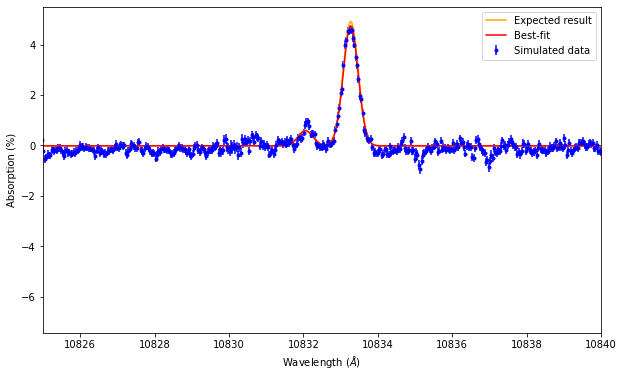

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.94509828e+03 -4.84042835e+14  1.17448527e-04]


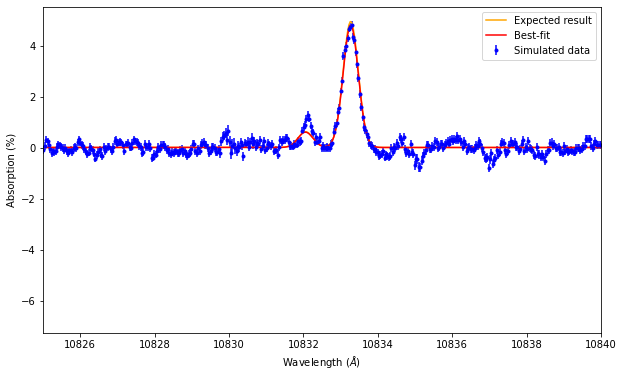

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.99354190e+03 -4.80192991e+14 -5.94869580e-05]


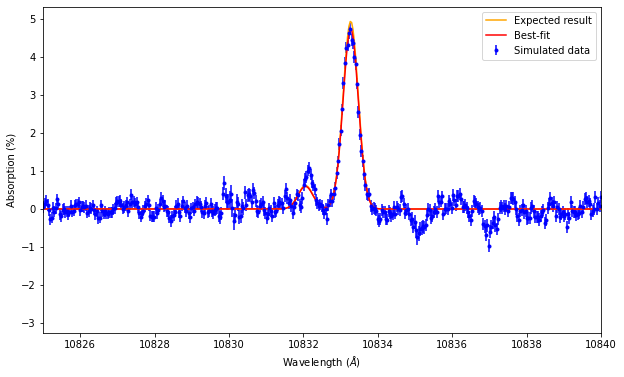

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.78057668e+03 -4.66985108e+14 -7.84947424e-05]


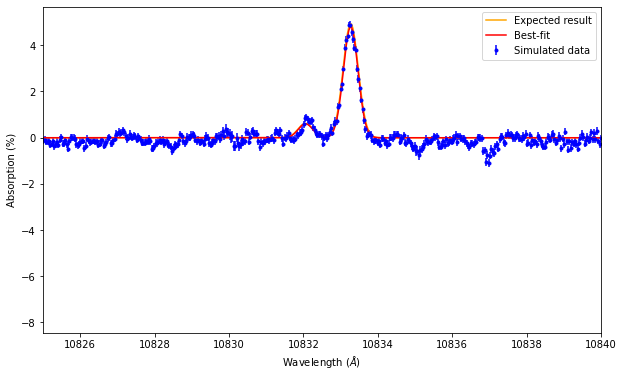

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03988757e+04 -4.84246489e+14  2.52682843e-05]


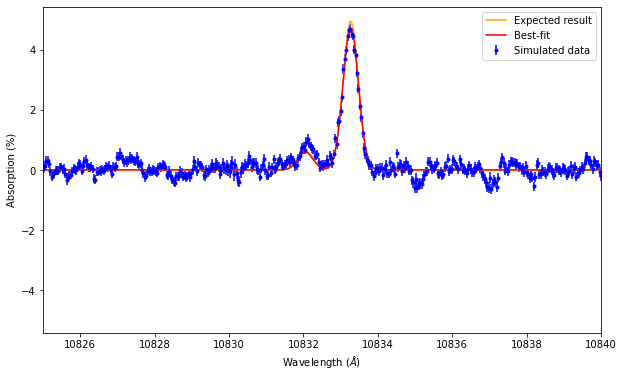

[ 1.25072560e+04 -5.15803331e+14 -1.33413542e-04]


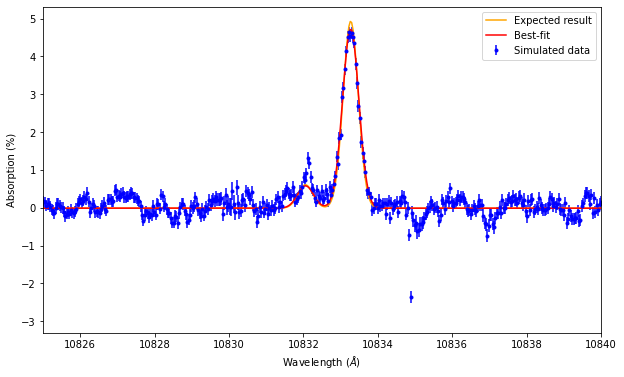

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09227999e+04 -4.77824793e+14 -1.47861407e-04]


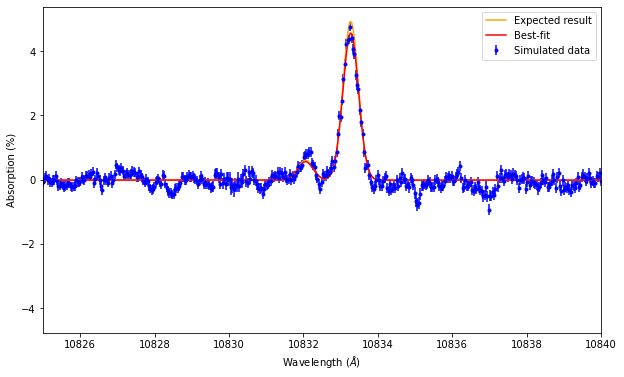

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04390617e+04 -4.92508479e+14  3.50114120e-04]


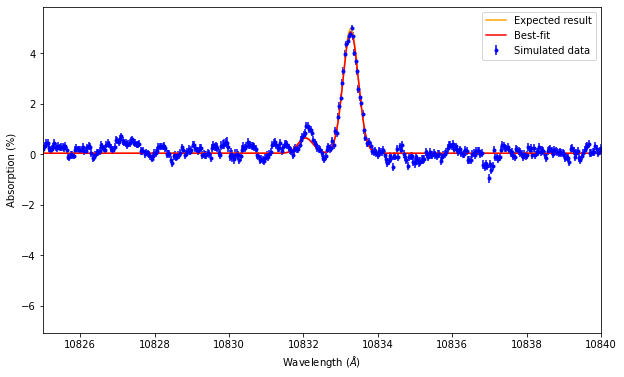

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11402155e+04 -4.95978405e+14 -1.02874989e-04]


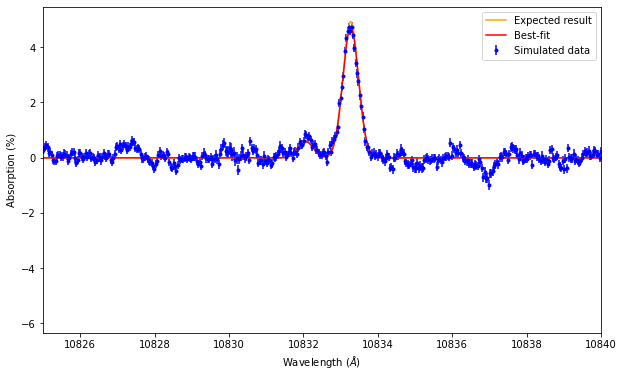

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01657020e+04 -4.80561337e+14  3.85037033e-06]


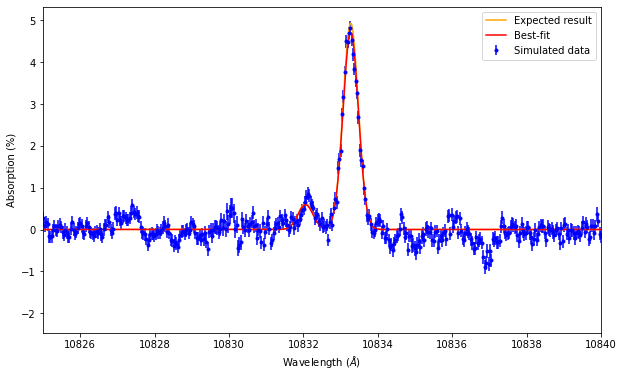

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07787755e+04 -5.01008773e+14  6.66458011e-05]


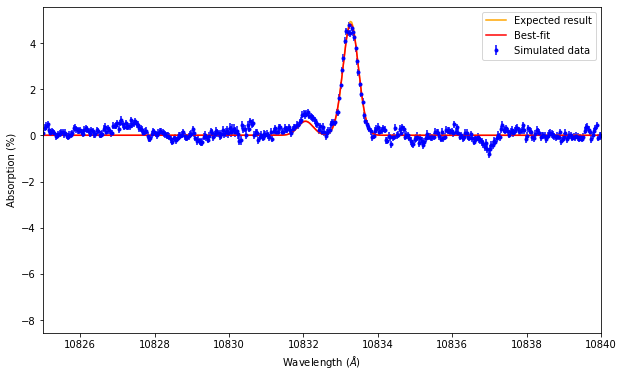

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12226753e+04 -5.05909952e+14 -5.56162123e-05]


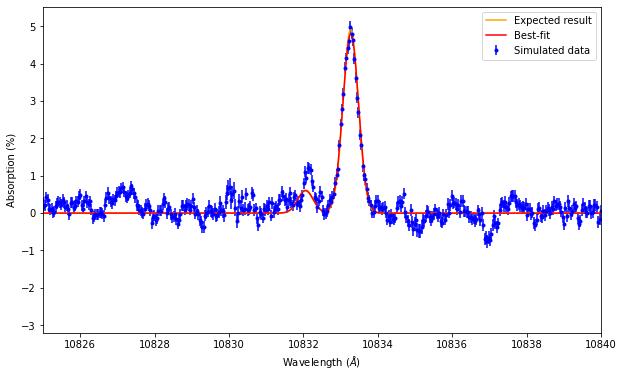

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.40598837e+03 -4.77357961e+14 -1.42001365e-04]


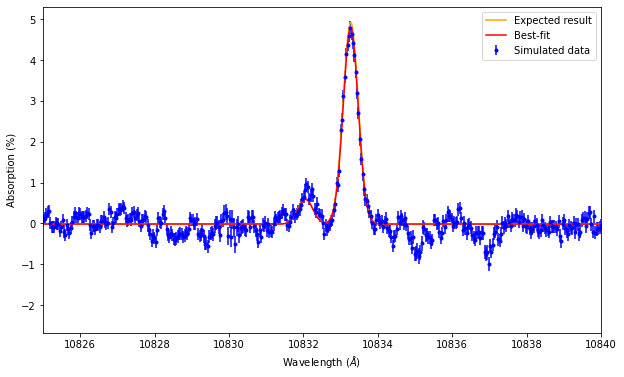

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.56626558e+03 -4.88275366e+14  6.09784479e-06]


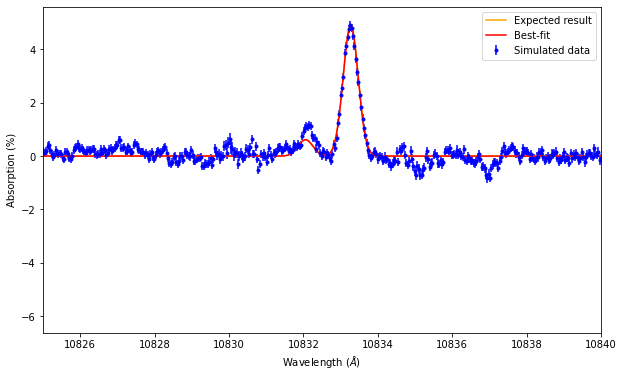

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.32225380e+03 -4.52443733e+14 -1.00383315e-04]


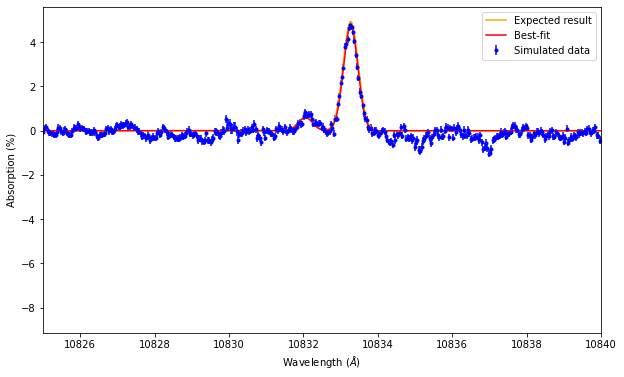

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11084714e+04 -5.00251336e+14  1.06070069e-04]


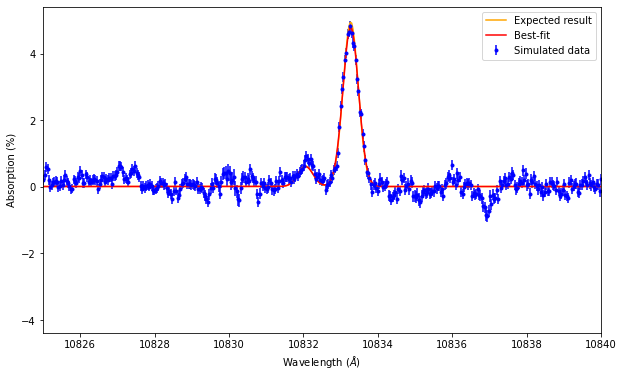

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06340312e+04 -4.80346834e+14 -9.48083769e-05]


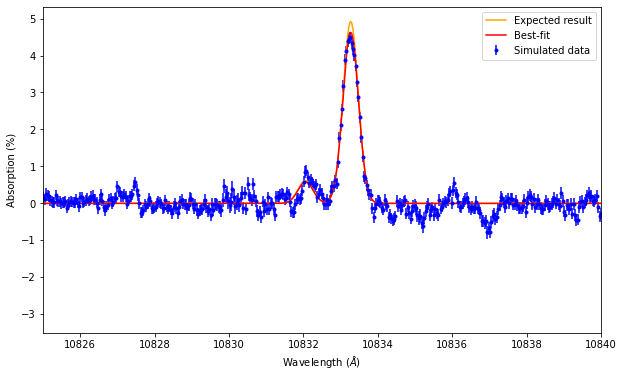

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.59475690e+03 -4.49602672e+14 -1.60578033e-04]


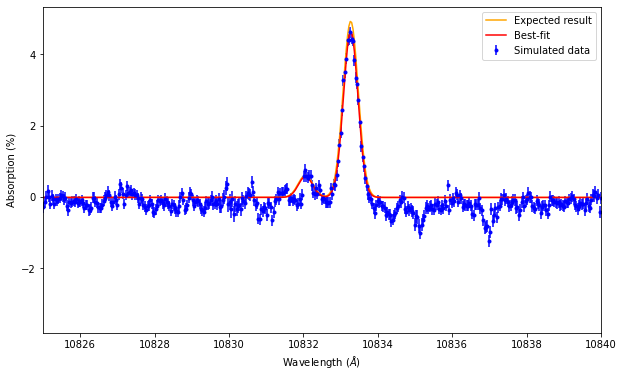

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.79410522e+03 -4.71637255e+14 -1.27537735e-04]


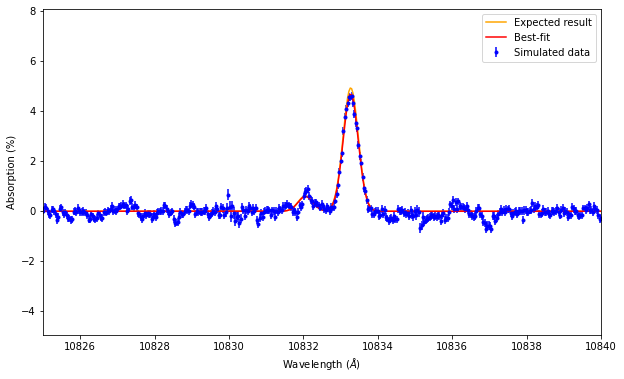

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.68380443e+03 -4.63206634e+14 -1.09264882e-04]


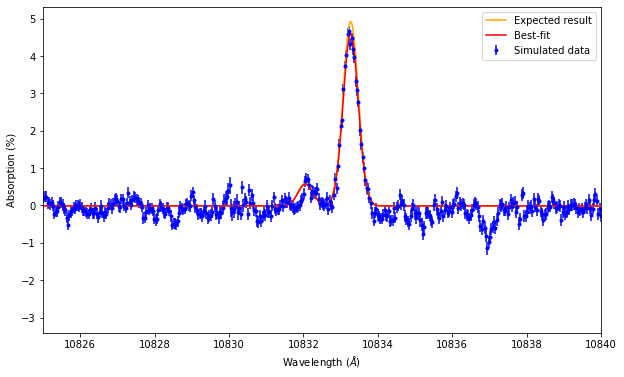

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08231810e+04 -4.94985513e+14 -1.15108342e-04]


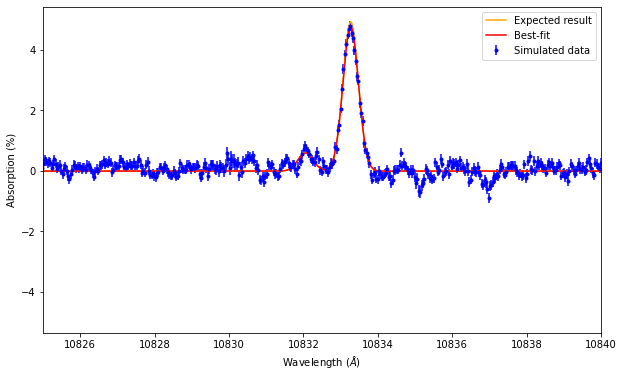

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00146917e+04 -4.93801989e+14 -9.74725649e-05]


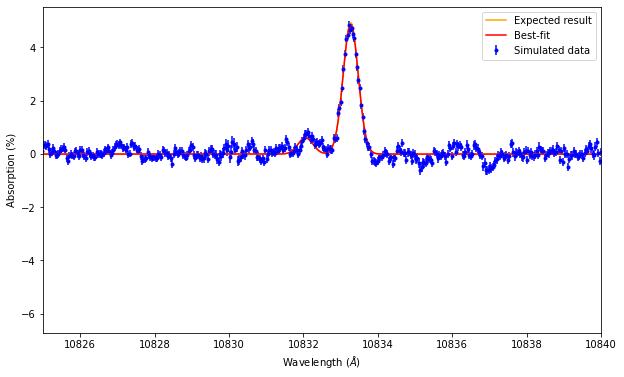

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12145878e+04 -4.91198138e+14 -1.22342198e-04]


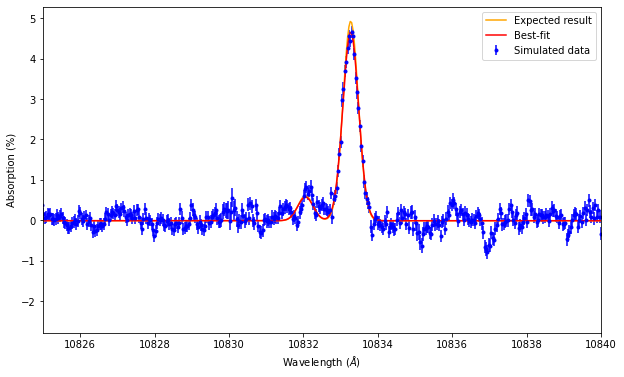

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.53609084e+03 -4.68667109e+14  7.07859587e-05]


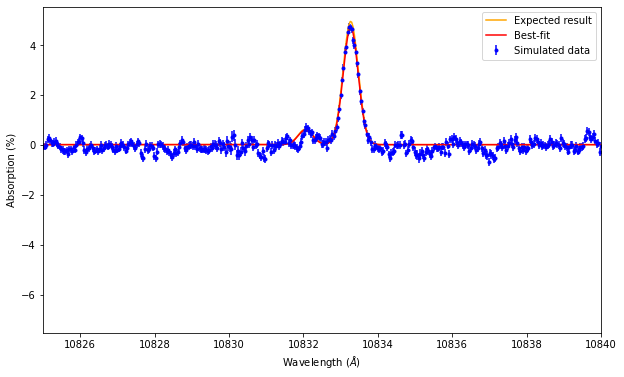

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06847392e+04 -4.84134864e+14 -9.85096621e-06]


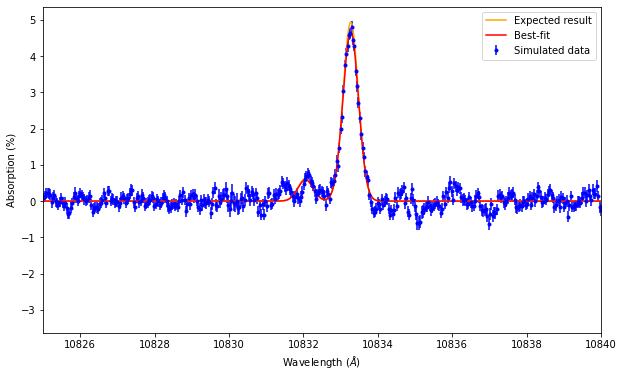

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.75739267e+03 -4.80423432e+14 -2.96311151e-04]


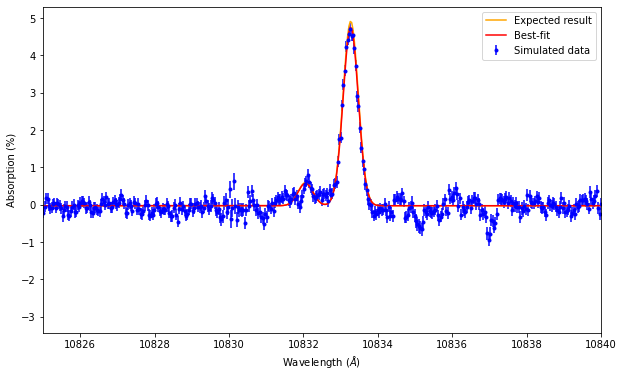

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.78989600e+03 -4.84422002e+14  6.09900972e-05]


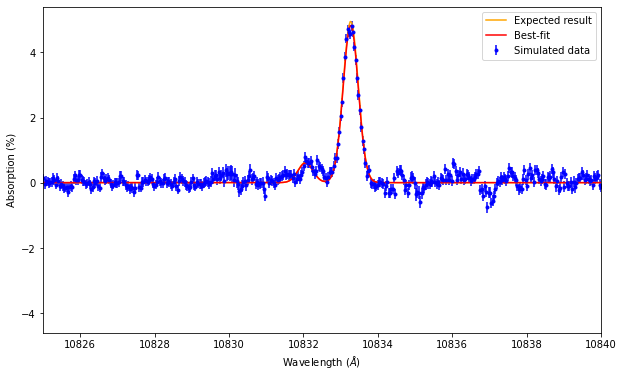

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02181800e+04 -4.80925540e+14 -6.12115152e-05]


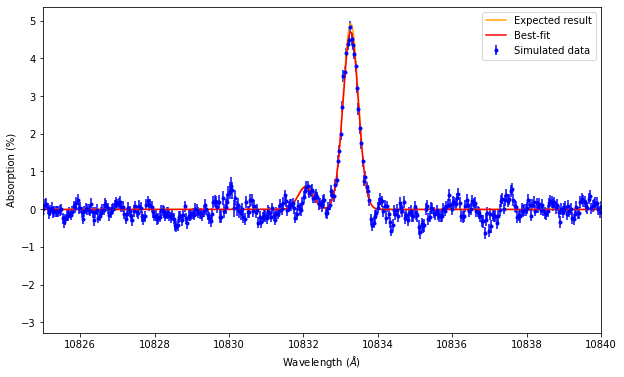

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.80076810e+03 -4.64365860e+14 -2.78354517e-04]


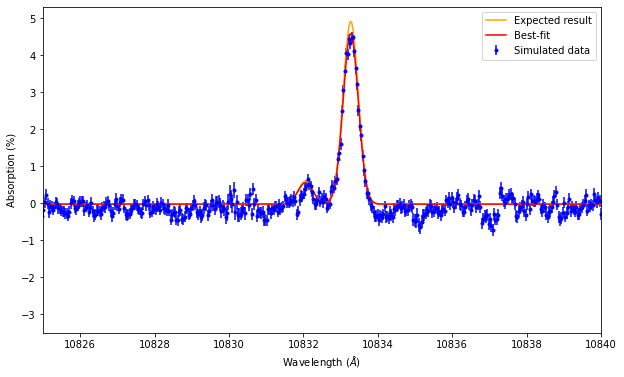

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10267154e+04 -4.83503555e+14 -5.14399168e-05]


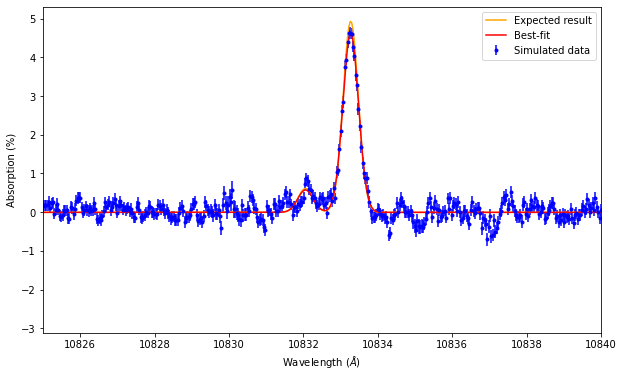

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.55664019e+03 -4.61415555e+14 -2.16828728e-05]


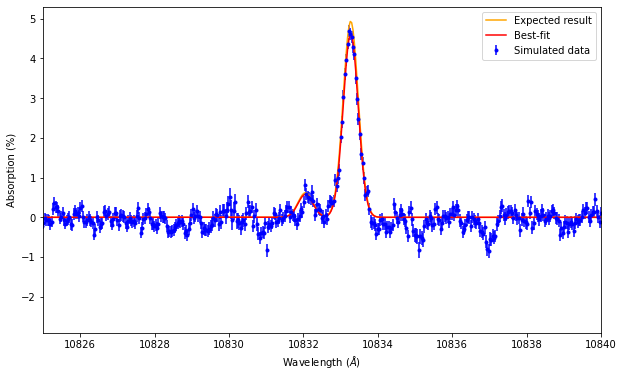

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16794993e+04 -4.99036203e+14 -1.16863246e-04]


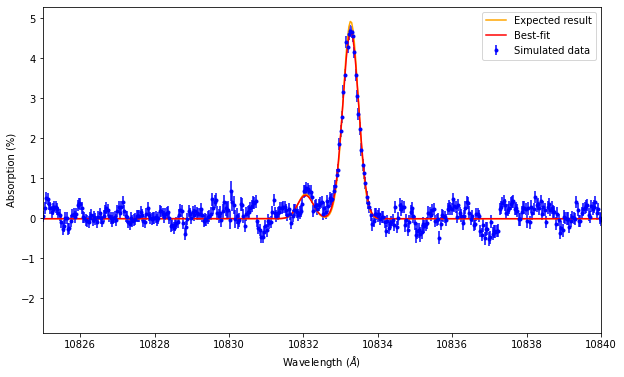

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.21173060e+03 -4.59362914e+14  6.13164954e-05]


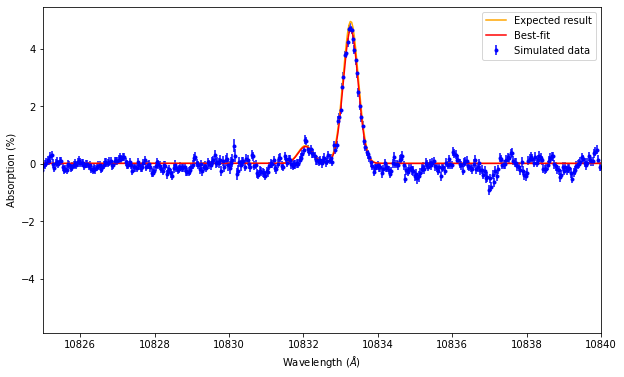

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.99401591e+03 -4.72669786e+14 -1.91530035e-04]


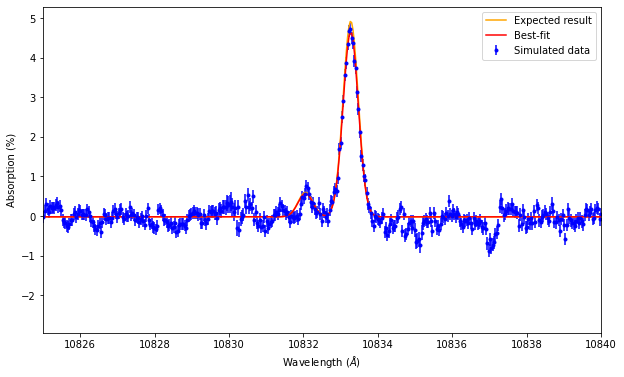

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.70351783e+03 -4.58535839e+14 -1.02024718e-04]


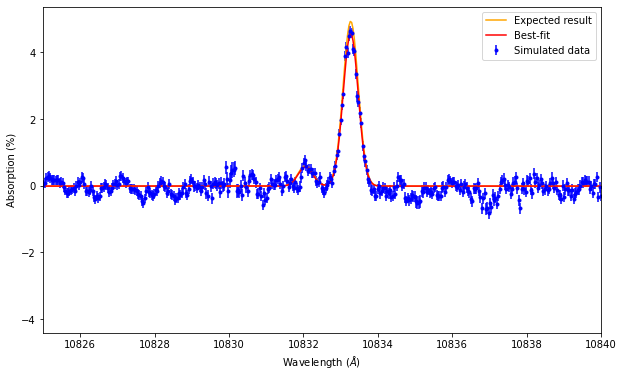

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12993143e+04 -4.99644189e+14  1.41310558e-04]


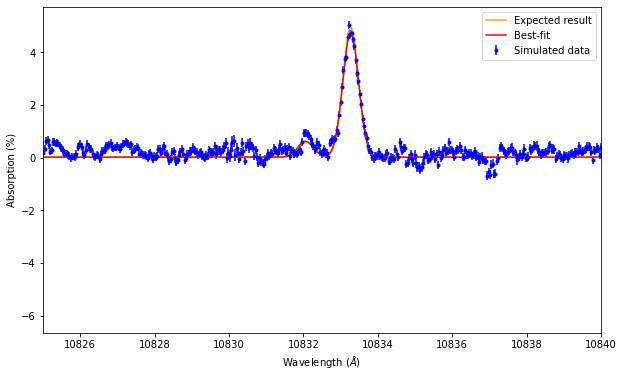

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.42355506e+03 -4.62370957e+14  7.63286367e-05]


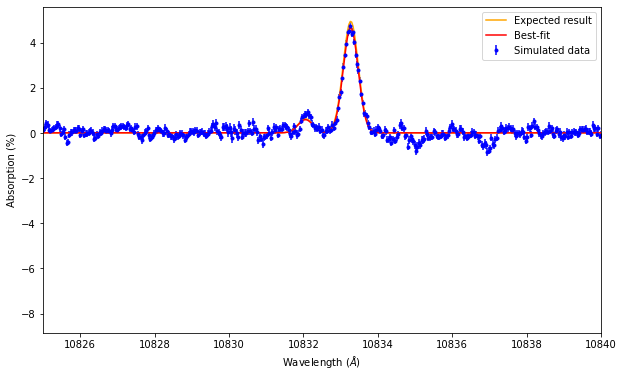

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04356537e+04 -4.80131889e+14 -1.65524435e-04]


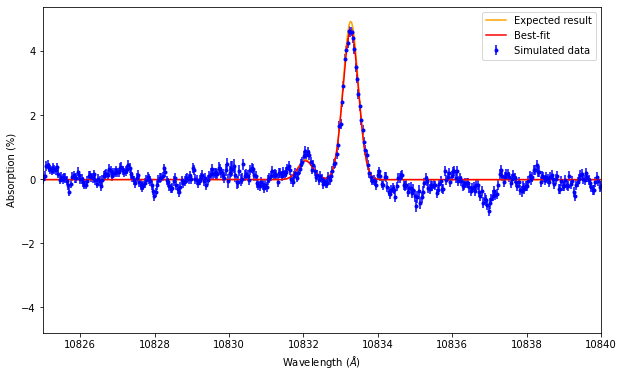

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17969579e+04 -5.04886331e+14 -8.49655025e-05]


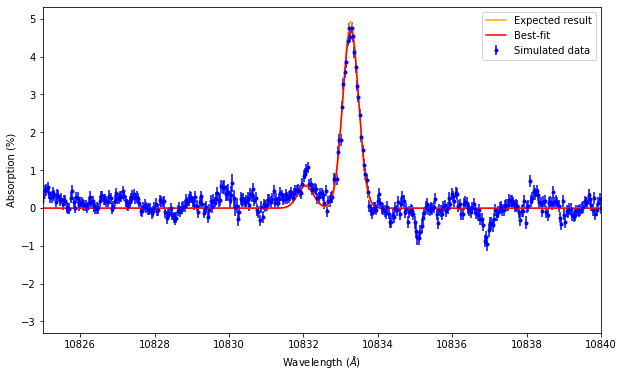

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00257426e+04 -4.68221195e+14  2.63302222e-05]


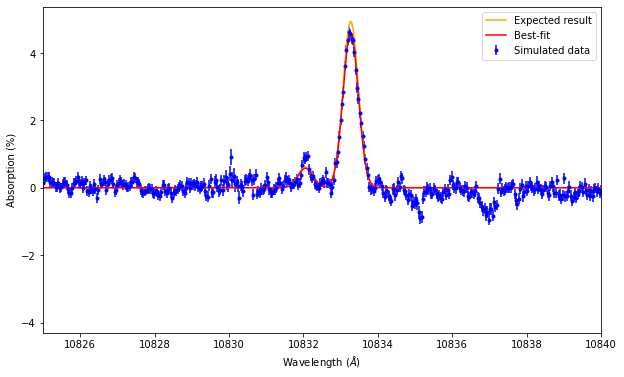

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.48895019e+03 -4.44938397e+14  1.38297948e-05]


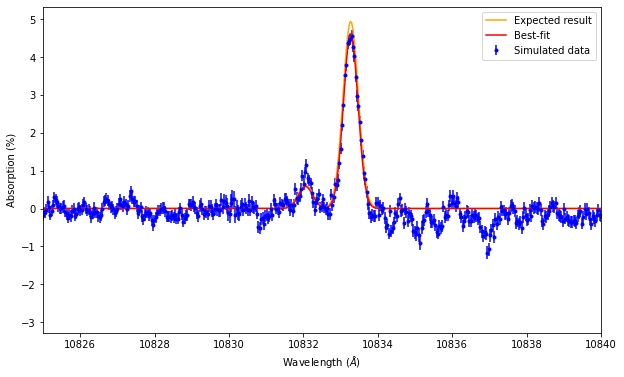

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08290936e+04 -5.00319432e+14 -2.53306161e-04]


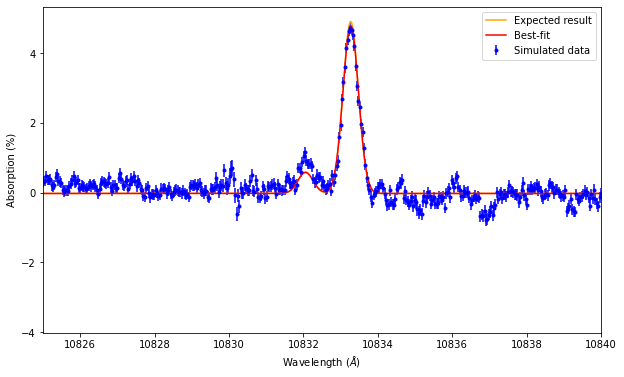

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02647443e+04 -4.90206071e+14 -1.88075117e-04]


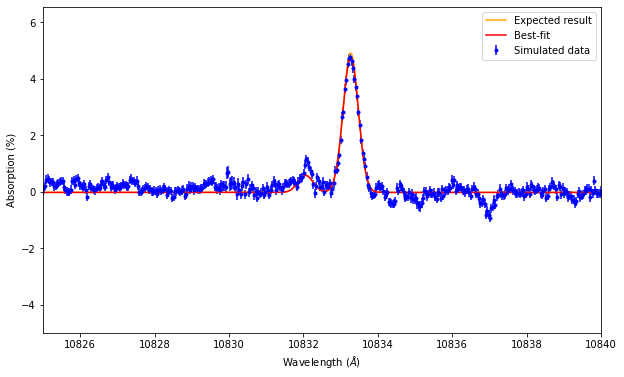

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13326848e+04 -5.09245134e+14 -4.38020210e-04]


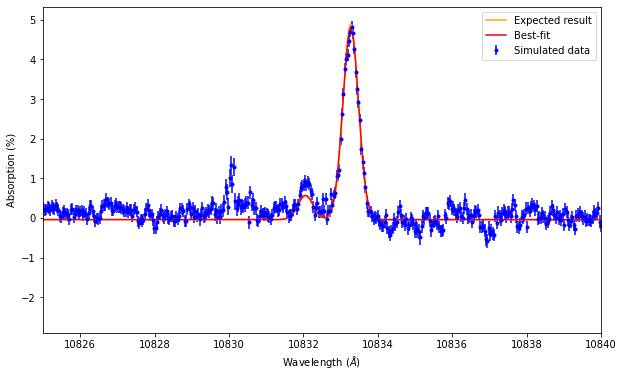

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11921421e+04 -4.84744254e+14 -3.25162396e-04]


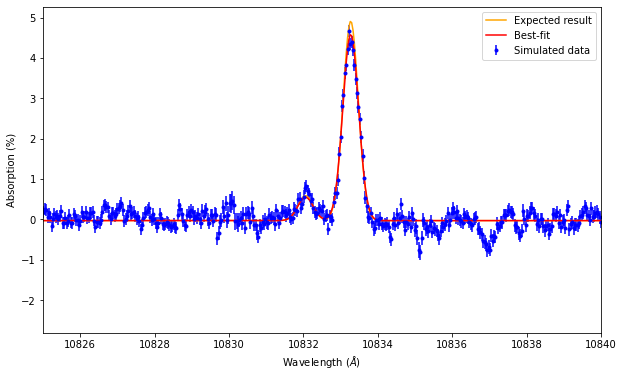

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03948935e+04 -4.78962163e+14  2.62682191e-05]


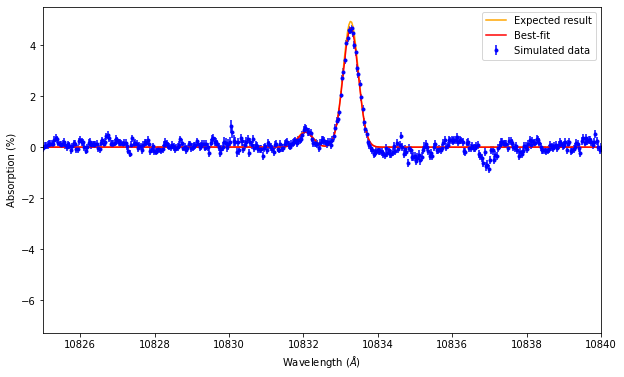

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04775673e+04 -4.93503722e+14 -2.45359211e-04]


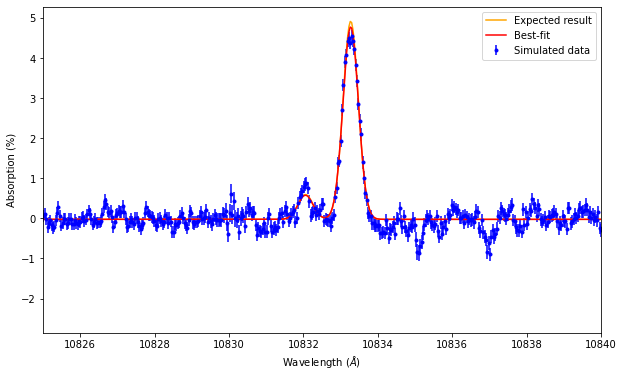

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09234257e+04 -5.01338216e+14 -4.10337312e-05]


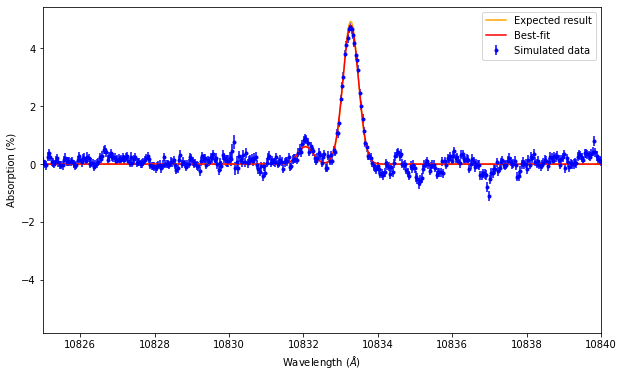

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01927722e+04 -4.89118347e+14 -1.03565769e-04]


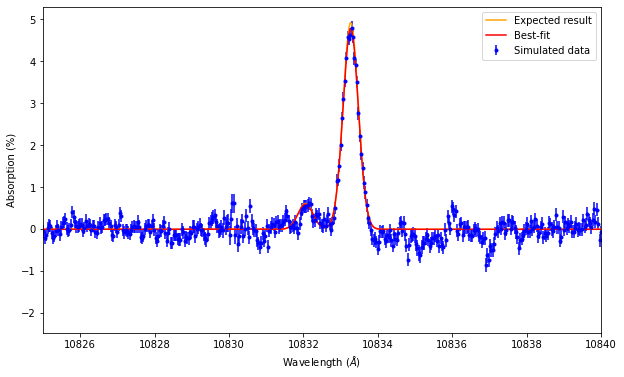

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10317803e+04 -5.10229150e+14 -8.74116391e-05]


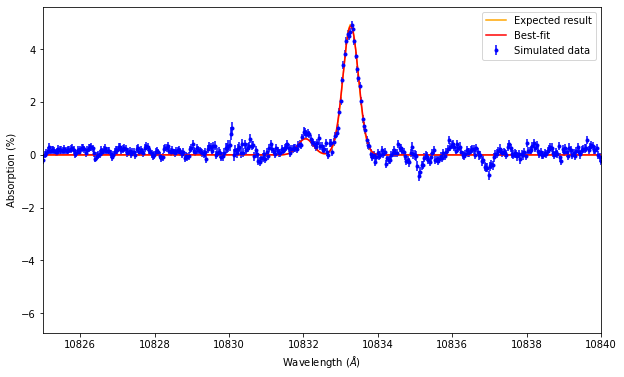

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.92262406e+03 -4.66354414e+14 -1.77525389e-04]


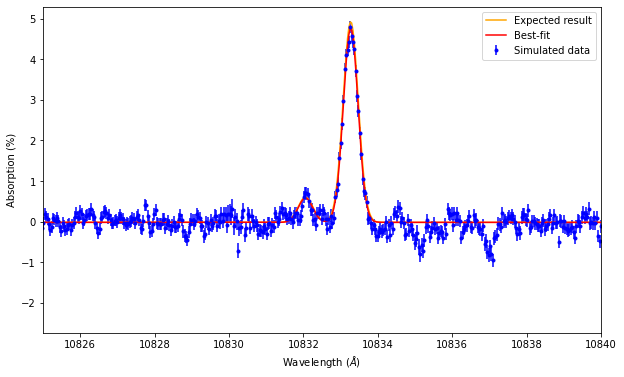

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.78340906e+03 -4.63163457e+14 -1.65841333e-04]


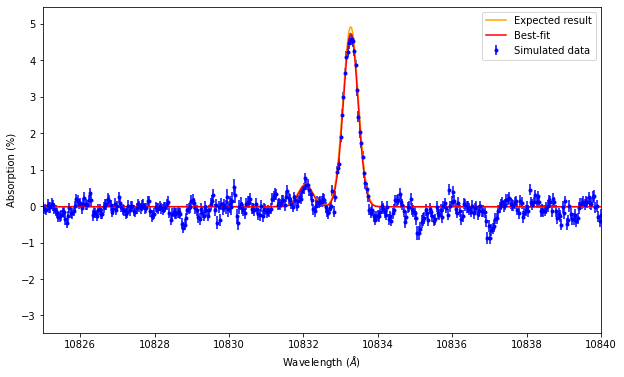

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.18054562e+03 -4.64945029e+14 -1.26135054e-04]


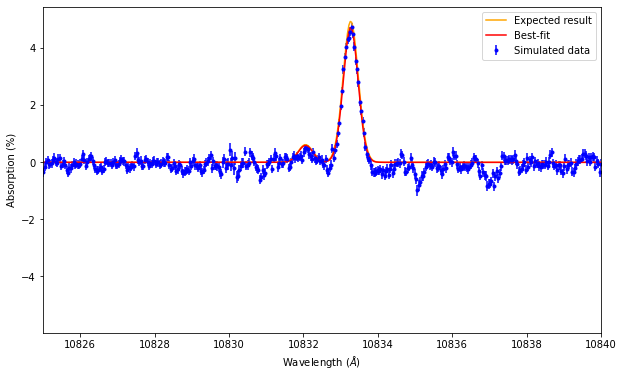

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03110593e+04 -4.90400345e+14 -1.72409179e-04]


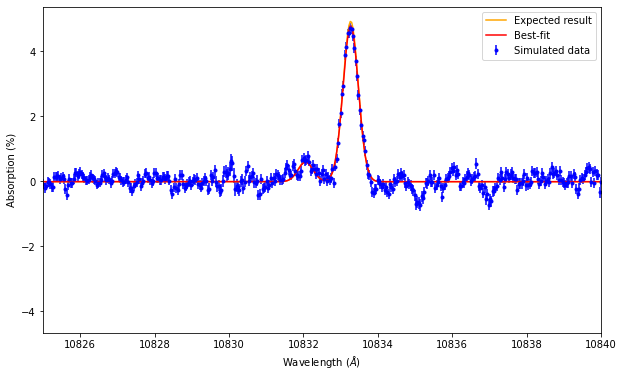

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14309702e+04 -4.91425793e+14 -1.40415808e-04]


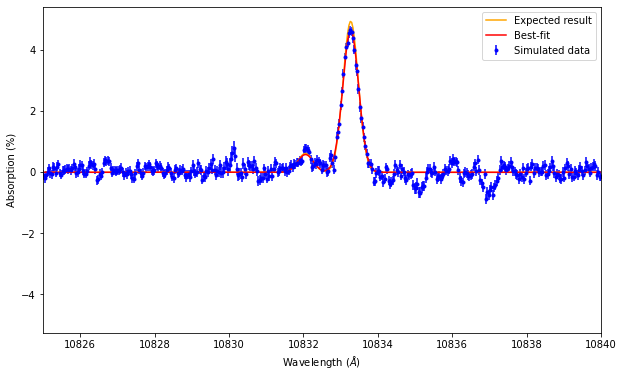

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.75719750e+03 -4.75009477e+14 -1.32613623e-04]


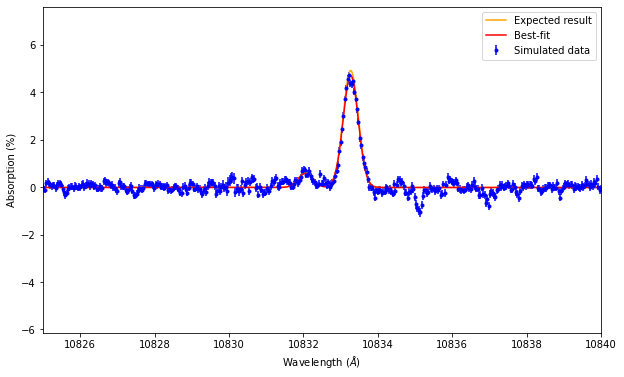

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05483113e+04 -4.89923930e+14 -4.94176756e-05]


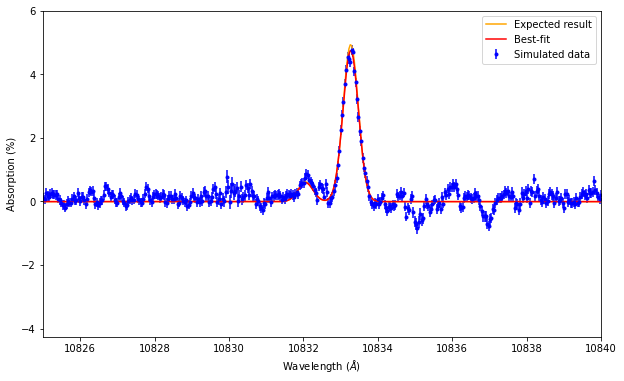

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.68957103e+03 -4.80872101e+14  3.29917838e-05]


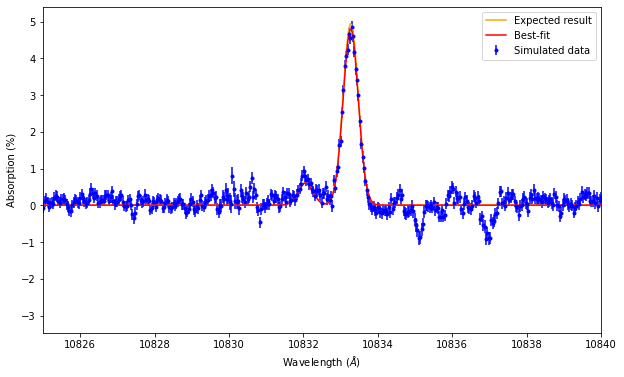

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05765383e+04 -4.87018934e+14 -7.33941712e-05]


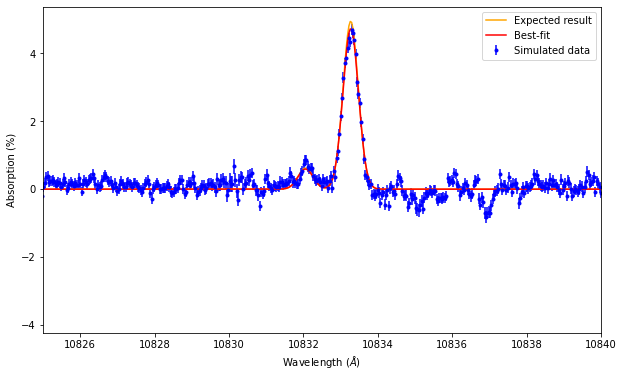

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.70804687e+03 -4.62217134e+14 -7.71839045e-05]


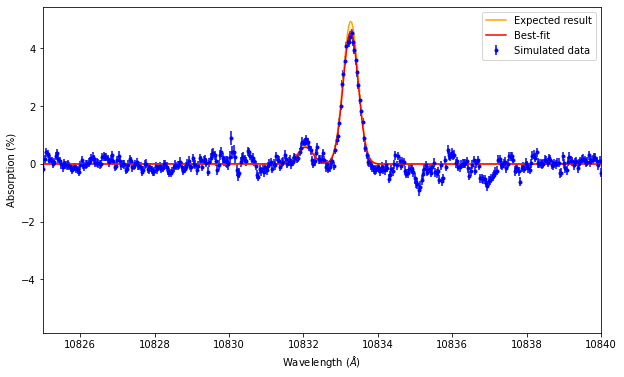

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13087025e+04 -5.05129484e+14  1.07419217e-04]


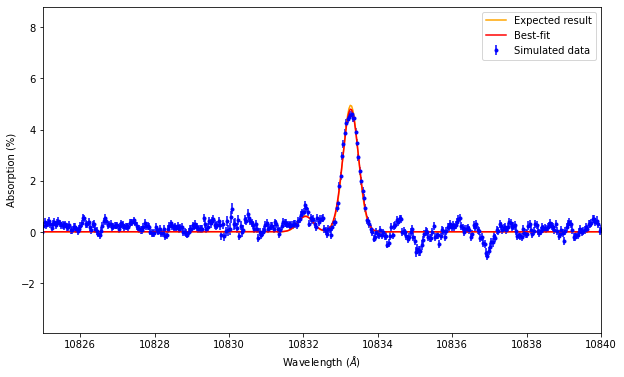

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.75497805e+03 -4.59190161e+14 -3.23729051e-05]


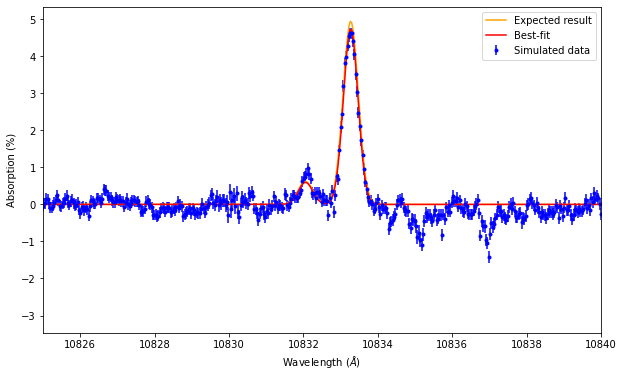

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03934335e+04 -4.85156996e+14 -2.90095439e-05]


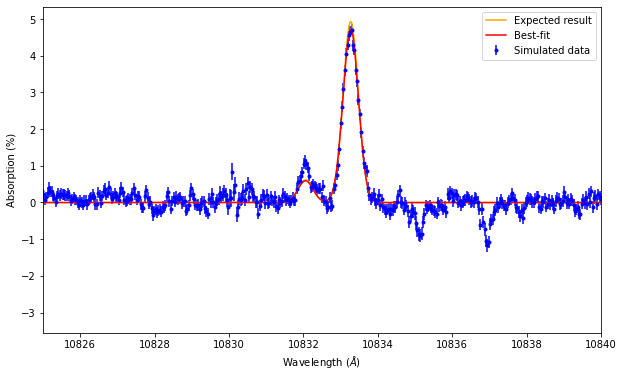

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.51781658e+03 -4.82824533e+14 -5.40625448e-05]


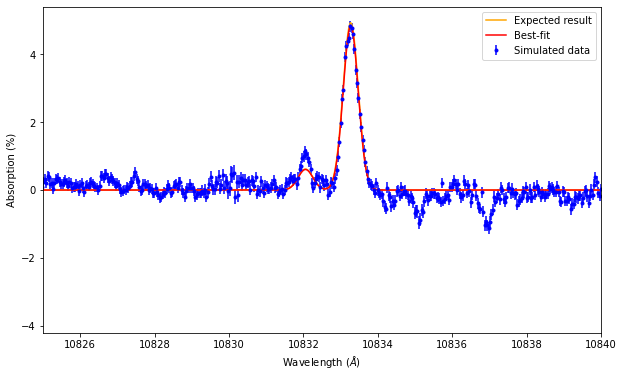

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.71453845e+03 -4.78951270e+14 -7.42615012e-05]


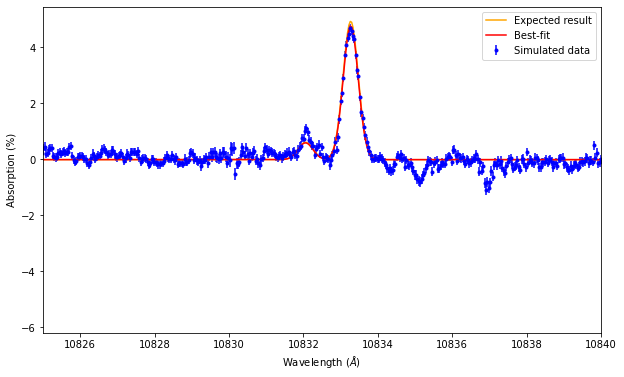

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.78884665e+03 -4.78486468e+14  4.83690192e-05]


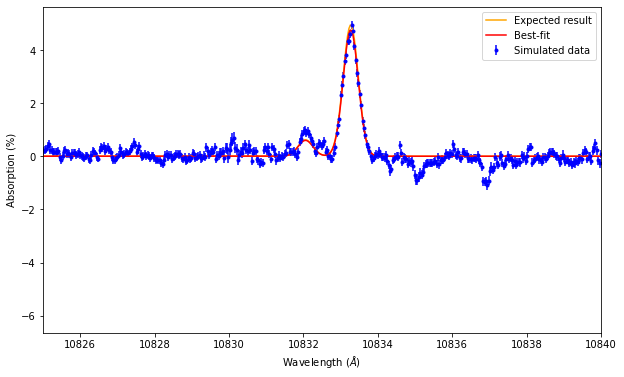

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07616188e+04 -5.01421303e+14  7.29512834e-06]


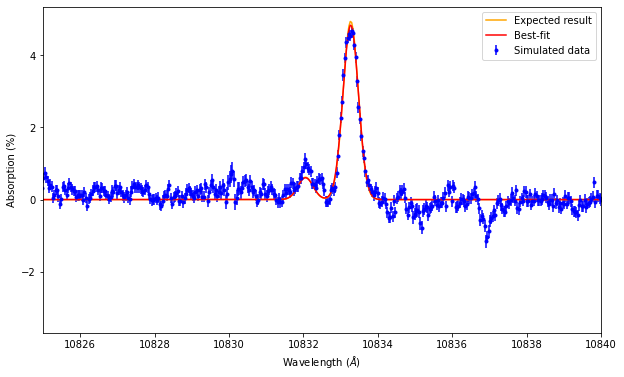

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.42971870e+03 -4.37825079e+14 -2.80142684e-04]


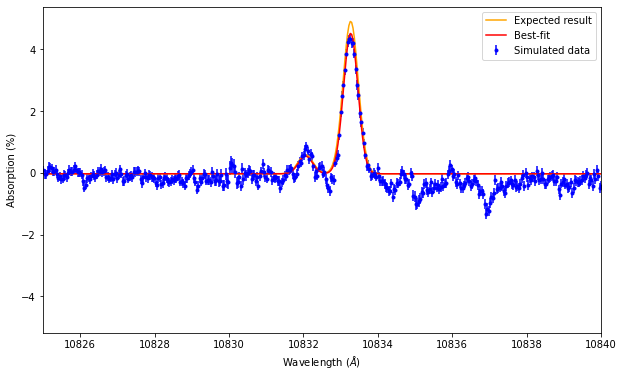

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.72470931e+03 -4.62207583e+14 -1.38695484e-04]


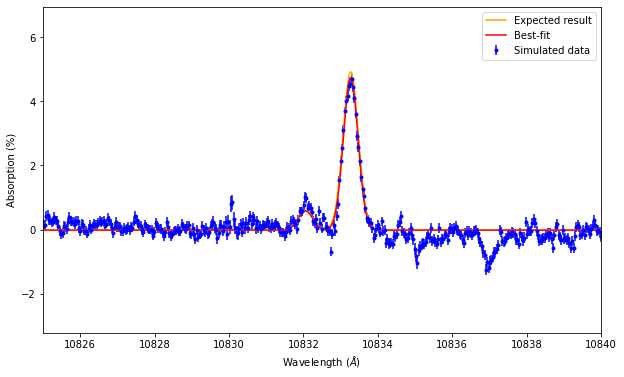

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.27931369e+03 -4.65951583e+14 -1.86338880e-04]


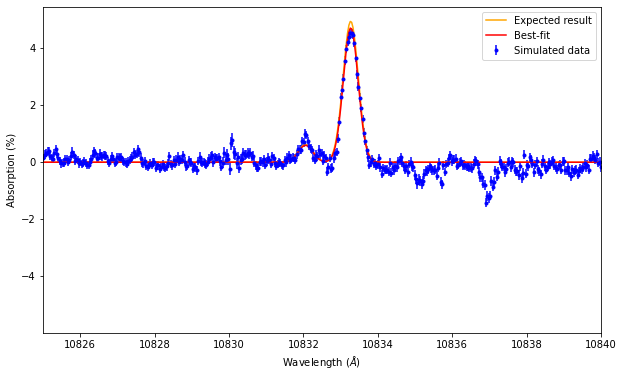

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.65329570e+03 -4.74008145e+14 -2.25454277e-04]


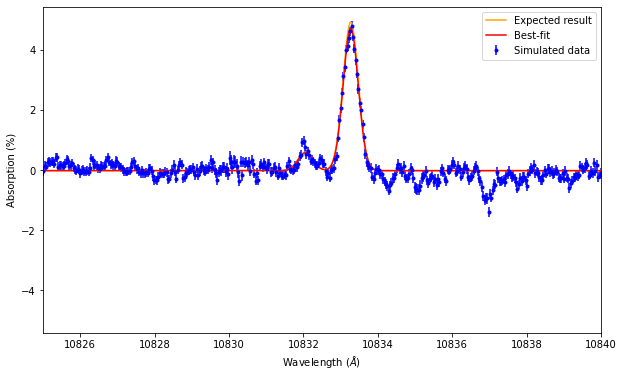

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01337487e+04 -4.83167354e+14  1.50159566e-04]


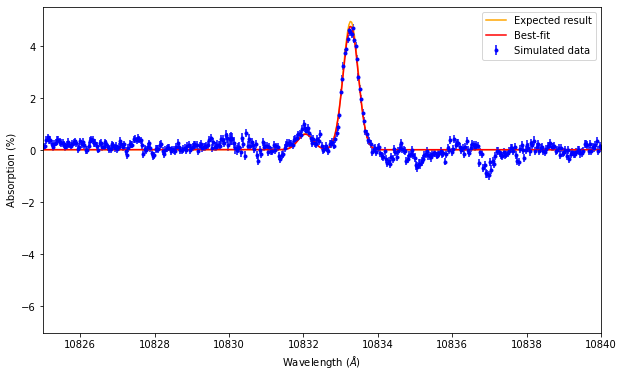

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.89630097e+03 -4.81525315e+14 -1.35028743e-04]


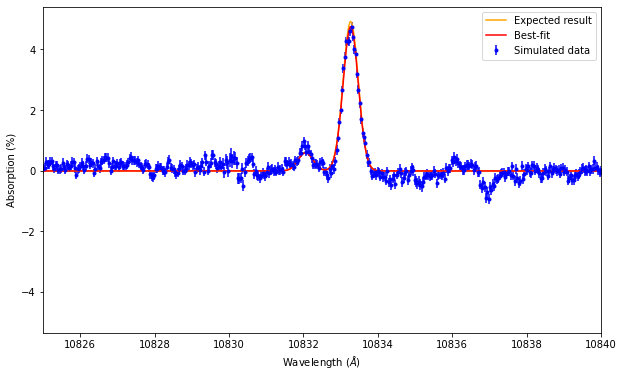

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07405587e+04 -4.84597446e+14  2.88652090e-04]


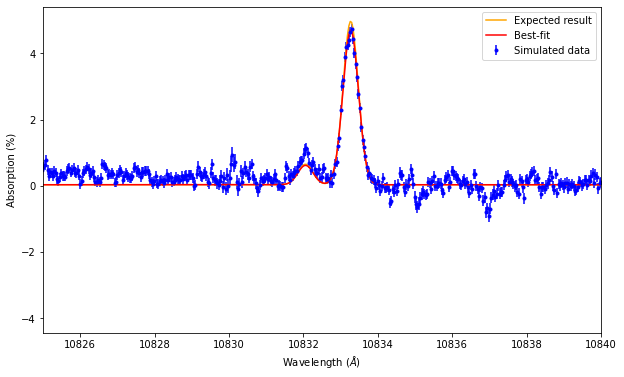

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.36738226e+03 -4.61107414e+14 -1.24517799e-04]


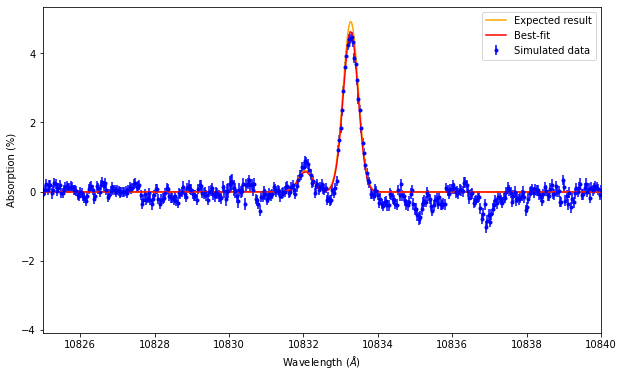

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12075018e+04 -4.89400806e+14 -1.99504441e-04]


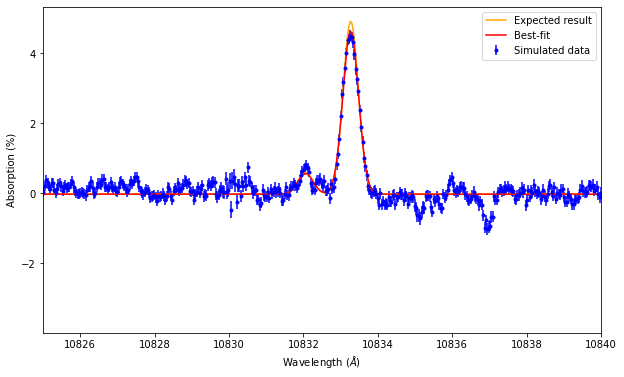

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.46822284e+03 -4.53892422e+14 -1.90319578e-04]


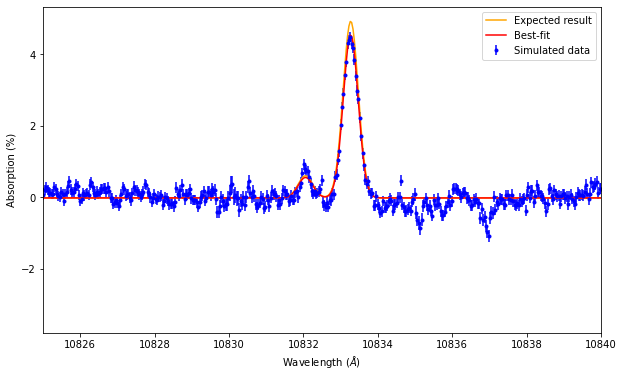

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.92470878e+03 -4.76930872e+14  8.25314179e-05]


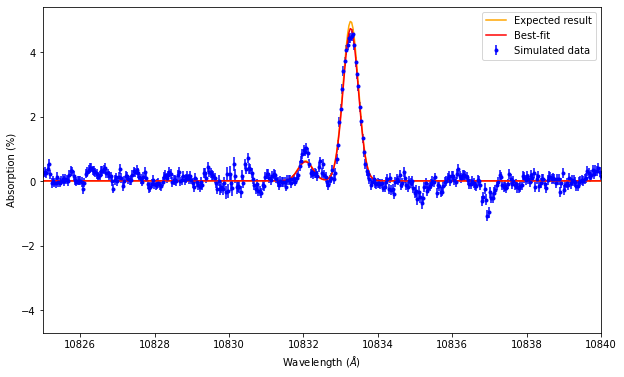

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13733916e+04 -4.89388839e+14 -1.75650323e-04]


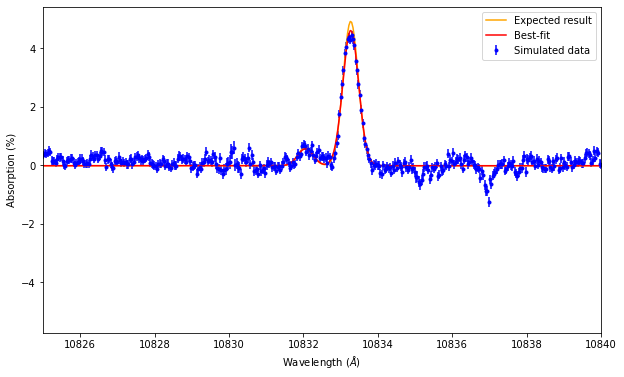

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.73939674e+03 -4.61981844e+14  3.45666001e-06]


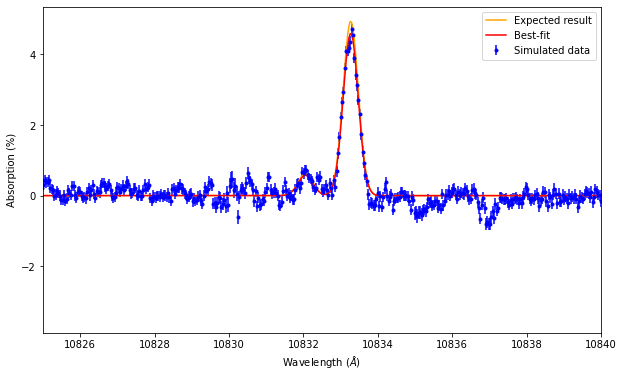

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.77972054e+03 -4.82901099e+14  6.01739260e-05]


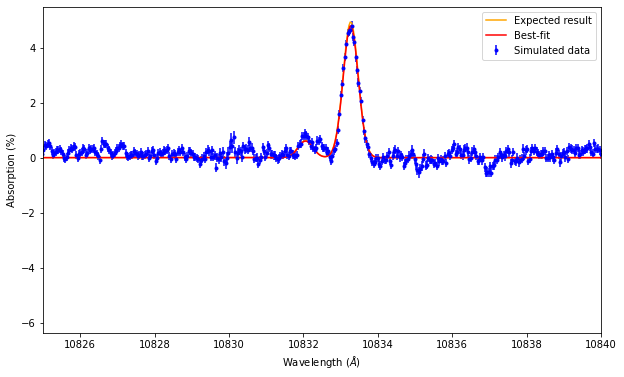

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.46514948e+03 -4.60059820e+14 -1.60736340e-04]


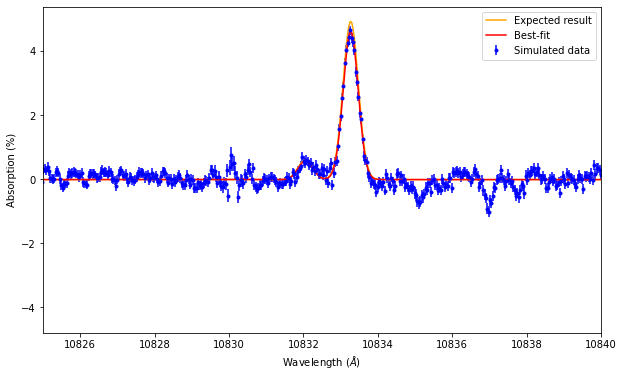

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06060206e+04 -4.80680056e+14 -1.53092055e-04]


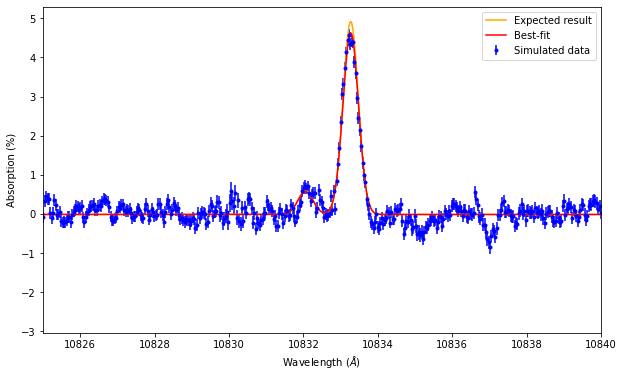

[ 1.25622109e+04 -5.40776132e+14  2.84815179e-04]


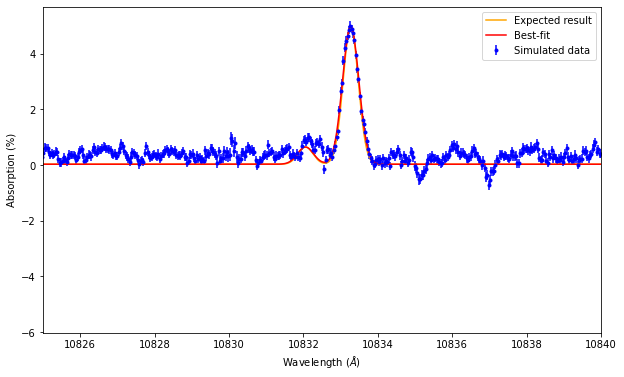

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07350366e+04 -4.79705892e+14 -1.84545587e-04]


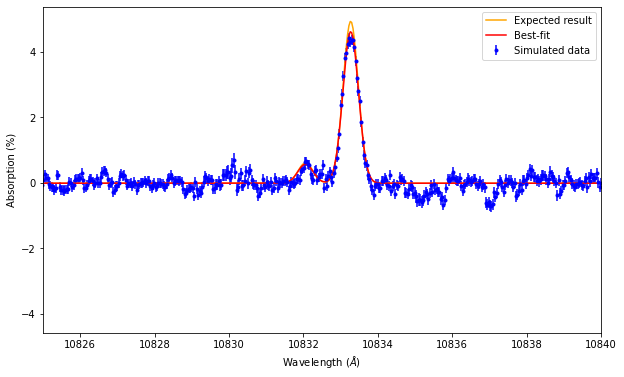

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09836322e+04 -4.98179239e+14  2.61096455e-04]


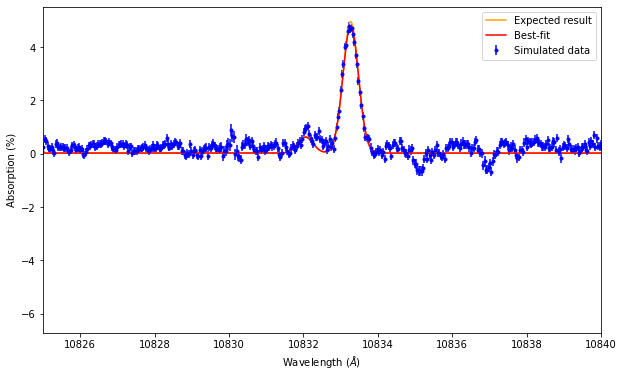

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09929760e+04 -4.85715803e+14 -8.09919031e-05]


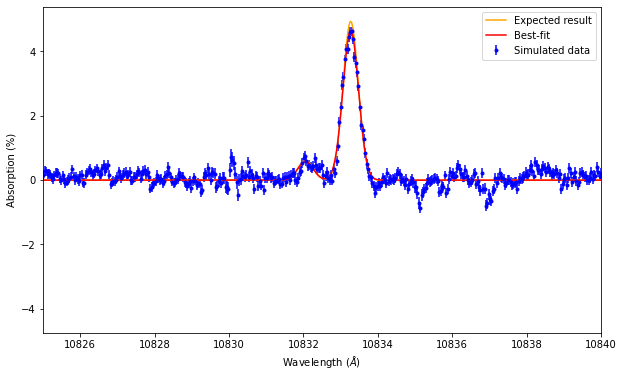

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.81234884e+03 -4.49980416e+14  1.88610319e-04]


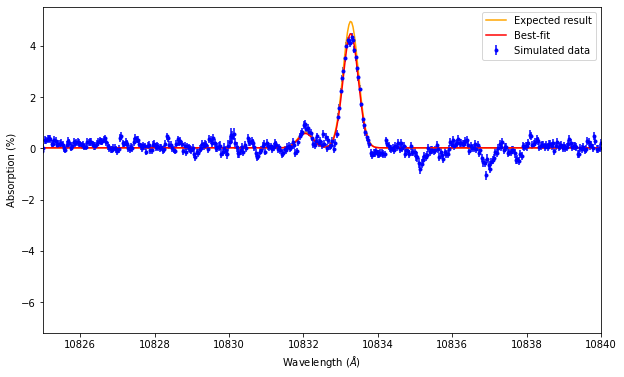

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01094373e+04 -4.70506518e+14  8.67968318e-05]


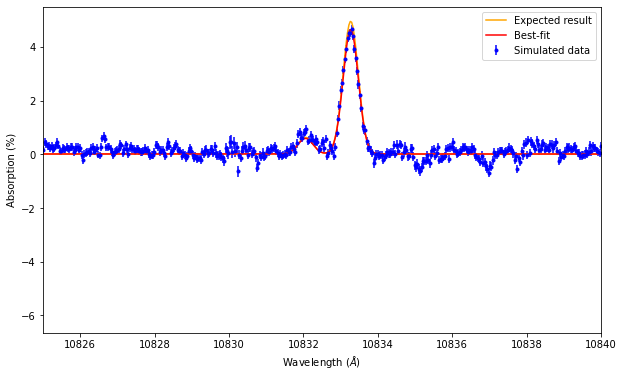

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01517226e+04 -4.70978185e+14 -5.52917308e-05]


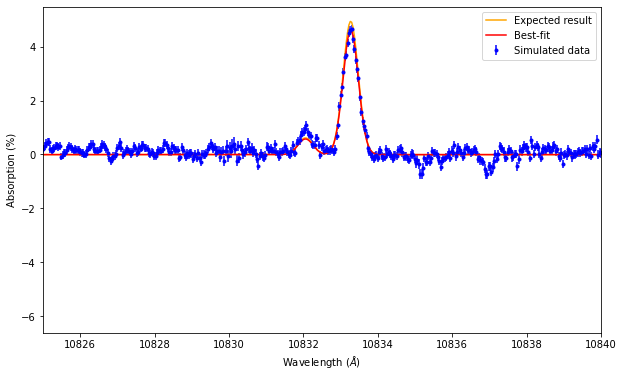

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.44054769e+03 -4.46408691e+14 -2.44683520e-04]


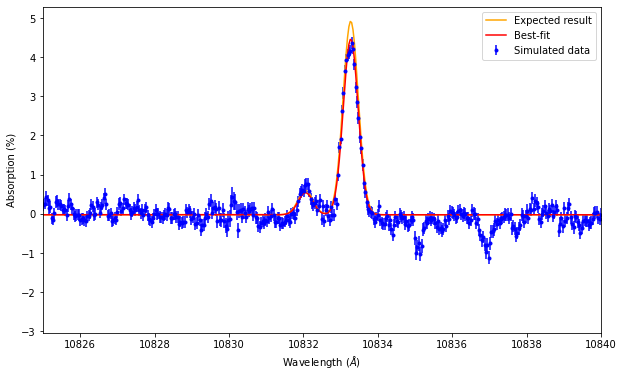

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.67888677e+03 -4.50540385e+14 -1.02233782e-04]


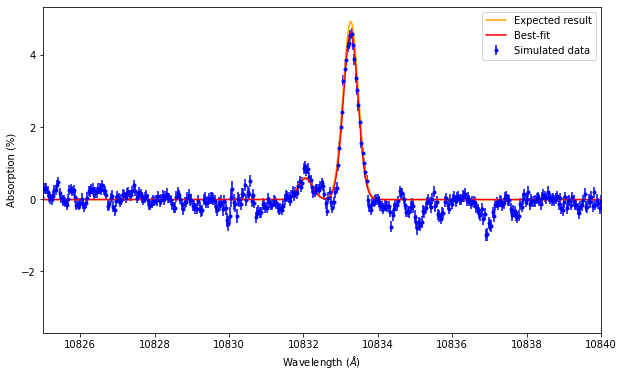

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09300823e+04 -5.06688790e+14 -1.09427172e-05]


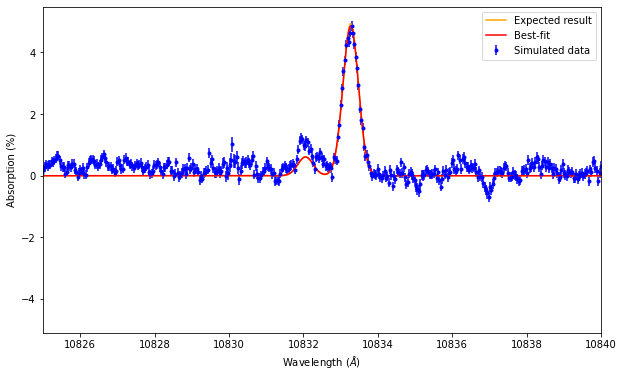

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.54549746e+03 -4.56139385e+14 -4.68223909e-05]


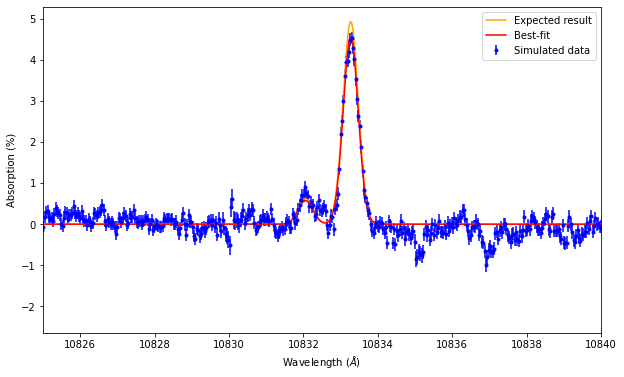

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01319186e+04 -4.57600588e+14 -1.77974125e-04]


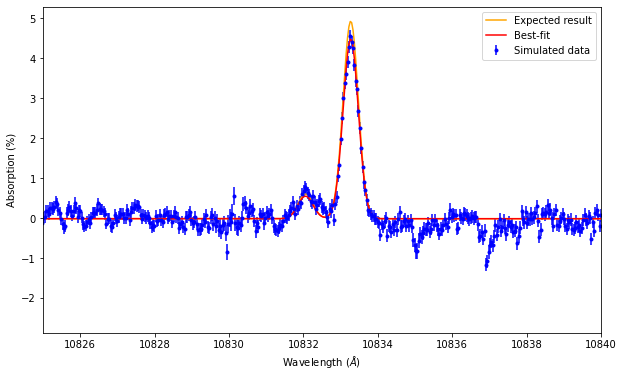

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07197516e+04 -4.65410916e+14  1.98968210e-04]


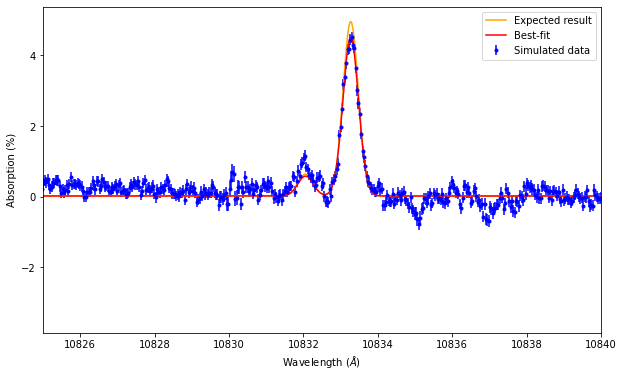

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07489778e+04 -4.78294919e+14  5.29482339e-05]


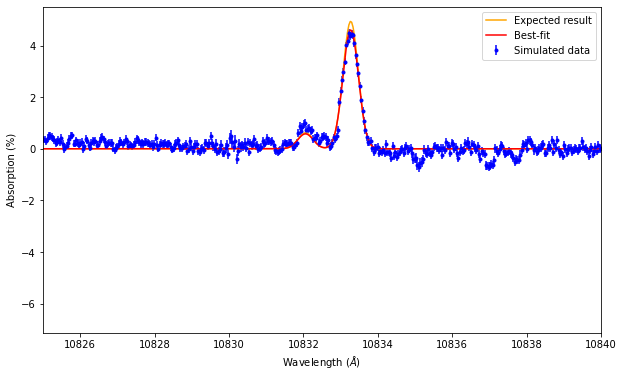

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15576525e+04 -4.95557631e+14  8.24207881e-05]


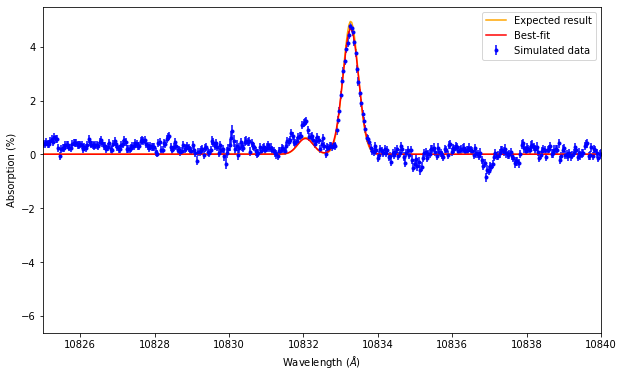

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.59131356e+03 -4.44165927e+14 -1.28980245e-04]


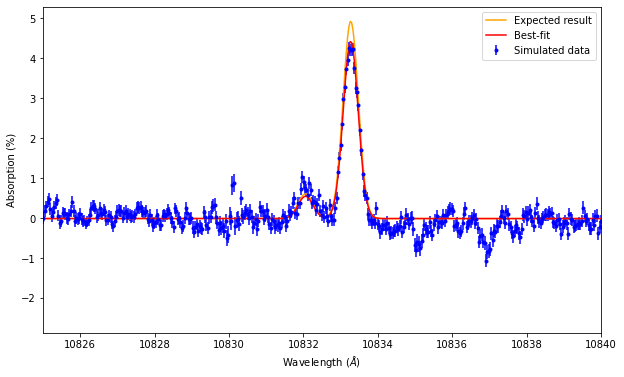

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.89713580e+03 -4.34437552e+14  3.21530097e-06]


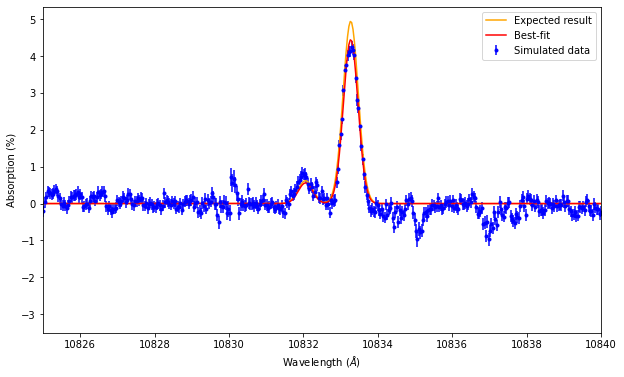

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.27544681e+03 -4.59535331e+14 -3.03331310e-05]


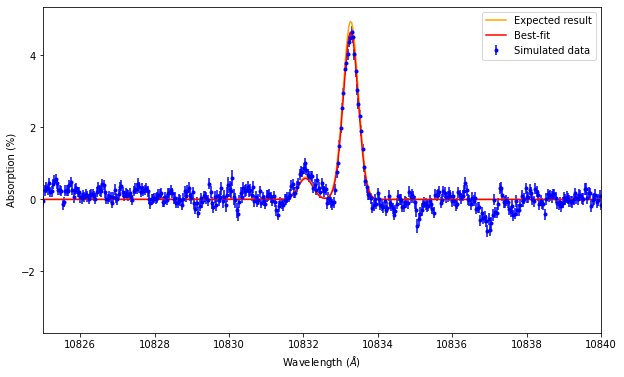

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05963873e+04 -4.79003227e+14 -3.30097159e-05]


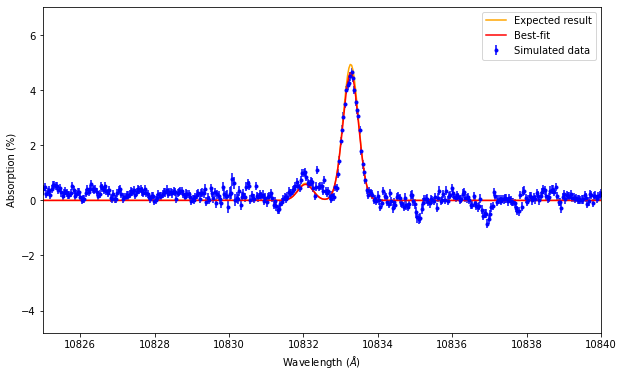

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.12562098e+03 -4.54067215e+14  6.83283655e-06]


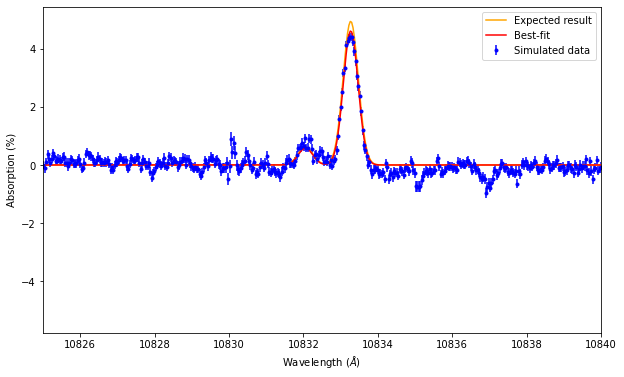

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.34793012e+03 -4.62549679e+14  3.27499952e-05]


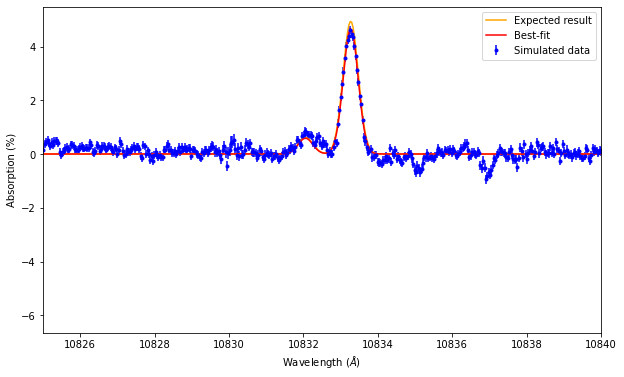

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.18913003e+03 -4.39660724e+14 -5.97735119e-05]


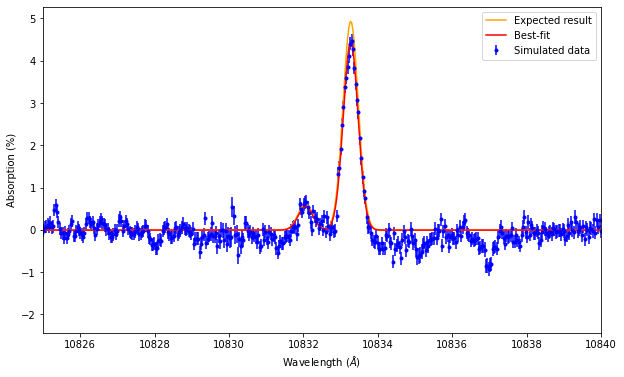

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04453173e+04 -4.62764653e+14  1.46667132e-04]


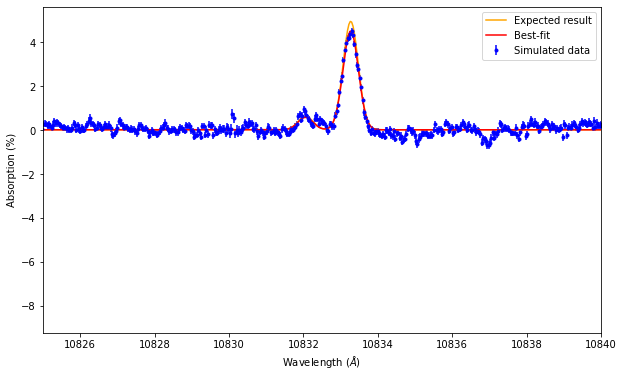

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.85182700e+03 -4.41938099e+14  6.34465310e-05]


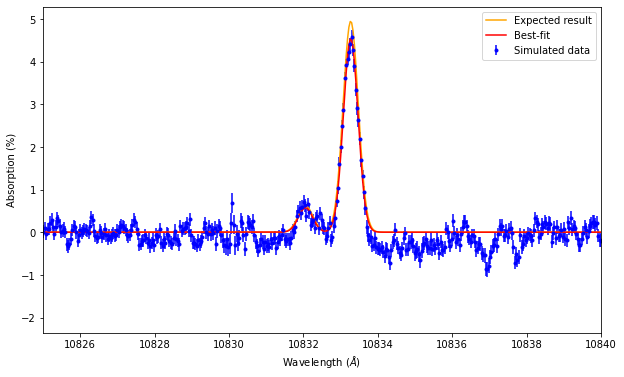

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.83121905e+03 -4.44534245e+14 -5.47816289e-05]


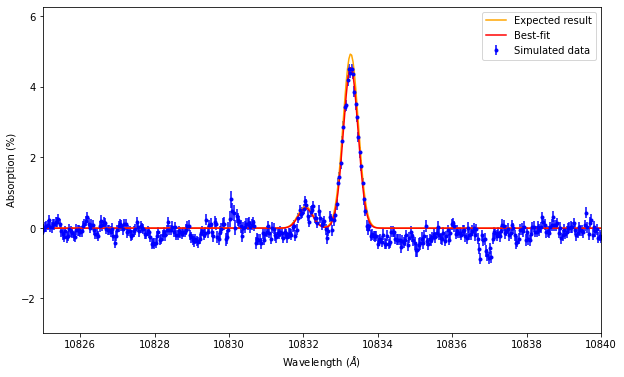

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.99125660e+03 -4.53511916e+14 -3.60409092e-04]


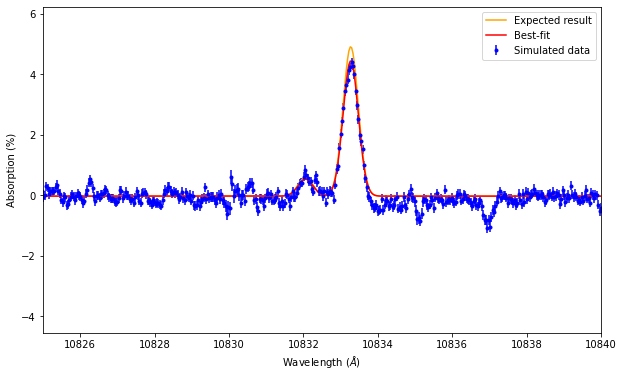

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01785295e+04 -4.85071918e+14 -1.19901056e-04]


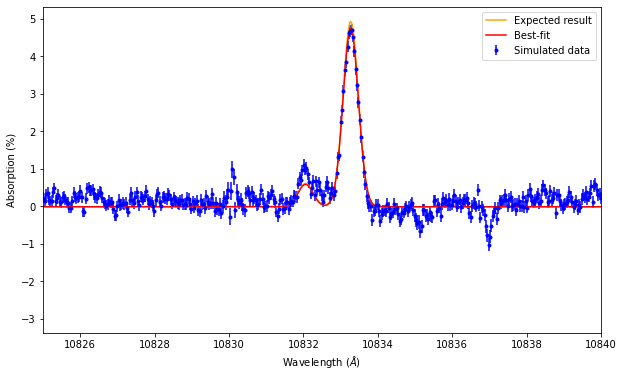

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03418792e+04 -4.71374031e+14 -1.01612487e-04]


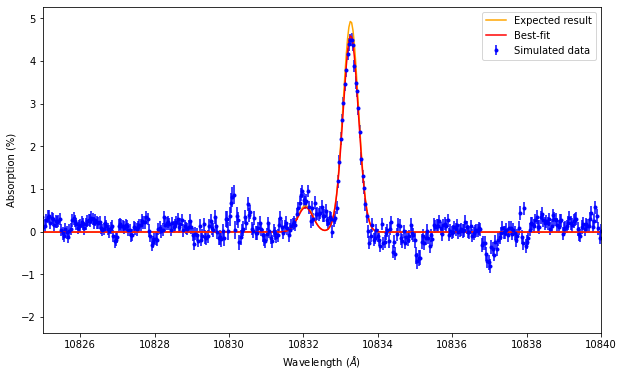

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.71014655e+03 -4.54103807e+14 -1.71615447e-04]


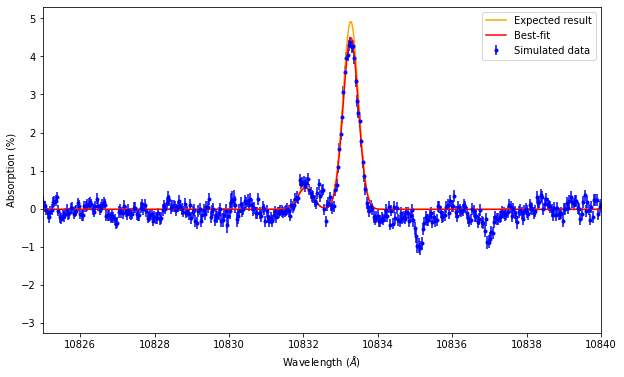

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11738759e+04 -4.85457700e+14 -1.67697601e-05]


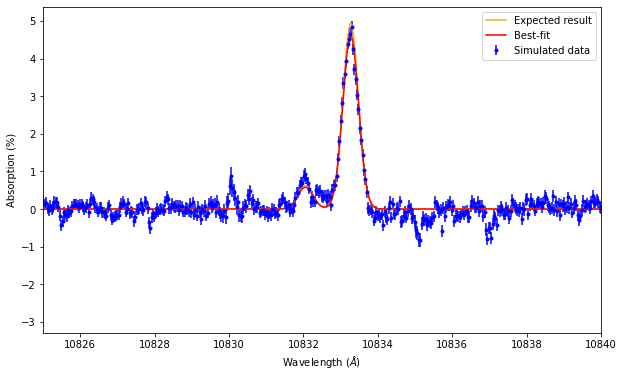

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05198518e+04 -4.80878381e+14 -1.72121154e-04]


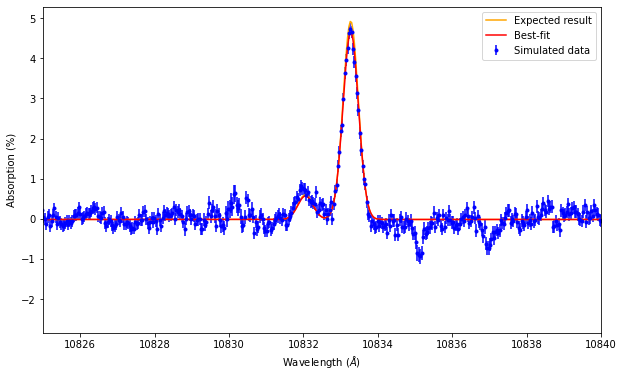

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02596853e+04 -4.75560327e+14 -6.18397883e-05]


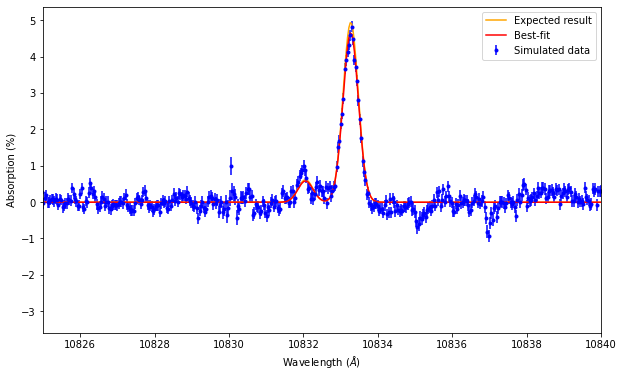

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10341380e+04 -5.03094539e+14 -2.36749128e-04]


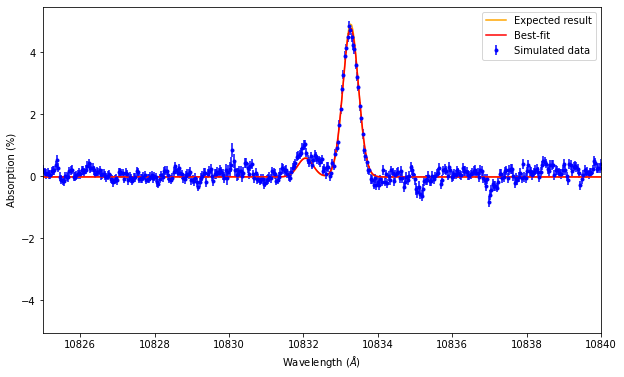

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.85177496e+03 -4.65716394e+14 -1.28847014e-04]


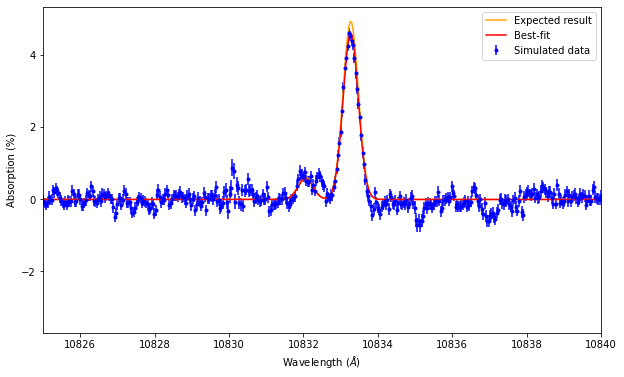

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06987132e+04 -4.98702145e+14  2.52920823e-05]


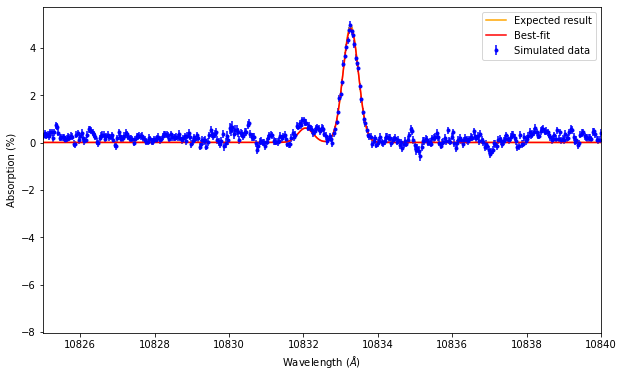

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00236301e+04 -4.61163079e+14 -2.99073631e-04]


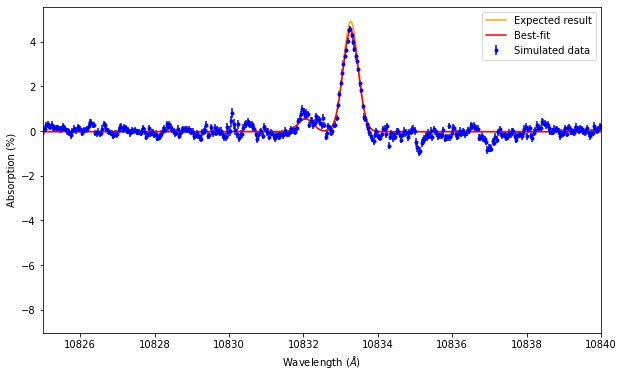

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.97273083e+03 -4.63473699e+14 -1.95067698e-04]


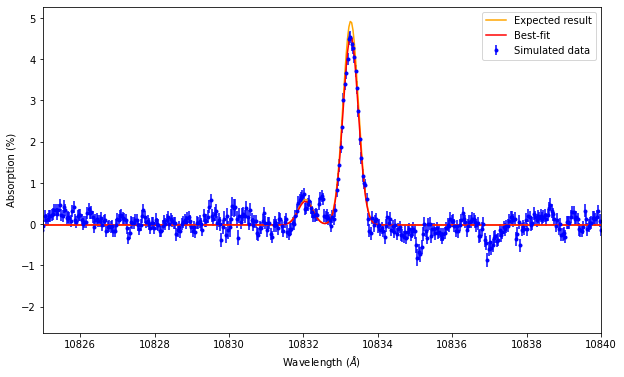

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.64682658e+03 -4.57551319e+14 -1.18611075e-05]


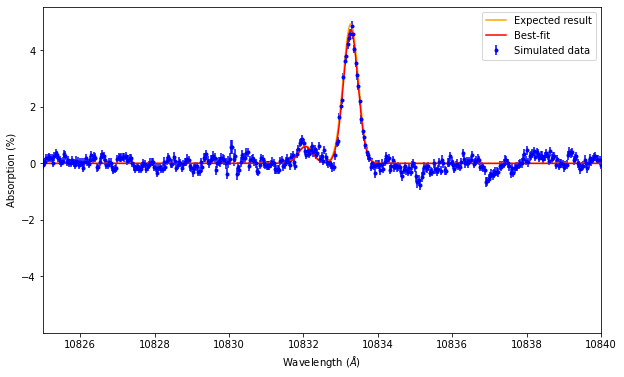

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 7.94585055e+03 -4.37205107e+14 -8.64086330e-05]


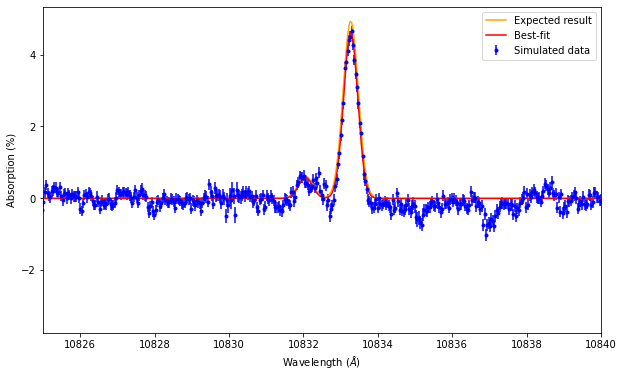

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.96456448e+03 -4.63160703e+14 -2.32000660e-05]


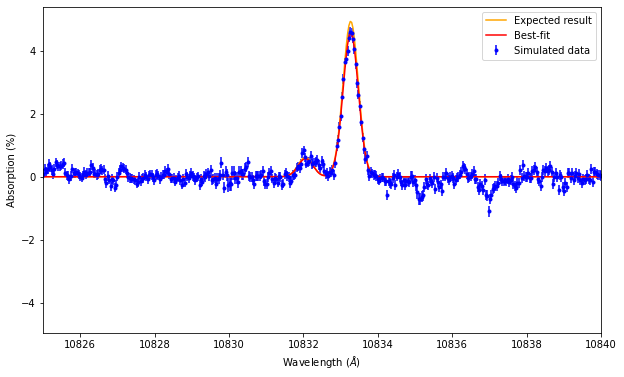

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.25976734e+03 -4.50896114e+14  5.98204289e-05]


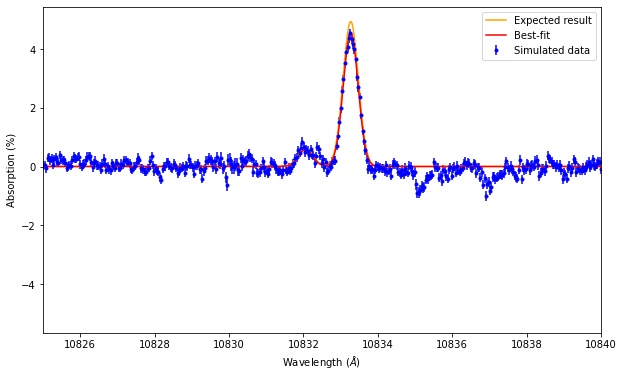

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04458442e+04 -4.71395030e+14 -1.08830112e-04]


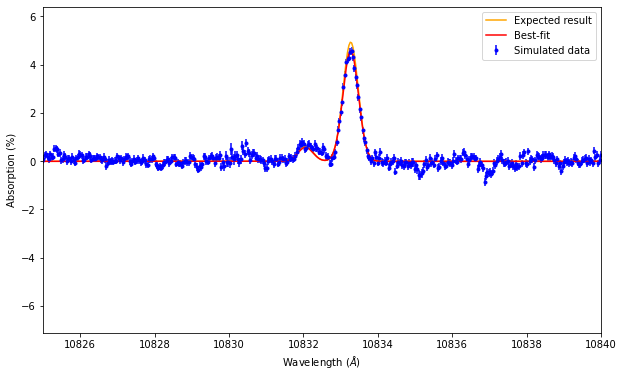

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03225776e+04 -4.80123571e+14 -2.27139528e-05]


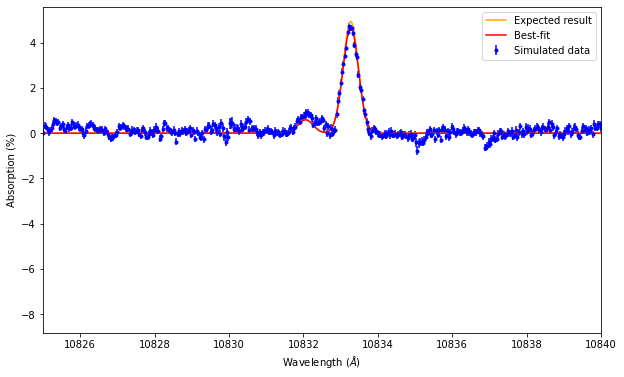

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.10256357e+03 -4.51564803e+14 -7.18487471e-05]


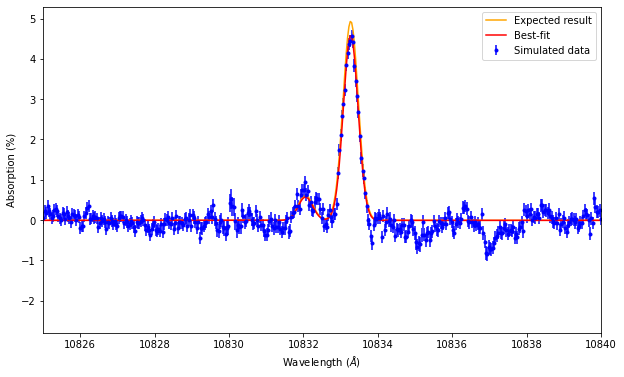

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02414080e+04 -4.83959073e+14 -4.66037988e-05]


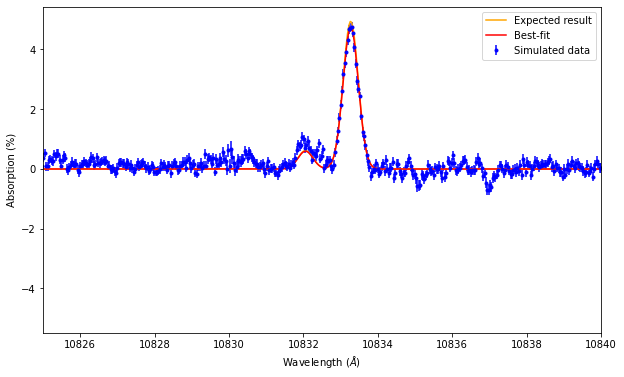

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02050806e+04 -4.69760742e+14 -1.05081579e-04]


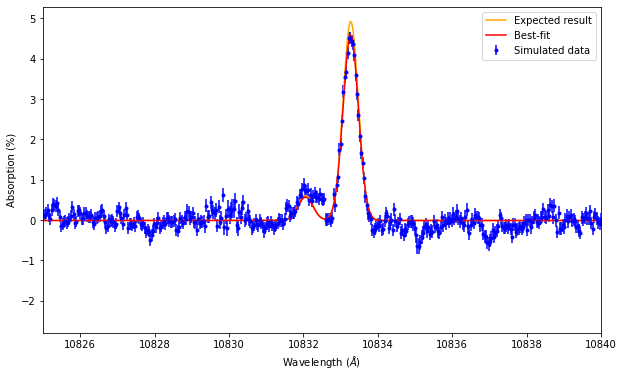

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00416091e+04 -4.69696356e+14 -1.55600365e-04]


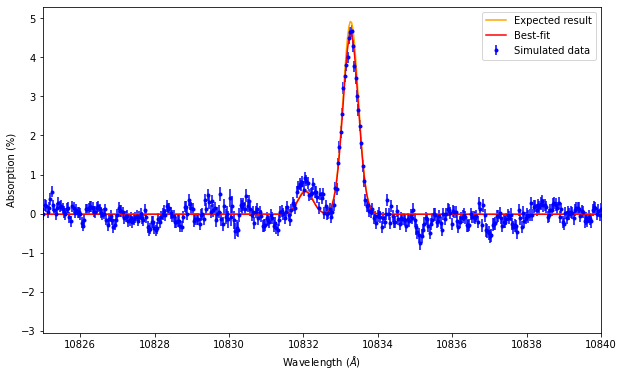

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14102719e+04 -5.06682885e+14  6.41969835e-05]


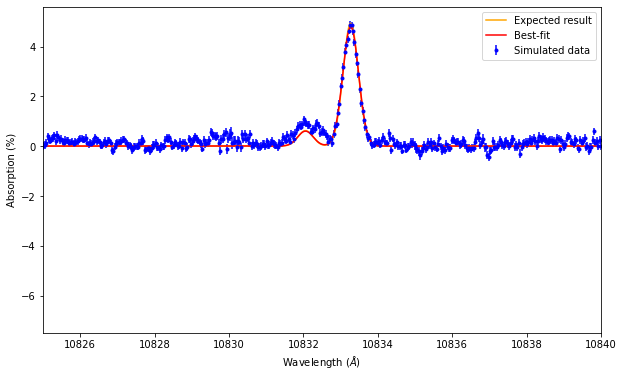

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02737160e+04 -4.87315977e+14 -2.50504046e-04]


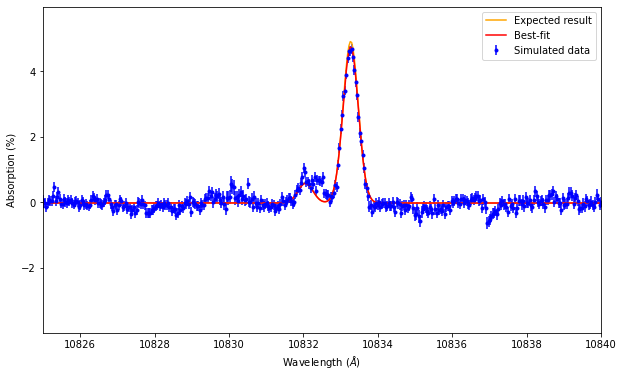

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.99057888e+03 -4.87090730e+14  6.17032466e-05]


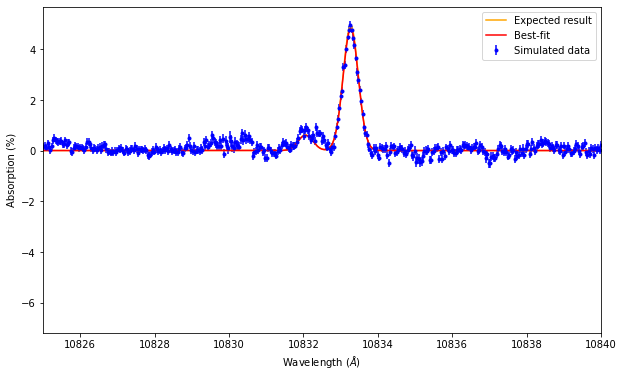

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04865348e+04 -4.93499490e+14 -1.53923473e-04]


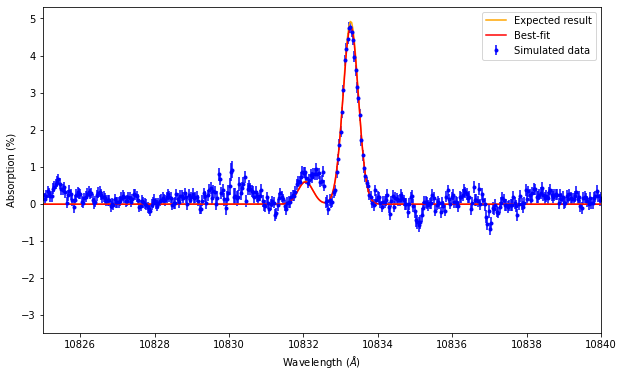

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.26829452e+03 -4.60377963e+14 -9.25394198e-05]


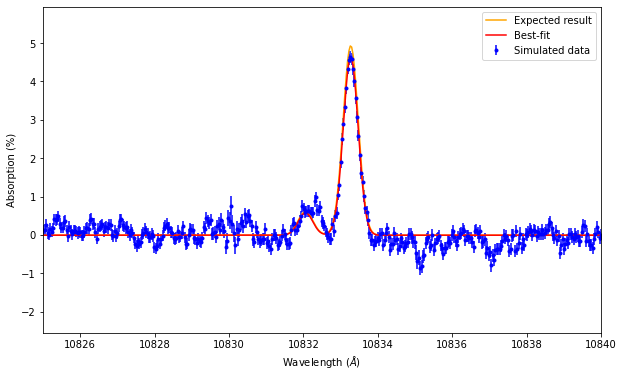

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.09086968e+03 -4.44585168e+14 -5.45440916e-05]


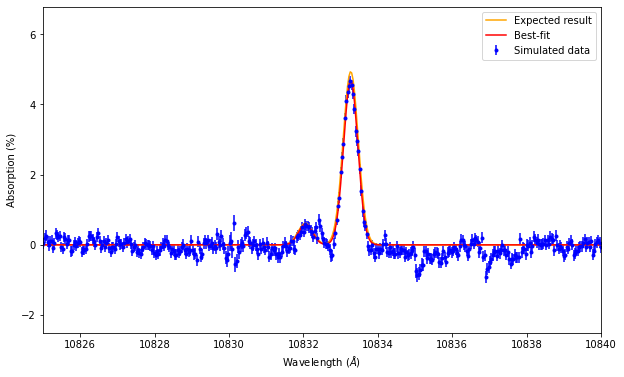

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06709720e+04 -4.93708682e+14  1.08046536e-04]


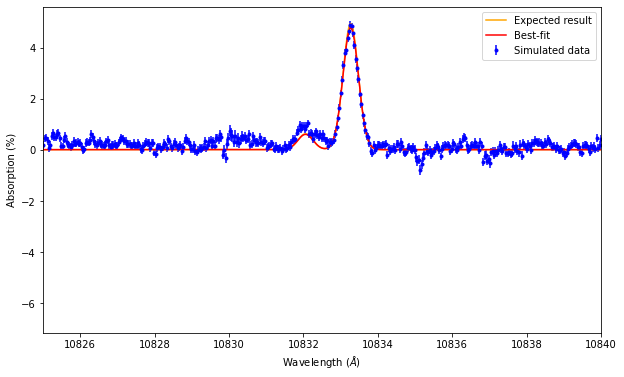

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07034414e+04 -4.78119813e+14 -2.36005281e-04]


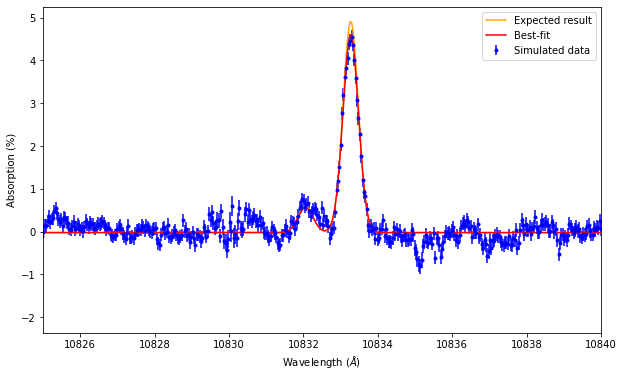

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.85084999e+03 -4.85975091e+14 -5.18750256e-05]


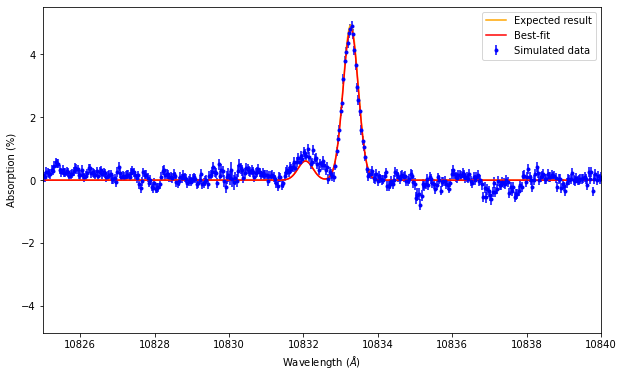

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.06445042e+03 -4.40935841e+14  2.58607486e-05]


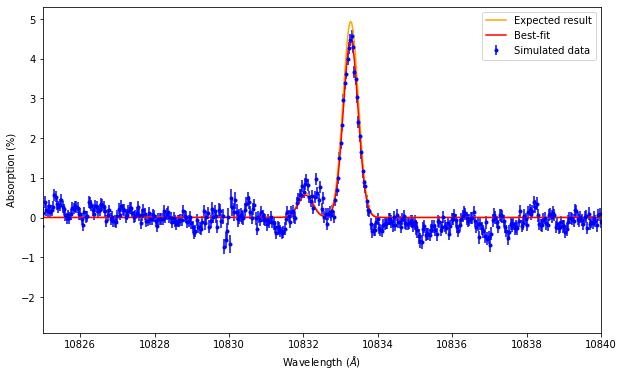

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07355838e+04 -4.89736127e+14  4.58921547e-05]


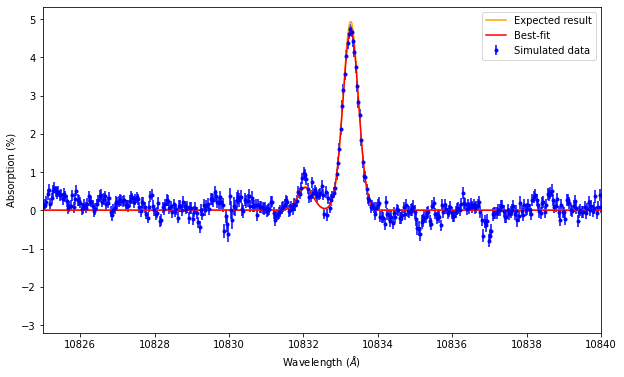

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.45910538e+03 -4.52010567e+14 -1.35641537e-04]


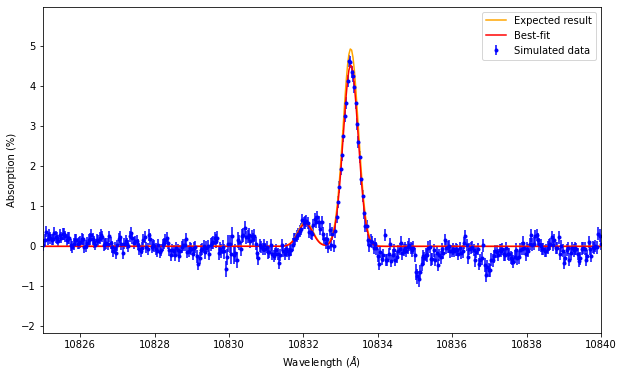

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06825627e+04 -4.87484027e+14  1.61919588e-04]


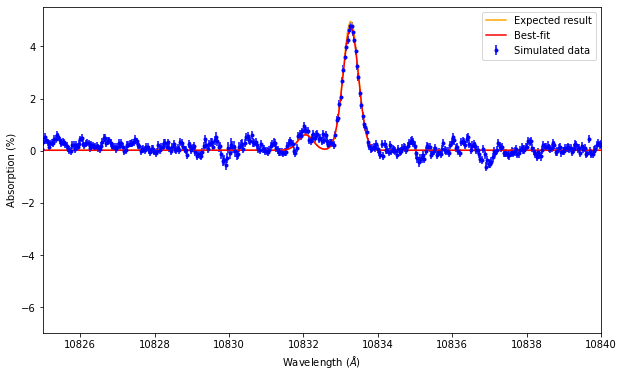

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.03591157e+03 -4.67796229e+14 -1.77525883e-04]


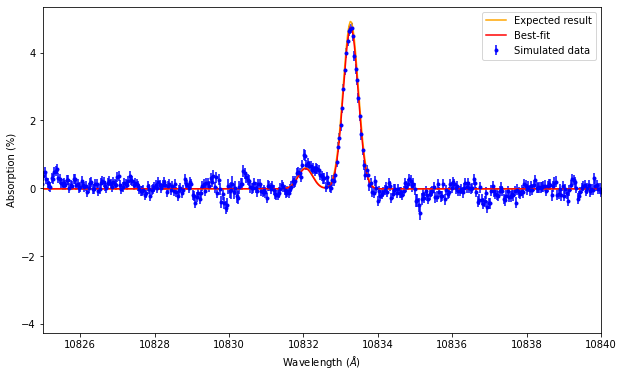

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.51703514e+03 -4.67440658e+14  1.41105813e-04]


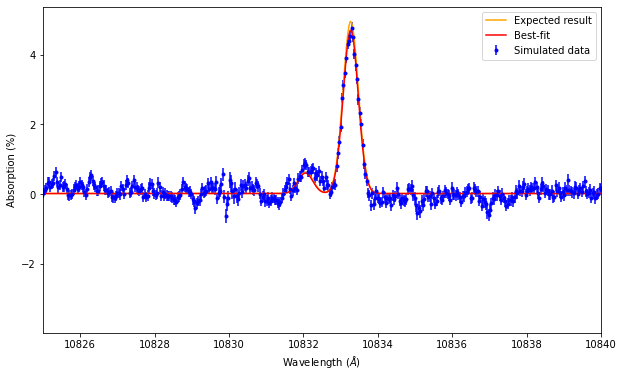

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.66145356e+03 -4.62345542e+14 -1.23796659e-04]


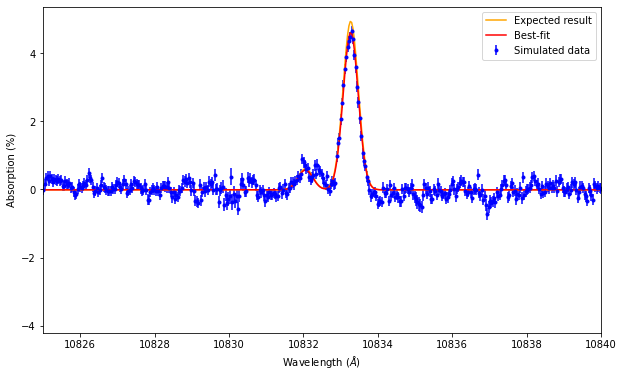

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.01375674e+03 -4.51801524e+14 -1.91375037e-04]


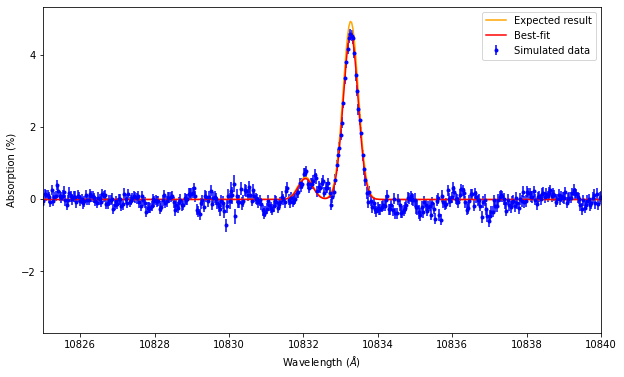

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07808006e+04 -4.88293694e+14  9.00207538e-05]


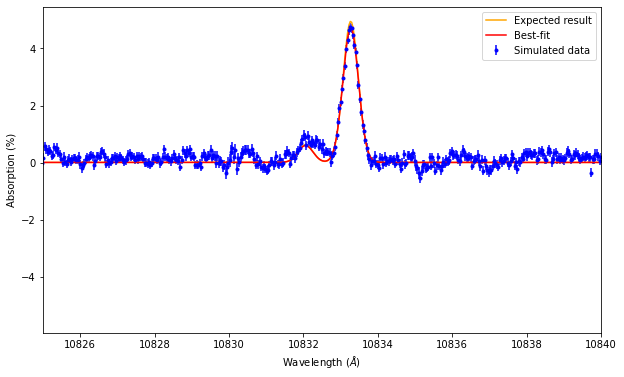

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15360436e+04 -4.98620389e+14 -1.00538882e-04]


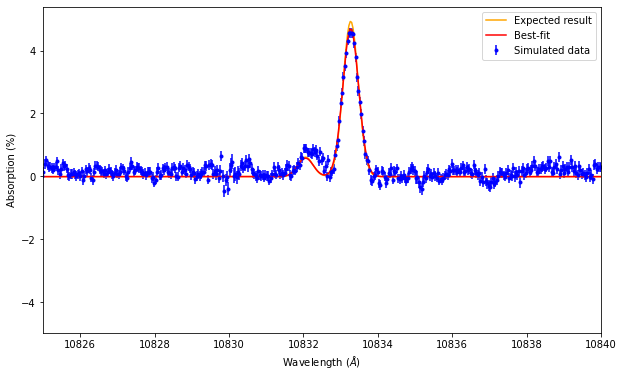

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 8.74845729e+03 -4.53557184e+14 -1.27959554e-04]


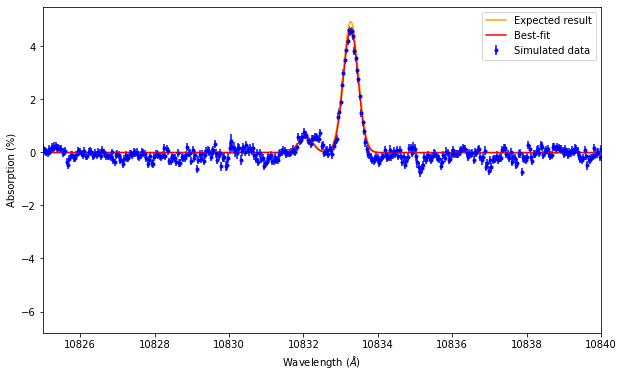

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11649629e+04 -5.02853075e+14  1.47627620e-05]


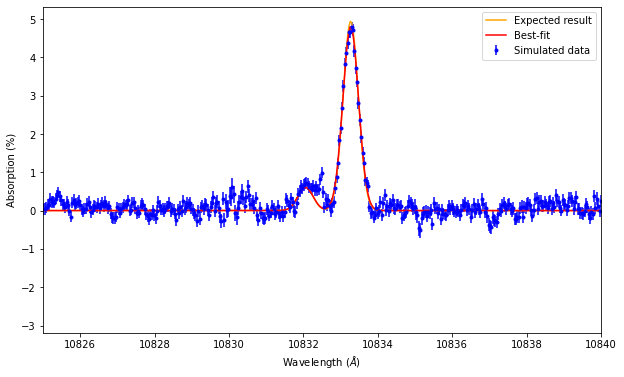

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.39375050e+03 -4.58224753e+14  1.39763195e-05]


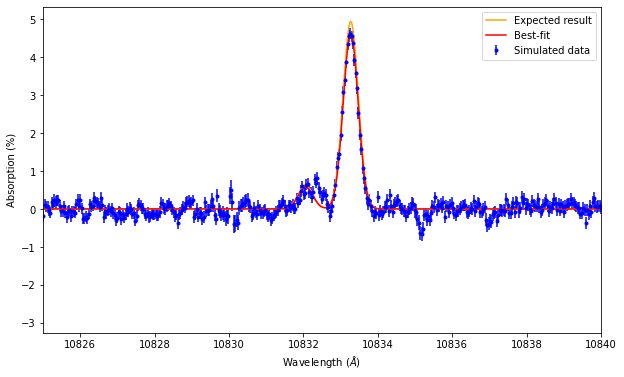

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.81428774e+03 -4.67622357e+14 -6.66749175e-05]


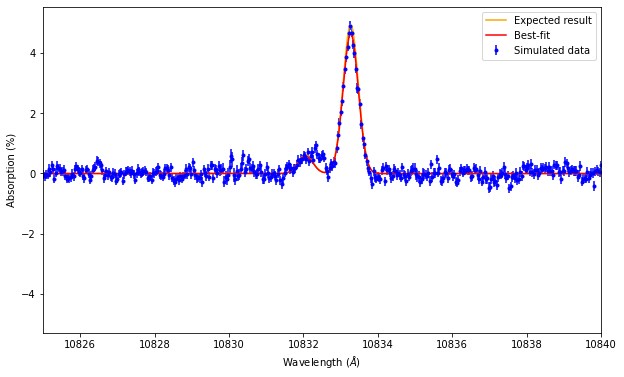

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09778845e+04 -4.77393875e+14 -1.62587901e-04]


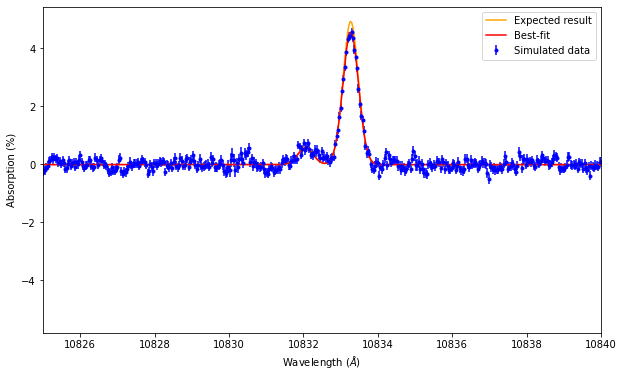

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09939480e+04 -4.89055070e+14 -1.92234434e-04]


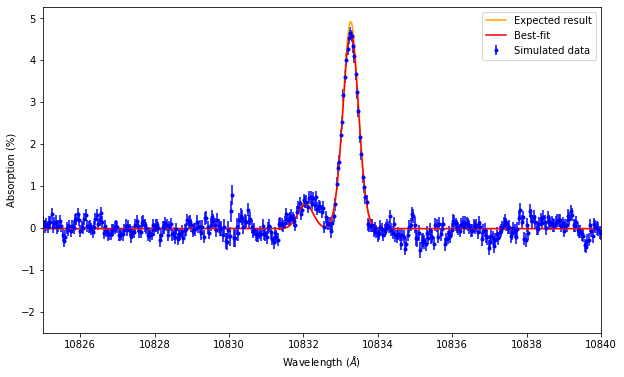

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01508255e+04 -4.60856910e+14 -4.38670816e-05]


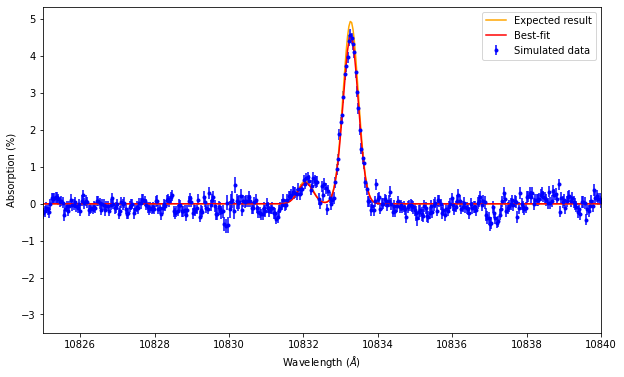

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13691079e+04 -4.88538839e+14  8.68745052e-05]


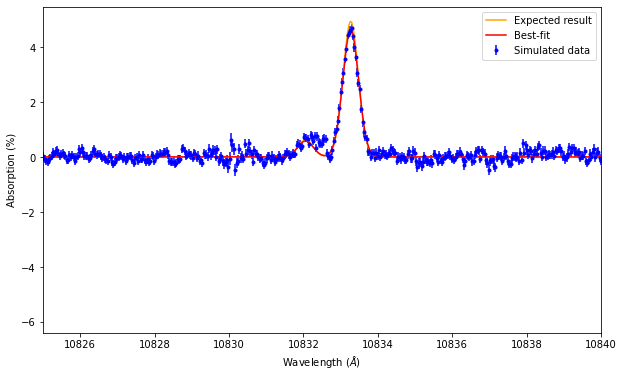

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.79969700e+03 -4.59789008e+14  5.55158480e-05]


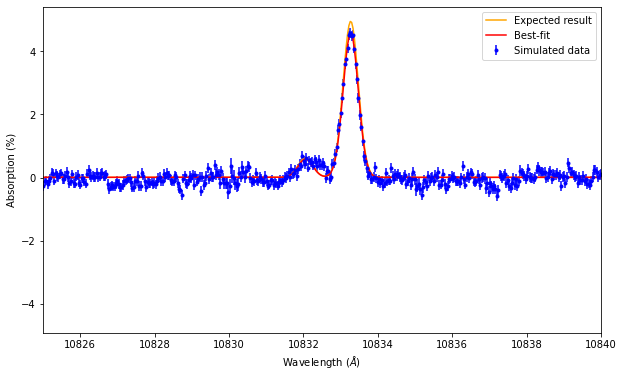

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.29045213e+03 -4.57930196e+14 -4.64934660e-05]


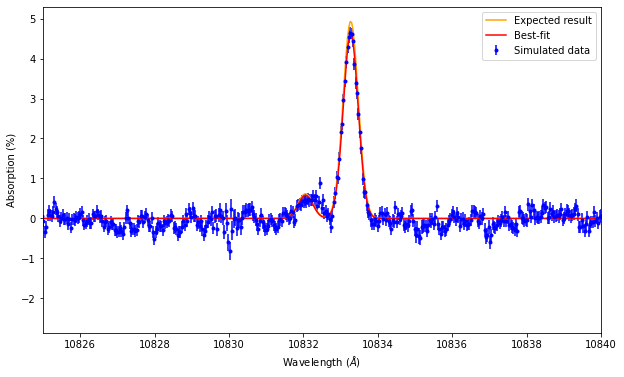

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04295014e+04 -4.74181841e+14 -1.38669989e-04]


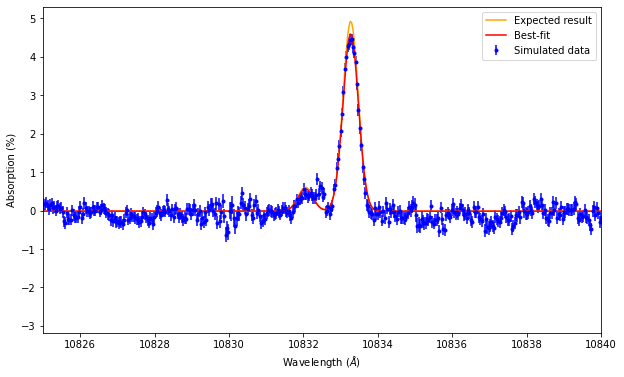

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.70996867e+03 -4.63681796e+14 -1.58158781e-04]


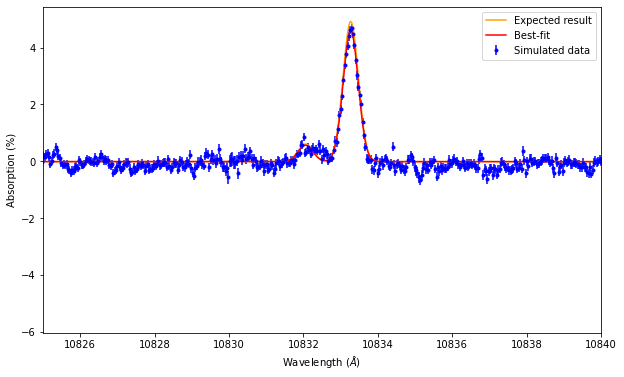

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.95663566e+03 -4.79835658e+14 -2.22483369e-04]


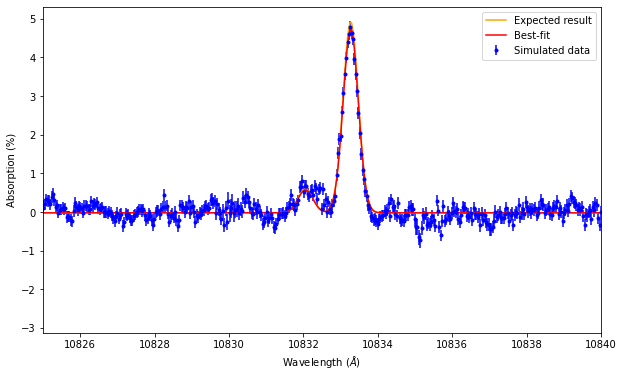

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.80195836e+03 -4.68692595e+14 -5.95280104e-05]


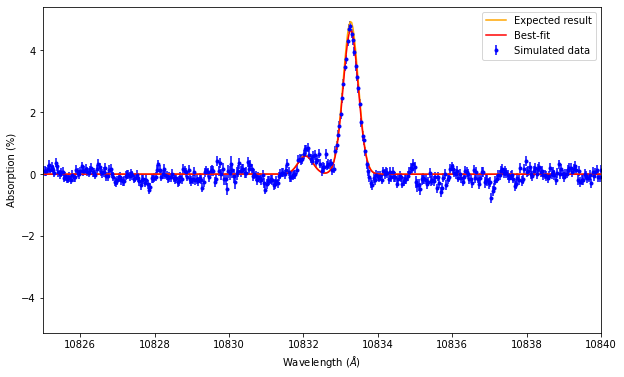

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07641456e+04 -4.93706967e+14 -9.60933971e-05]


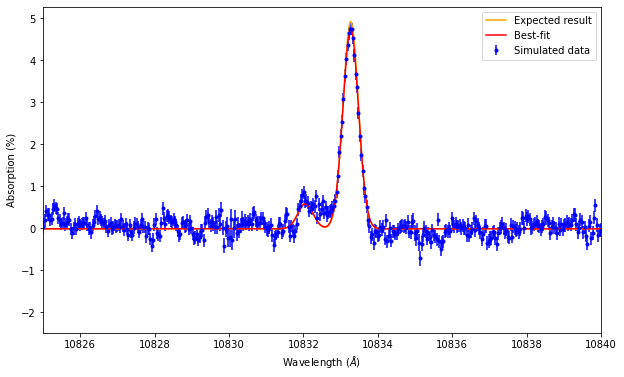

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.85032061e+03 -4.75728733e+14 -1.38991908e-04]


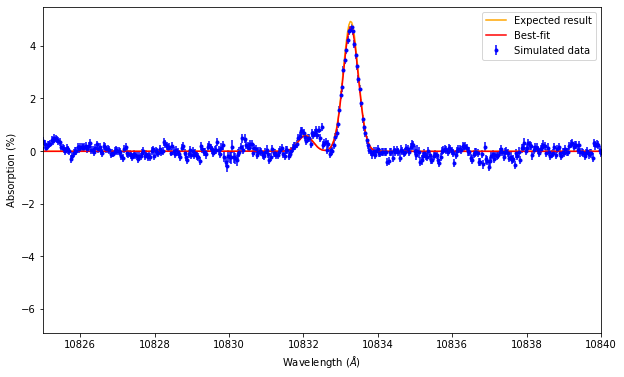

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.67827576e+03 -4.73903730e+14 -6.10056709e-06]


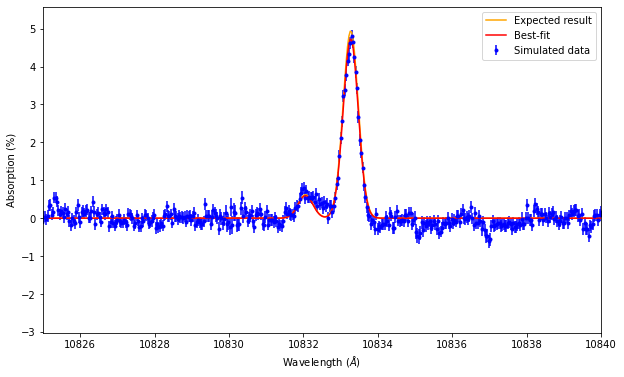

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18233712e+04 -5.01955619e+14 -1.95023471e-04]


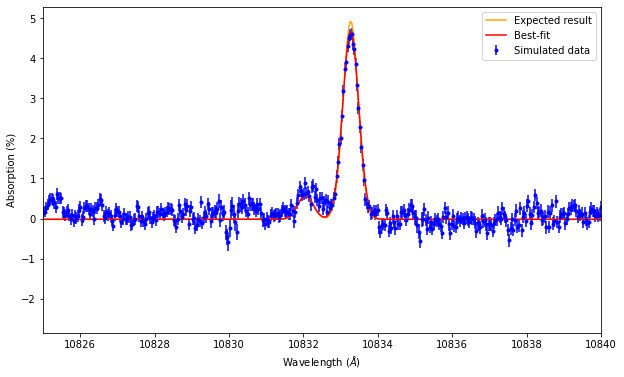

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07157690e+04 -4.93223555e+14  9.38210438e-05]


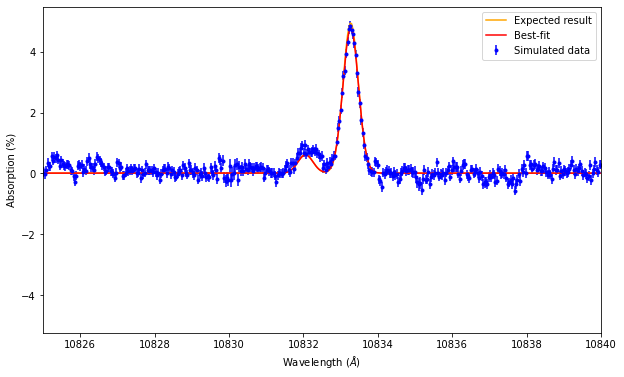

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11109339e+04 -5.01846346e+14  9.74897969e-05]


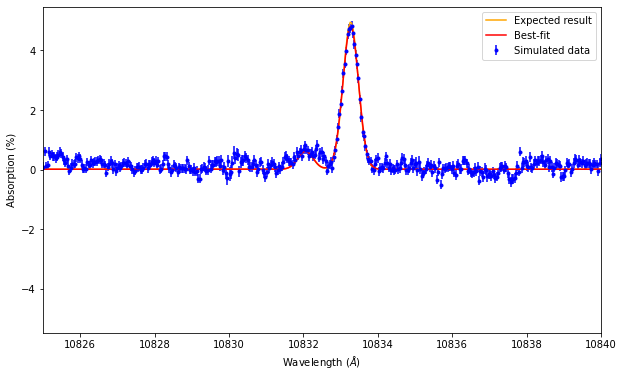

In [17]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function_HA(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HA[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HA)

    def absorption_function_HE(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HE[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HE)

    #Creating arrays to store the best-fit parameters and the error on them
    param_HA = np.zeros((len(diff_HA), 3))
    err_HA = np.zeros((len(diff_HA), 3))

    param_HE = np.zeros((len(diff_HE), 3))
    err_HE = np.zeros((len(diff_HE), 3))

    #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff_HA)):
        #Guess on the initial parameters
        guess = [16000, 1e14, np.median(diff_HA[i])]

        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HA, ref_wave, diff_HA[i], sigma = diff_HA_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HA[i] = params
        err_HA[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HA(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HA[i]-1+params[2]), yerr=100*diff_HA_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HA(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()
        
    for i in range(len(diff_HE)):
        #Guess on the initial parameters
        guess = [16000, 1e14, np.median(diff_HE[i])-1]
        print(np.median(diff_HE[i])-1)
        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HE, ref_wave, diff_HE[i], sigma=diff_HE_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HE[i] = params
        err_HE[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HE(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HE[i]-1+params[2]), yerr = 100*diff_HE_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HE(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'k', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()

#If there is one mode of observation
else:
    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power)

    #Creating arrays to store the best-fit parameters and the error on them
    param = np.zeros((len(diff), 3))
    err = np.zeros((len(diff), 3))
    
   #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff)):

        guess = [16000, 1e14, np.median(diff[i])]
        
        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function, ref_wave, diff[i], sigma=diff_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param[i] = params
        err[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff[i]-1+params[2]), 100*diff_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()


#For fitting purposes, we needed to have negative densities, so we revert to positive values.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    param_HA[:, 1] = -param_HA[:, 1]
    param_HE[:, 1] = -param_HE[:, 1]
#For fitting purposes, we needed to have negative densities, so we revert to positive values.
else:    
    param[:, 1] = -param[:, 1]



## Sanity check fit on the master absorption spectrum

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02327968e+04 -4.80859729e+14 -6.92737731e-05]


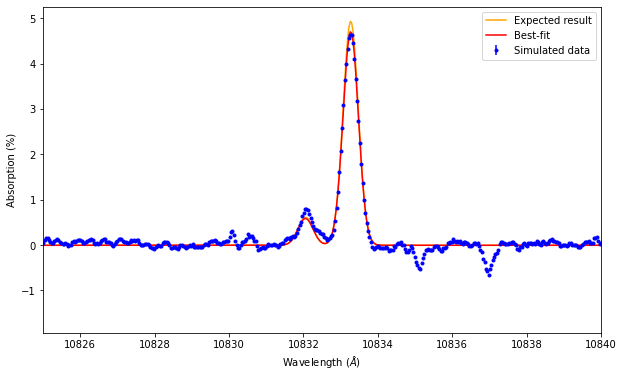

In [18]:

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
        
    diff_master_HA = offset+(master_outtransit_HA - master_planet_intransit_HA)/master_outtransit_HA

    diff_master_err_HA = np.sqrt((master_err_intransit_HA/master_outtransit_HA)**2 + ((master_err_intransit_HA * master_err_outtransit_HA)/(master_outtransit_HA**2))**2)

    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_master_HA.shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HA)

    guess = [16000, 1e14, np.median(diff_master_HA)]

    #Chi-squared minimization routine
    params, cov = curve_fit(absorption_function, ref_wave, diff_master_HA, sigma=diff_master_err_HA, p0=guess)

    #Storing the best-fit parameters and errors
    param_master_HA = params
    err_master_HA = np.sqrt(np.diag(cov))

    #Plotting the in-transit planetary spectra and their corresponding model
    print(params)
    plt.figure(figsize=[10, 6])
    model = absorption_function(ref_wave, params[0], params[1], params[2])
    plt.errorbar(ref_wave, 100*(diff_master_HA-1+params[2]), 100*diff_master_err_HA, fmt='b.', label='Simulated data')
    plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
    plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
    plt.xlim([10825, 10840])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Absorption (%)')
    plt.legend()
    plt.show()

    diff_master_HE = offset+(master_outtransit_HE - master_planet_intransit_HE)/master_outtransit_HE

    diff_master_err_HE = np.sqrt((master_err_intransit_HE/master_outtransit_HE)**2 + ((master_err_intransit_HE * master_err_outtransit_HE)/(master_outtransit_HE**2))**2)

    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_master_HE.shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HE)

    guess = [16000, 1e14, np.median(diff_master_HE)]

    #Chi-squared minimization routine
    params, cov = curve_fit(absorption_function, ref_wave, diff_master_HE, sigma=diff_master_err_HE, p0=guess)

    #Storing the best-fit parameters and errors
    param_master_HE = params
    err_master_HE = np.sqrt(np.diag(cov))

    #Plotting the in-transit planetary spectra and their corresponding model
    print(params)
    plt.figure(figsize=[10, 6])
    model = absorption_function(ref_wave, params[0], params[1], params[2])
    plt.errorbar(ref_wave, 100*(diff_master_HE-1+params[2]), 100*diff_master_err_HE, fmt='b.', label='Simulated data')
    plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
    plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
    plt.xlim([10825, 10840])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Absorption (%)')
    plt.legend()
    plt.show()
    
    
else:
    diff_master = offset+(master_outtransit - master_planet_intransit)/master_outtransit

    diff_master_err = np.sqrt((master_err_intransit/master_outtransit)**2 + ((master_err_intransit * master_err_outtransit)/(master_outtransit**2))**2)

    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_master.shape), temp, density, vsini, 'VACUUM', R_pow = R_power)

    guess = [16000, 1e14, np.median(diff_master)]

    #Chi-squared minimization routine
    params, cov = curve_fit(absorption_function, ref_wave, diff_master, sigma=diff_master_err, p0=guess)

    #Storing the best-fit parameters and errors
    param_master = params
    err_master = np.sqrt(np.diag(cov))

    #Plotting the in-transit planetary spectra and their corresponding model
    print(params)
    plt.figure(figsize=[10, 6])
    model = absorption_function(ref_wave, params[0], params[1], params[2])
    plt.errorbar(ref_wave, 100*(diff_master-1+params[2]), 100*diff_master_err, fmt='b.', label='Simulated data')
    plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
    plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
    plt.xlim([10825, 10840])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Absorption (%)')
    plt.legend()
    plt.show()


## Plotting retrieved parameters

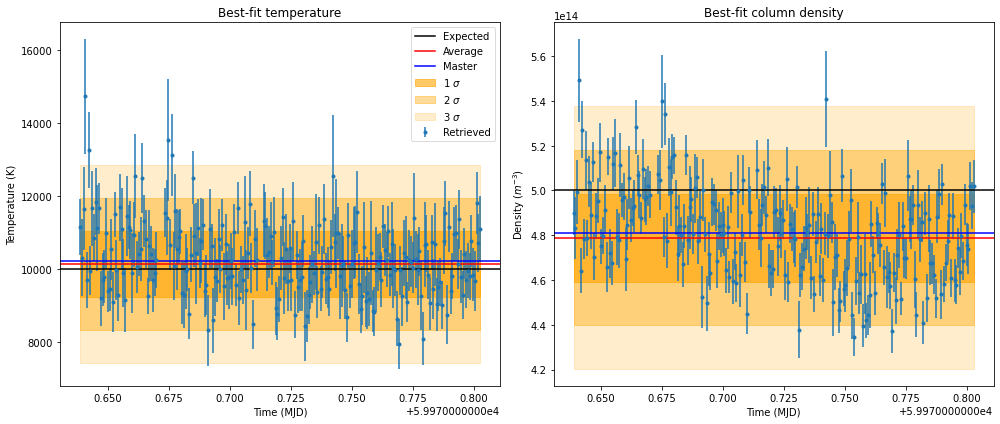

In [19]:
reload(AF)

#Defining a variable to save or not the results.
save = True

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[18, 12])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HA = np.average(param_HA[:, 0], weights=1/err_HA[:, 0]**2)
    weighted_std_T_HA = np.sqrt(np.average((param_HA[:, 0] - weighted_avg_T_HA)**2, weights=1/err_HA[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit_HA, param_HA[:, 0], yerr = err_HA[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature for HA')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T_HA, color='r', label='Average')
    ax1.axhline(param_master_HA[0], color='b', label='Master')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-weighted_std_T_HA, y2 = weighted_avg_T_HA+weighted_std_T_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-2*weighted_std_T_HA, y2 = weighted_avg_T_HA+2*weighted_std_T_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-3*weighted_std_T_HA, y2 = weighted_avg_T_HA+3*weighted_std_T_HA, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend(framealpha=0.8)
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HE = np.average(param_HE[:, 0], weights=1/err_HE[:, 0]**2)
    weighted_std_T_HE = np.sqrt(np.average((param_HE[:, 0] - weighted_avg_T_HE)**2, weights=1/err_HE[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax2.errorbar(date_in_transit_HE, param_HE[:, 0], yerr = err_HE[:, 0], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Temperature (K)')
    ax2.set_title('Best-fit temperature for HE')
    ax2.axhline(temperature, color='k', label='Expected')
    ax2.axhline(weighted_avg_T_HE, color='r', label='Average')
    ax2.axhline(param_master_HE[0], color='b', label='Master')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-weighted_std_T_HE, y2 = weighted_avg_T_HE+weighted_std_T_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-2*weighted_std_T_HE, y2 = weighted_avg_T_HE+2*weighted_std_T_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-3*weighted_std_T_HE, y2 = weighted_avg_T_HE+3*weighted_std_T_HE, alpha=0.2, color='orange', label='3 $\sigma$')
    
    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HA = np.average(param_HA[:, 1], weights=1/err_HA[:, 1]**2)
    weighted_std_rho_HA = np.sqrt(np.average((param_HA[:, 1] - weighted_avg_rho_HA)**2, weights=1/err_HA[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax3.errorbar(date_in_transit_HA, param_HA[:, 1], yerr = err_HA[:, 1], fmt='.', label='Retrieved')
    ax3.set_xlabel('Time (MJD)')
    ax3.set_ylabel('Density ($m^{-3}$)')
    ax3.set_title('Best-fit column density for HA')
    ax3.axhline(density, color='k', label='Expected')
    ax3.axhline(weighted_avg_rho_HA, color='r', label='Average')
    ax3.axhline(-param_master_HA[1], color='b', label='Master')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-weighted_std_rho_HA, y2 = weighted_avg_rho_HA+weighted_std_rho_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-2*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+2*weighted_std_rho_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-3*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+3*weighted_std_rho_HA, alpha=0.2, color='orange', label='3 $\sigma$')

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HE = np.average(param_HE[:, 1], weights=1/err_HE[:, 1]**2)
    weighted_std_rho_HE = np.sqrt(np.average((param_HE[:, 1] - weighted_avg_rho_HE)**2, weights=1/err_HE[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax4.errorbar(date_in_transit_HE, param_HE[:, 1], yerr = err_HE[:, 1], fmt='.', label='Retrieved ')
    ax4.set_xlabel('Time (MJD)')
    ax4.set_ylabel('Density ($m^{-3}$)')
    ax4.set_title('Best-fit column density for HE')
    ax4.axhline(density, color='k', label='Expected')
    ax4.axhline(weighted_avg_rho_HE, color='r', label='Average')
    ax4.axhline(-param_master_HE[1], color='b', label='Master')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-weighted_std_rho_HE, y2 = weighted_avg_rho_HE+weighted_std_rho_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-2*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+2*weighted_std_rho_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-3*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+3*weighted_std_rho_HE, alpha=0.2, color='orange', label='3 $\sigma$')

    ax1.sharey(ax2)
    ax3.sharey(ax4)

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')

#If there is one mode of observation
else:
    
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T = np.average(param[:, 0], weights=1/err[:, 0]**2)
    weighted_std_T = np.sqrt(np.average((param[:, 0] - weighted_avg_T)**2, weights=1/err[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit, param[:, 0], yerr = err[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T, color='r', label='Average')
    ax1.axhline(param_master[0], color='b', label='Master')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-weighted_std_T, y2 = weighted_avg_T+weighted_std_T, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-2*weighted_std_T, y2 = weighted_avg_T+2*weighted_std_T, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-3*weighted_std_T, y2 = weighted_avg_T+3*weighted_std_T, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend(framealpha=.7)

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho = np.average(param[:, 1], weights=1/err[:, 1]**2)
    weighted_std_rho = np.sqrt(np.average((param[:, 1] - weighted_avg_rho)**2, weights=1/err[:, 1]**2))
        
    #Plotting the retrieved densities.
    ax2.errorbar(date_in_transit, param[:, 1], yerr = err[:, 1], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Density ($m^{-3}$)')
    ax2.set_title('Best-fit column density')
    ax2.axhline(density, color='k', label='Expected')
    ax2.axhline(weighted_avg_rho, color='r', label='Average')
    ax2.axhline(-param_master[1], color='b', label='Master')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-weighted_std_rho, y2 = weighted_avg_rho+weighted_std_rho, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-2*weighted_std_rho, y2 = weighted_avg_rho+2*weighted_std_rho, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-3*weighted_std_rho, y2 = weighted_avg_rho+3*weighted_std_rho, alpha=0.2, color='orange', label='3 $\sigma$')

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')
   